In [199]:
import pandas as pd
import numpy as np
import psycopg2
import os
from dotenv import load_dotenv
import sys #permite navegar por el sistema
sys.path.append("../") #solo aplica al soporte
import os
from dotenv import load_dotenv
import unicodedata
from src.etl import load as lo #con jupyter
from src.eda import explore as exp  #con jupyter
from src.etl import extract as ex #con jupyter
import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
load_dotenv()

True

In [201]:
#Llamamos a la variable de entorno
DB_NAME = os.getenv("DB_NAME")
DB_USER=os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST= os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

In [202]:
conn, cur = lo.crear_conexión()
#Comprobamos que la conexión está bien realizada:
cur.execute("SELECT version();")
cur.fetchone() #para que muestre el resultado de la query anterior
lo.cerrar_conexion(conn, cur)

# 1. Extracción de los datos de la BBDD

## Paises

In [619]:
query_extraccion = '''SELECT *
                                    FROM pais_destino'''        

In [620]:
lista_columnas = ['id_pais_destino','nombre_pais_destino', 'nombre_continente']
df_paises = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_paises.head()

id_pais_destino nombre_pais_destino nombre_continente
0                1             Albania            Europa
1                2            Alemania            Europa
2                3             Andorra            Europa
3                4              Angola            África
4                5             Antigua           América

## Viajes localizados según página web

In [621]:
query_extraccion = '''SELECT pd.*,
                                                        v.*
                                                    FROM viaje v
                                                    LEFT JOIN combinacion_destino_viaje cdv ON v.id_viaje = cdv.id_viaje
                                                    LEFT JOIN pais_destino pd ON cdv.id_pais_destino =pd.id_pais_destino'''     

In [622]:
lista_columnas = ['id_pais_destino', 'nombre_pais_destino', 'nombre_continente', 'id_viaje', 'url_viaje', 
                  'nombre_viaje','duracion_dias', 'duracion_noches', 'id_itinerario', 'viaje_activo']

In [624]:
df_viajes_localizacion_pag_web = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_viajes_localizacion_pag_web.head()

id_pais_destino nombre_pais_destino nombre_continente  id_viaje  \
0                1             Albania            Europa         1   
1                2            Alemania            Europa         2   
2                2            Alemania            Europa         3   
3                2            Alemania            Europa         4   
4                2            Alemania            Europa         5   

                                           url_viaje  \
0      https://es.tui.com/viaje/albania-y-montenegro   
1  https://viajeonline.es.tui.com/es/idea/1463025...   
2  https://viajeonline.es.tui.com/es/idea/7897512...   
3  https://viajeonline.es.tui.com/es/idea/8404511...   
4  https://viajeonline.es.tui.com/es/idea/7906930...   

                                  nombre_viaje  duracion_dias  \
0                         Albania y Montenegro              8   
1                                       Berlín              4   
2  Fly & Drive Austria, Entre Lagos y Montañas              8   
3             Fly & Drive Carlomagno a su aire             10   
4                Fly & Drive Tirol al Completo              8   

   duracion_noches  id_itinerario  viaje_activo  
0                7         1027.0          True  
1                3          146.0          True  
2                7          872.0          True  
3                9          166.0          True  
4                7         1145.0          True

In [626]:
df_viajes_localizacion_pag_web_agrupado_pais = df_viajes_localizacion_pag_web.groupby('id_pais_destino')[['id_viaje']].nunique().reset_index()
df_viajes_localizacion_pag_web_agrupado_pais.head()

id_pais_destino  id_viaje
0                1         6
1                2        20
2                5         2
3                6         1
4                8        26

In [209]:
len(df_viajes_localizacion_pag_web.id_pais_destino.unique())

126

## Viajes según localización ciudades

In [627]:
query_extraccion = '''SELECT pd.*,
	v.*,
	c.id_ciudad,
	c.nombre_ciudad
FROM viaje v
INNER JOIN itinerario i ON v.id_itinerario = i.id_itinerario
INNER JOIN ciudad_itinerario ci ON i.id_itinerario = ci.id_itinerario
INNER JOIN ciudad c ON ci.id_ciudad = c.id_ciudad
INNER JOIN pais_destino pd ON c.id_pais_destino =pd.id_pais_destino'''


In [628]:
lista_columnas = ['id_pais_destino', 'nombre_pais_destino', 'nombre_continente', 'id_viaje', 'url_viaje', 
                  'nombre_viaje','duracion_dias', 'duracion_noches', 'id_itinerario', 'viaje_activo', 'id_ciudad', 'nombre_ciudad']

In [630]:
df_viajes_localizacion_ciudad = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_viajes_localizacion_ciudad.head()

id_pais_destino nombre_pais_destino nombre_continente  id_viaje  \
0              119          Montenegro            Europa         1   
1              119          Montenegro            Europa         1   
2              119          Montenegro            Europa         1   
3              119          Montenegro            Europa         1   
4                1             Albania            Europa         1   

                                       url_viaje          nombre_viaje  \
0  https://es.tui.com/viaje/albania-y-montenegro  Albania y Montenegro   
1  https://es.tui.com/viaje/albania-y-montenegro  Albania y Montenegro   
2  https://es.tui.com/viaje/albania-y-montenegro  Albania y Montenegro   
3  https://es.tui.com/viaje/albania-y-montenegro  Albania y Montenegro   
4  https://es.tui.com/viaje/albania-y-montenegro  Albania y Montenegro   

   duracion_dias  duracion_noches  id_itinerario  viaje_activo  id_ciudad  \
0              8                7           1027          True          9   
1              8                7           1027          True          8   
2              8                7           1027          True          7   
3              8                7           1027          True          6   
4              8                7           1027          True          5   

  nombre_ciudad  
0           Bar  
1       Cetinje  
2         Budva  
3      Petrovac  
4       Shkoder

In [631]:
len(df_viajes_localizacion_ciudad.nombre_pais_destino.unique())

117

In [632]:
df_viajes_localizacion_ciudad_agrupado_pais = df_viajes_localizacion_ciudad.groupby('id_pais_destino')[['id_viaje']].nunique().reset_index()
df_viajes_localizacion_ciudad_agrupado_pais.head()

id_pais_destino  id_viaje
0                1         6
1                2        19
2                6         2
3                8        31
4                9         3

## Ciudad

In [633]:
query_extraccion = '''SELECT *
FROM ciudad c'''

lista_columnas = ['id_ciudad', 'nombre_ciudad','id_pais_destino']
df_ciudad = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_ciudad

id_ciudad              nombre_ciudad  id_pais_destino
0             1                     Tirana                1
1             2                     Durres                1
2             3                      Berat                1
3             4                      Kruja                1
4             5                    Shkoder                1
...         ...                        ...              ...
2078       2079                Gjirokaster              104
2079       2080             Glacer Express              167
2080       2081                  St Moritz              167
2081       2082            Bernina Express              167
2082       2083  Gotthard Panorama Express              167

[2083 rows x 3 columns]

In [634]:
len(df_ciudad[pd.isnull(df_ciudad.id_pais_destino)])

0

## Itinerario_ciudad

In [636]:
query_extraccion = '''SELECT *
FROM ciudad_itinerario'''

lista_columnas = ['id_ciudad', 'id_itinerario']
df_ciudad_itinerario = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_ciudad_itinerario.head()

id_ciudad  id_itinerario
0          1           1027
1          2           1027
2          3           1027
3          4           1027
4          5           1027

## Viajes

In [639]:
query_extraccion = '''SELECT *
FROM viaje v'''

lista_columnas = ['id_viaje', 'url_viaje', 'nombre_viaje', 'duracion_dias', 
                  'duracion_noches','id_itinerario', 'viaje_activo']
df_viajes = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_viajes.head()

id_viaje                                          url_viaje  \
0         1      https://es.tui.com/viaje/albania-y-montenegro   
1         2  https://viajeonline.es.tui.com/es/idea/1463025...   
2         3  https://viajeonline.es.tui.com/es/idea/7897512...   
3         4  https://viajeonline.es.tui.com/es/idea/8404511...   
4         5  https://viajeonline.es.tui.com/es/idea/7906930...   

                                  nombre_viaje  duracion_dias  \
0                         Albania y Montenegro              8   
1                                       Berlín              4   
2  Fly & Drive Austria, Entre Lagos y Montañas              8   
3             Fly & Drive Carlomagno a su aire             10   
4                Fly & Drive Tirol al Completo              8   

   duracion_noches  id_itinerario  viaje_activo  
0                7         1027.0          True  
1                3          146.0          True  
2                7          872.0          True  
3                9          166.0          True  
4                7         1145.0          True

## Precio de los viajes

In [640]:
query_extraccion = '''SELECT v.*,
	precio_viaje,
	fecha_precio_viaje
FROM viaje v
INNER JOIN precio_viaje pv ON v.id_viaje = pv.id_viaje'''

In [641]:
lista_columnas = [ 'id_viaje', 'url_viaje', 'nombre_viaje','duracion_dias', 'duracion_noches', 'id_itinerario', 
                  'viaje_activo', 'precio_viaje', 'fecha_precio_viaje']

In [643]:
df_viaje_precios = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_viaje_precios.head()

id_viaje                                          url_viaje  \
0         1      https://es.tui.com/viaje/albania-y-montenegro   
1         2  https://viajeonline.es.tui.com/es/idea/1463025...   
2         3  https://viajeonline.es.tui.com/es/idea/7897512...   
3         4  https://viajeonline.es.tui.com/es/idea/8404511...   
4         5  https://viajeonline.es.tui.com/es/idea/7906930...   

                                  nombre_viaje  duracion_dias  \
0                         Albania y Montenegro              8   
1                                       Berlín              4   
2  Fly & Drive Austria, Entre Lagos y Montañas              8   
3             Fly & Drive Carlomagno a su aire             10   
4                Fly & Drive Tirol al Completo              8   

   duracion_noches  id_itinerario  viaje_activo  precio_viaje  \
0                7         1027.0          True          1755   
1                3          146.0          True           708   
2                7          872.0          True           827   
3                9          166.0          True           857   
4                7         1145.0          True           894   

  fecha_precio_viaje  
0         2025-04-07  
1         2025-04-07  
2         2025-04-07  
3         2025-04-07  
4         2025-04-07

## Viajes con cambios de precios

In [644]:
query_extraccion = '''SELECT v.id_viaje,
	count(DISTINCT precio_viaje) as num_precios_ofertados
FROM viaje v
INNER JOIN precio_viaje pv ON v.id_viaje = pv.id_viaje
GROUP BY v.id_viaje
HAVING count(DISTINCT precio_viaje)>1;'''

In [645]:
lista_columnas = [ 'id_viaje', 'num_precios_ofertados']

In [646]:
df_viaje_con_precios_distintos = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_viaje_con_precios_distintos.head()

id_viaje  num_precios_ofertados
0        11                      2
1        12                      2
2        15                      2
3        16                      2
4        17                      2

## Turismo emisor

In [647]:
query_extraccion = '''SELECT pd.*,
	ccaa_origen,
	num_turistas,
	num_pernoctaciones,
	ano,
	mes
FROM turismo_emisor te 
INNER JOIN pais_destino pd ON te.id_pais_destino = pd.id_pais_destino
ORDER BY ano,mes ;'''

In [648]:
lista_columnas = [ 'id_pais_destino', 'nombre_pais_destino', 'nombre_continente', 'ccaa_origen','num_turistas', 'num_pernoctaciones', 'ano', 'mes']

In [650]:
df_turismo_emisor = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_turismo_emisor.head()

id_pais_destino nombre_pais_destino nombre_continente ccaa_origen  \
0                8           Argentina           América   Andalucía   
1               22             Bolivia           América   Andalucía   
2               25              Brasil           América   Andalucía   
3               32              Canada           América   Andalucía   
4               36               Chile           América   Andalucía   

   num_turistas  num_pernoctaciones   ano  mes  
0           419                3616  2019    7  
1            61                 486  2019    7  
2           277                2214  2019    7  
3           483                6159  2019    7  
4           242                2068  2019    7

In [229]:
#conn.rollback()

In [652]:
df_turismo_emisor_agrupado = df_turismo_emisor.groupby('nombre_pais_destino')[['num_turistas', 'num_pernoctaciones']].sum()
df_turismo_emisor_agrupado.head()

num_turistas  num_pernoctaciones
nombre_pais_destino                                  
Albania                    180212             1115910
Alemania                 11949860            68516775
Andorra                   9323631            24769193
Angola                       9669               79896
Antigua                       220                1900


## Consulta por paises con los viajes demandados por el turismo Español y el num. viajes ofertados por TUI con la localización de la pag. web para ellos.

In [654]:
query_extraccion = '''WITH cte_turismo_emisor_resumen AS (
  SELECT 
    id_pais_destino,
    SUM(num_turistas) AS suma_turistas,
    SUM(num_pernoctaciones) AS suma_pernoctaciones
  FROM turismo_emisor
  GROUP BY id_pais_destino
)

SELECT pd.nombre_continente AS continente,
	pd.nombre_pais_destino AS pais_destino, 
  te.suma_turistas,
  te.suma_pernoctaciones,
   (te.suma_pernoctaciones / te.suma_turistas) AS promedio_pernoctaciones_turismo_emisor,
	count(DISTINCT v.id_viaje) AS num_viajes_ofertados_tui,
	round(avg(v.duracion_noches),0) AS promedio_pernoctaciones_viajes_tui	
FROM cte_turismo_emisor_resumen te 
LEFT JOIN pais_destino pd ON te.id_pais_destino =pd.id_pais_destino
LEFT JOIN combinacion_destino_viaje cdv ON pd.id_pais_destino =cdv.id_pais_destino
LEFT JOIN viaje v ON cdv.id_viaje = v.id_viaje 
GROUP BY 1,2,3,4,5
ORDER BY pais_destino;'''
lista_columnas = [ 'nombre_continente', 'nombre_pais_destino', 'suma_turistas', 'suma_pernoctaciones','promedio_pernoctaciones_turismo_emisor', 'num_viajes_ofertados_tui', 'promedio_pernoctaciones_viajes_tui']
df_combi_tur_emisor_tui_web= exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_combi_tur_emisor_tui_web.head()

nombre_continente nombre_pais_destino  suma_turistas  suma_pernoctaciones  \
0            Europa             Albania         180212              1115910   
1            Europa            Alemania       11949860             68516775   
2            Europa             Andorra        9323631             24769193   
3            África              Angola           9669                79896   
4           América             Antigua            220                 1900   

   promedio_pernoctaciones_turismo_emisor  num_viajes_ofertados_tui  \
0                                       6                         6   
1                                       5                        20   
2                                       2                         0   
3                                       8                         0   
4                                       8                         2   

  promedio_pernoctaciones_viajes_tui  
0                                  9  
1                                  7  
2                               None  
3                               None  
4                                  7

## Consulta por paises con los viajes demandados por el turismo Español y el num. viajes ofertados por TUI pero teniendo en cuenta las ciudades:

In [655]:
query_extraccion = '''WITH cte_turismo_emisor_resumen AS (
  SELECT 
    id_pais_destino,
    SUM(num_turistas) AS suma_turistas,
    SUM(num_pernoctaciones) AS suma_pernoctaciones
  FROM turismo_emisor
  GROUP BY id_pais_destino
)


SELECT pd.nombre_continente AS continente,
	pd.nombre_pais_destino AS pais_destino, 
  te.suma_turistas,
  te.suma_pernoctaciones,
   (te.suma_pernoctaciones / te.suma_turistas) AS promedio_pernoctaciones_turismo_emisor,
	count(DISTINCT v.id_viaje) AS num_viajes_ofertados_tui,
	round(avg(v.duracion_noches),0) AS promedio_pernoctaciones_viajes_tui	
FROM cte_turismo_emisor_resumen te 
LEFT JOIN pais_destino pd ON te.id_pais_destino =pd.id_pais_destino
LEFT JOIN ciudad c  ON pd.id_pais_destino =c.id_pais_destino
LEFT JOIN ciudad_itinerario ci ON c.id_ciudad =ci.id_ciudad
LEFT JOIN itinerario i ON ci.id_itinerario = i.id_itinerario
LEFT JOIN viaje v ON i.id_itinerario  = v.id_itinerario 
GROUP BY 1,2,3,4,5
ORDER BY pais_destino;'''
lista_columnas = [ 'nombre_continente', 'nombre_pais_destino', 'suma_turistas', 'suma_pernoctaciones','promedio_pernoctaciones_turismo_emisor', 'num_viajes_ofertados_tui', 'promedio_pernoctaciones_viajes_tui']
df_combi_tur_emisor_tui_ciudad= exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_combi_tur_emisor_tui_ciudad.head()

nombre_continente nombre_pais_destino  suma_turistas  suma_pernoctaciones  \
0            Europa             Albania         180212              1115910   
1            Europa            Alemania       11949860             68516775   
2            Europa             Andorra        9323631             24769193   
3            África              Angola           9669                79896   
4           América             Antigua            220                 1900   

   promedio_pernoctaciones_turismo_emisor  num_viajes_ofertados_tui  \
0                                       6                         6   
1                                       5                        19   
2                                       2                         0   
3                                       8                         0   
4                                       8                         0   

  promedio_pernoctaciones_viajes_tui  
0                                  8  
1                                  7  
2                               None  
3                               None  
4                               None

## Consulta por paises con los viajes ofertados por tui y los demandados por el turismo Español teniendo en cuenta las ciudades:

In [656]:
query_extraccion = '''
WITH cte_turismo_emisor_resumen AS (
  SELECT 
    id_pais_destino,
    SUM(num_turistas) AS suma_turistas,
    SUM(num_pernoctaciones) AS suma_pernoctaciones
  FROM turismo_emisor
  GROUP BY id_pais_destino
)

SELECT pd.nombre_continente AS continente,
	pd.nombre_pais_destino AS pais_destino, 
	count(DISTINCT v.id_viaje) AS num_viajes_ofertados_tui,
	round(avg(v.duracion_noches),0) AS promedio_pernoctaciones_viajes_tui,
    te.suma_turistas,
  te.suma_pernoctaciones,
  (te.suma_pernoctaciones / te.suma_turistas) AS promedio_pernoctaciones_turismo_emisor
FROM viaje v 
LEFT JOIN itinerario i ON v.id_itinerario = i.id_itinerario
LEFT JOIN ciudad_itinerario ci  ON i.id_itinerario = ci.id_ciudad 
LEFT JOIN ciudad c ON ci.id_ciudad = c.id_ciudad
LEFT JOIN pais_destino pd ON c.id_pais_destino = pd.id_pais_destino
LEFT JOIN cte_turismo_emisor_resumen te ON pd.id_pais_destino = te.id_pais_destino
GROUP BY 1,2,5,6,7
ORDER BY pais_destino ASC;'''
lista_columnas = [ 'nombre_continente', 'nombre_pais_destino', 'num_viajes_ofertados_tui', 'promedio_pernoctaciones_viajes_tui','suma_turistas', 'suma_pernoctaciones', 'promedio_pernoctaciones_turismo_emisor']
df_combi_tui_ciudad_tur_emisor= exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_combi_tui_ciudad_tur_emisor.head()

nombre_continente nombre_pais_destino  num_viajes_ofertados_tui  \
0            Europa             Albania                         5   
1            Europa            Alemania                        24   
2           América           Argentina                        10   
3           América               Aruba                         6   
4           Oceanía           Australia                        63   

  promedio_pernoctaciones_viajes_tui  suma_turistas  suma_pernoctaciones  \
0                                  9       180212.0            1115910.0   
1                                  8     11949860.0           68516775.0   
2                                 14       615534.0            6812392.0   
3                                  9            NaN                  NaN   
4                                 10        89860.0            1047125.0   

   promedio_pernoctaciones_turismo_emisor  
0                                     6.0  
1                                     5.0  
2                                    11.0  
3                                     NaN  
4                                    11.0

## Consulta por paises con los viajes ofertados por tui y los demandados por el turismo Español según están registrados en la página de TUI:

In [657]:
query_extraccion = '''
WITH cte_turismo_emisor_resumen AS (
  SELECT 
    id_pais_destino,
    SUM(num_turistas) AS suma_turistas,
    SUM(num_pernoctaciones) AS suma_pernoctaciones
  FROM turismo_emisor
  GROUP BY id_pais_destino
)

-- EJECUTO LA CONSULTA
SELECT 
  pd.nombre_continente AS continente,
  pd.nombre_pais_destino AS pais_destino, 
  COUNT(DISTINCT v.id_viaje) AS num_viajes_ofertados_tui,
  ROUND(AVG(v.duracion_noches), 0) AS promedio_pernoctaciones_viajes_tui,
  te.suma_turistas,
  te.suma_pernoctaciones,
   (te.suma_pernoctaciones / te.suma_turistas) AS promedio_pernoctaciones_turismo_emisor
FROM viaje v
LEFT JOIN combinacion_destino_viaje cdv ON v.id_viaje = cdv.id_viaje
LEFT JOIN pais_destino pd ON cdv.id_pais_destino = pd.id_pais_destino
LEFT JOIN cte_turismo_emisor_resumen te ON pd.id_pais_destino = te.id_pais_destino
GROUP BY 1, 2, 5, 6, 7
ORDER BY pais_destino;'''
lista_columnas = [ 'nombre_continente', 'nombre_pais_destino', 'num_viajes_ofertados_tui', 'promedio_pernoctaciones_viajes_tui','suma_turistas', 'suma_pernoctaciones', 'promedio_pernoctaciones_turismo_emisor']
df_combi_tui_web_tur_emisor_ciudad= exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_combi_tui_web_tur_emisor_ciudad.head()

nombre_continente nombre_pais_destino  num_viajes_ofertados_tui  \
0            Europa             Albania                         6   
1            Europa            Alemania                        20   
2           América             Antigua                         2   
3              Asia        Arabia Saudi                         1   
4           América           Argentina                        26   

  promedio_pernoctaciones_viajes_tui  suma_turistas  suma_pernoctaciones  \
0                                  9       180212.0            1115910.0   
1                                  7     11949860.0           68516775.0   
2                                  7          220.0               1900.0   
3                                  7       150581.0             970902.0   
4                                 11       615534.0            6812392.0   

   promedio_pernoctaciones_turismo_emisor  
0                                     6.0  
1                                     5.0  
2                                     8.0  
3                                     6.0  
4                                    11.0

# ANÁLISIS

## 1. ANALISIS VIAJES TUI Y TURISMO EMISOR GLOBAL AGRUPADO POR CONTINENTES


In [235]:
### Creo DF con los paises el num. de viajes por web y el num viajes por ciudad (agrupando por pais).
df_paises_con_viajes_y_turismo = df_paises.copy()

In [658]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

   num_viajes_segun_viaje_itinerario  total_turistas  total_pernoctaciones  \
0                                6.0          1410.0                5359.0   
1                               19.0        179330.0              976543.0   
2                                NaN        120980.0              273540.0   
3                                NaN            96.0                 714.0   
4                                NaN            38.0                 344.0   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                3.800709   
1                                 6.2                                5.445508   
2                                 NaN                                2.261035   
3                                 NaN                                7.437500   
4                                 7.0                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

In [659]:
df_paises_con_viajes_y_turismo[['num_viajes_tui_web', 'num_viajes_segun_viaje_itinerario', 
                                'total_turistas','total_pernoctaciones']] = None

In [238]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente num_viajes_tui_web  \
0                1             Albania            Europa               None   
1                2            Alemania            Europa               None   
2                3             Andorra            Europa               None   
3                4              Angola            África               None   
4                5             Antigua           América               None   

  num_viajes_segun_viaje_itinerario total_turistas total_pernoctaciones  
0                              None           None                 None  
1                              None           None                 None  
2                              None           None                 None  
3                              None           None                 None  
4                              None           None                 None

In [660]:
ex.incorporar_información_df_original(df_paises_con_viajes_y_turismo,
                                                                      df_viajes_localizacion_pag_web_agrupado_pais,'id_pais_destino','id_viaje','num_viajes_tui_web')

In [662]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

  num_viajes_segun_viaje_itinerario total_turistas total_pernoctaciones  \
0                              None           None                 None   
1                              None           None                 None   
2                              None           None                 None   
3                              None           None                 None   
4                              None           None                 None   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                3.800709   
1                                 6.2                                5.445508   
2                                 NaN                                2.261035   
3                                 NaN                                7.437500   
4                                 7.0                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

In [663]:
df_viajes_localizacion_ciudad_agrupado_pais.head()

id_pais_destino  id_viaje
0                1         6
1                2        19
2                6         2
3                8        31
4                9         3

In [664]:
ex.incorporar_información_df_original(df_paises_con_viajes_y_turismo,
                                                                      df_viajes_localizacion_ciudad_agrupado_pais,'id_pais_destino','id_viaje','num_viajes_segun_viaje_itinerario')

In [665]:
df_turismo_emisor_agrupado_pais= df_turismo_emisor.groupby('id_pais_destino')[['num_turistas','num_pernoctaciones']].sum().reset_index()

In [666]:
ex.incorporar_información_df_original(df_paises_con_viajes_y_turismo,
                                                                      df_turismo_emisor,'id_pais_destino','num_turistas','total_turistas')

In [667]:
ex.incorporar_información_df_original(df_paises_con_viajes_y_turismo,
                                                                      df_turismo_emisor,'id_pais_destino','num_pernoctaciones','total_pernoctaciones')

In [668]:
df_paises_con_viajes_y_turismo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_pais_destino                         188 non-null    int64  
 1   nombre_pais_destino                     188 non-null    object 
 2   nombre_continente                       188 non-null    object 
 3   num_viajes_tui_web                      126 non-null    float64
 4   num_viajes_segun_viaje_itinerario       117 non-null    float64
 5   total_turistas                          158 non-null    float64
 6   total_pernoctaciones                    158 non-null    float64
 7   promedio_pernoctaciones_viajes_tui      118 non-null    float64
 8   promedio_pernoctaciones_turismo_emisor  158 non-null    float64
 9   tui_en_turismo_emisor                   126 non-null    object 
 10  turismo_emisor_en_tui                   158 non-null    object

In [669]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

   num_viajes_segun_viaje_itinerario  total_turistas  total_pernoctaciones  \
0                                6.0          1410.0                5359.0   
1                               19.0        179330.0              976543.0   
2                                NaN        120980.0              273540.0   
3                                NaN            96.0                 714.0   
4                                NaN            38.0                 344.0   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                3.800709   
1                                 6.2                                5.445508   
2                                 NaN                                2.261035   
3                                 NaN                                7.437500   
4                                 7.0                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

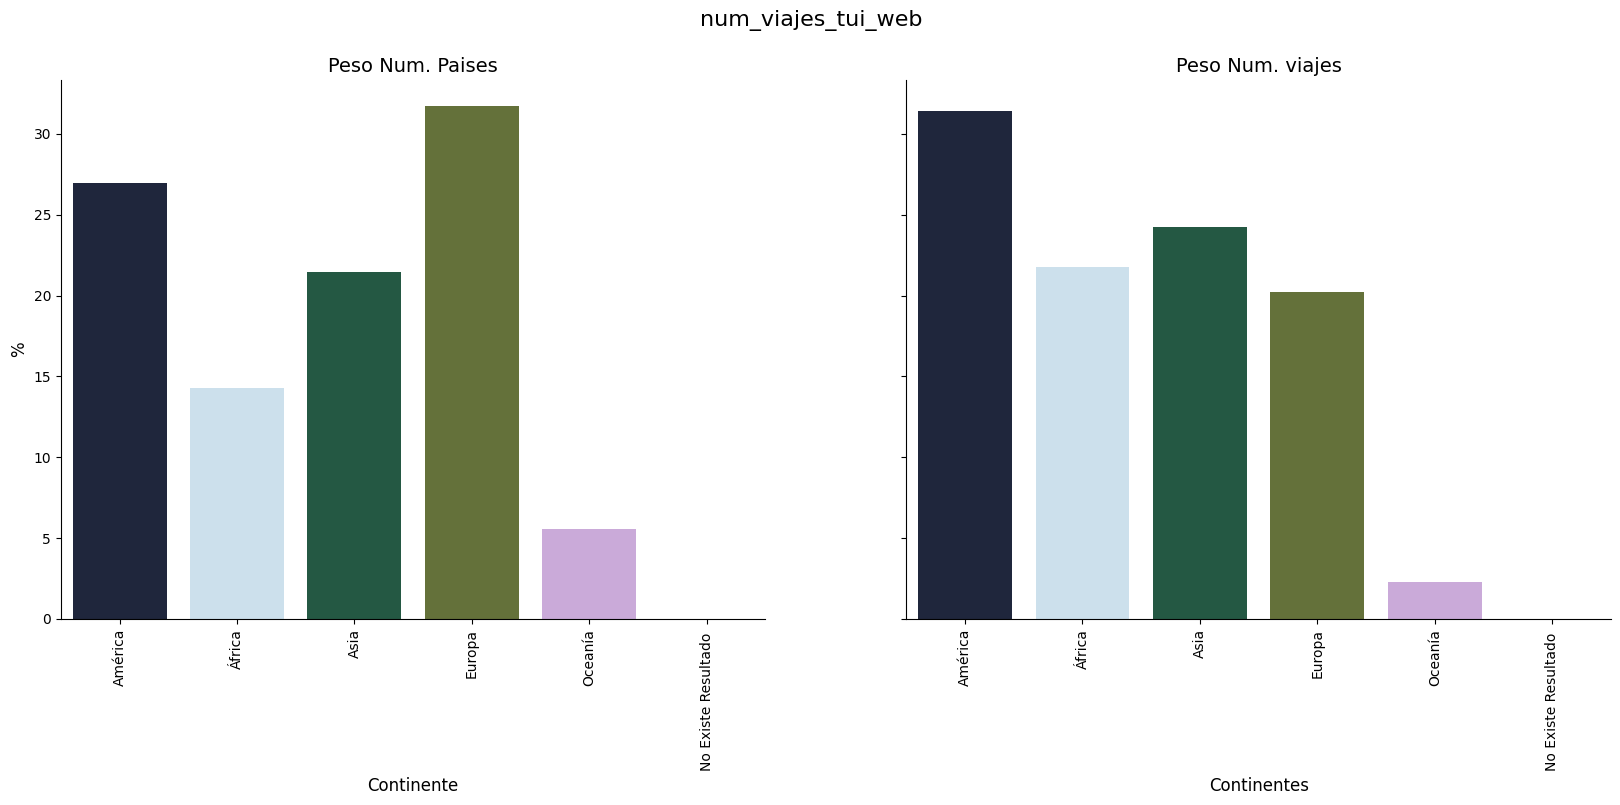

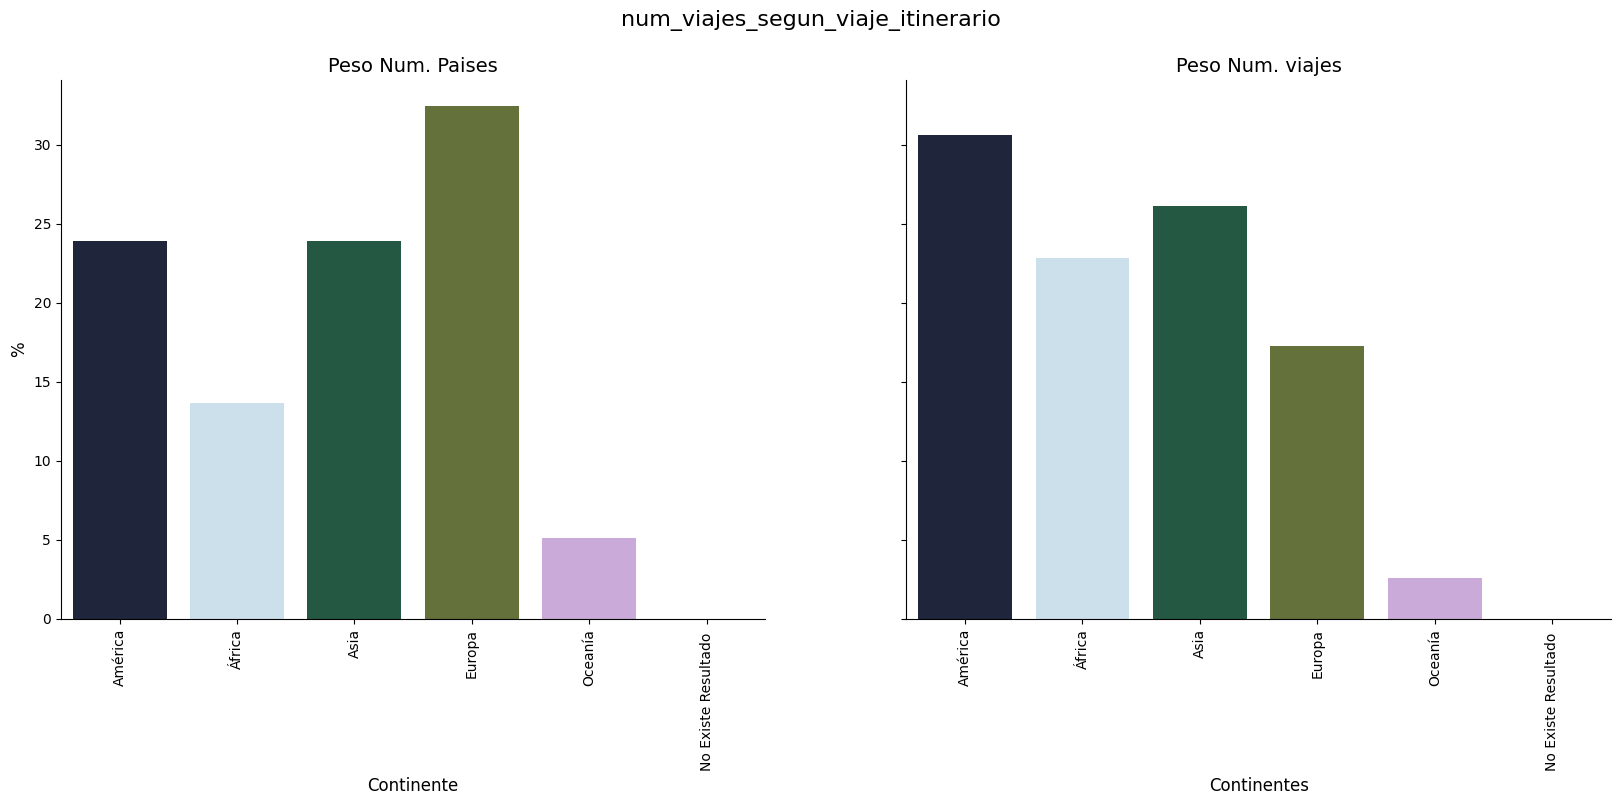

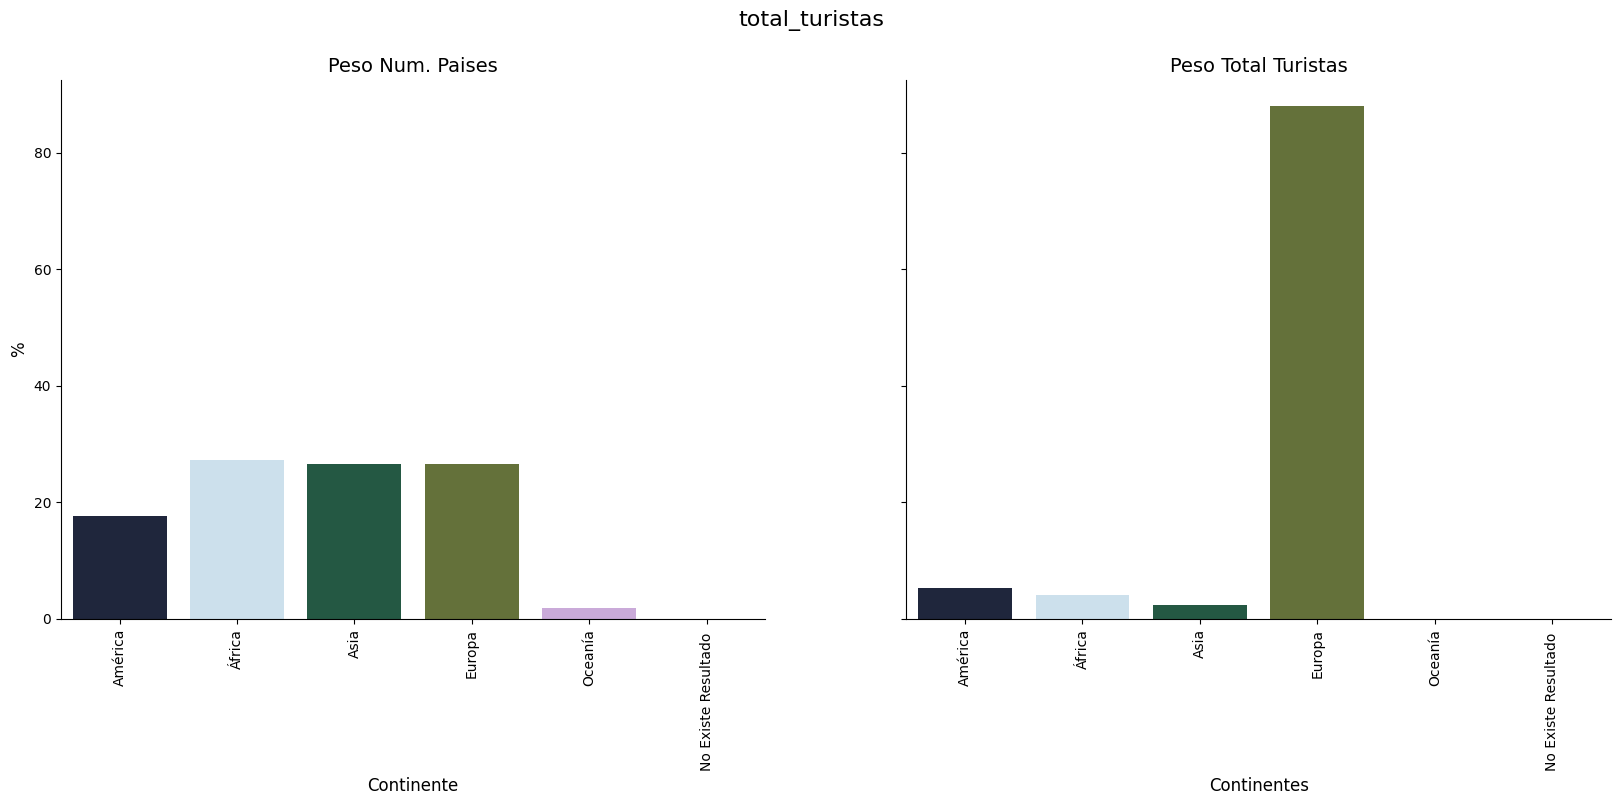

In [670]:
for columna in df_paises_con_viajes_y_turismo.columns.tolist()[3:6]:

    df_agrupado_continente_pais_recuentos= df_paises_con_viajes_y_turismo.groupby(['nombre_continente'])[columna].agg(["mean", "sum", "count"]).reset_index()
    df_agrupado_continente_pais_recuentos['Peso_paises']=round(df_agrupado_continente_pais_recuentos.iloc[:,3]/df_agrupado_continente_pais_recuentos.iloc[:,3].sum()*100,2)
    df_agrupado_continente_pais_recuentos['Peso_total_viajes']=round(df_agrupado_continente_pais_recuentos.iloc[:,2]/df_agrupado_continente_pais_recuentos.iloc[:,2].sum()*100,2)
    df_agrupado_continente_pais_recuentos 

    orden_continentes = ['América', 'África', 'Asia', 'Europa', 'Oceanía', 'No Existe Resultado ']
    fig, axes = plt.subplots(1, 2, sharex= False, sharey=True, figsize= (20,7))
    fig.suptitle(columna, fontsize=16)


    sns.barplot(data=df_agrupado_continente_pais_recuentos, x='nombre_continente', y= 'Peso_paises',hue='nombre_continente', palette ='cubehelix',ax=axes[0], order= orden_continentes)
    axes[0].tick_params(axis='x', rotation=90, labelsize=10)
    axes[0].set_ylabel('%', fontsize = 12)
    axes[0].set_xlabel('Continente', fontsize = 12)
    axes[0].set_title('Peso Num. Paises', fontsize = 14)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)

    if columna == 'total_turistas':
        sns.barplot(data=df_agrupado_continente_pais_recuentos, x='nombre_continente', y= 'Peso_total_viajes',hue='nombre_continente', palette ='cubehelix',ax=axes[1], order= orden_continentes)
        axes[1].tick_params(axis='x', rotation=90, labelsize=10)
        axes[1].set_ylabel('%', fontsize = 12)
        axes[1].set_xlabel('Continentes', fontsize = 12)
        axes[1].set_title('Peso Total Turistas', fontsize = 14)
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)

    else:
        sns.barplot(data=df_agrupado_continente_pais_recuentos, x='nombre_continente', y= 'Peso_total_viajes',hue='nombre_continente', palette ='cubehelix',ax=axes[1], order= orden_continentes)
        axes[1].tick_params(axis='x', rotation=90, labelsize=10)
        axes[1].set_ylabel('%', fontsize = 12)
        axes[1].set_xlabel('Continentes', fontsize = 12)
        axes[1].set_title('Peso Num. viajes', fontsize = 14)
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)

- En estos gráficos se observa como los TUI, a pesar de que en donde más paises está presente es en Europa, en cuanto al número de viajes ofertados, Europa es el 4º.
- No existe diferencia significativa entre el reparto de los viajes según los paises en los que TUI informa en su web y los paises según la localización de la ciudad.
- Finalmente, se observa como, en relación al turismo emisor, el número de paises de África, Asia y Europa que son visitamos son similares. No obstante, el número de turistas que visitan Europa es mucho más elevado, por lo que interesaría ofrecer más viajes en Europa.

## 2. ANALISIS VIAJES TUI Y TURISMO EMISOR GLOBAL AGRUPADO POR CONTINENTE Y DESGLOSANDOLO POR PAISES

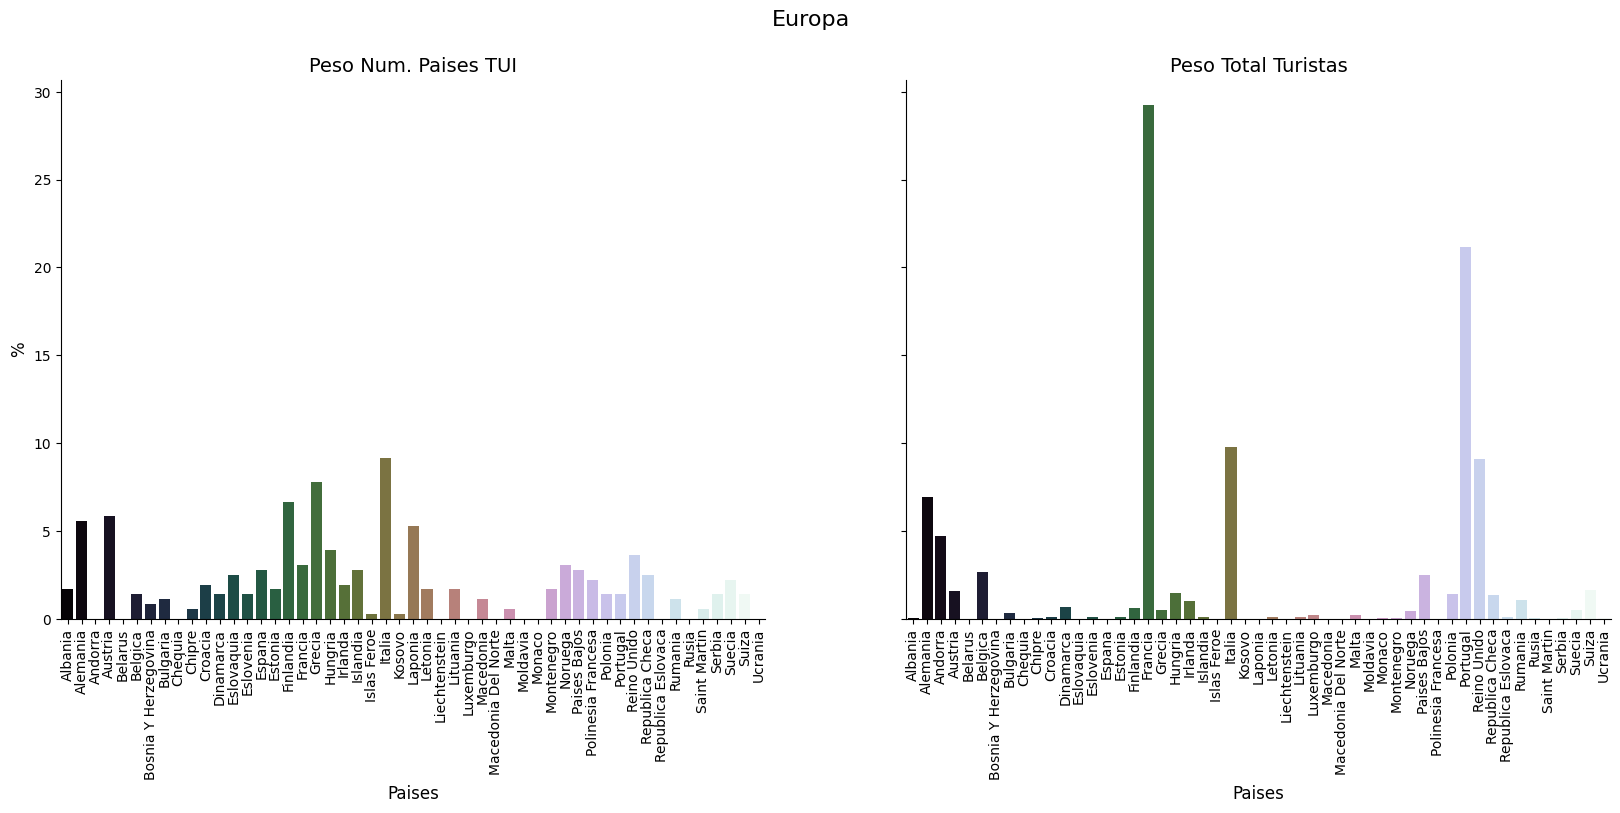

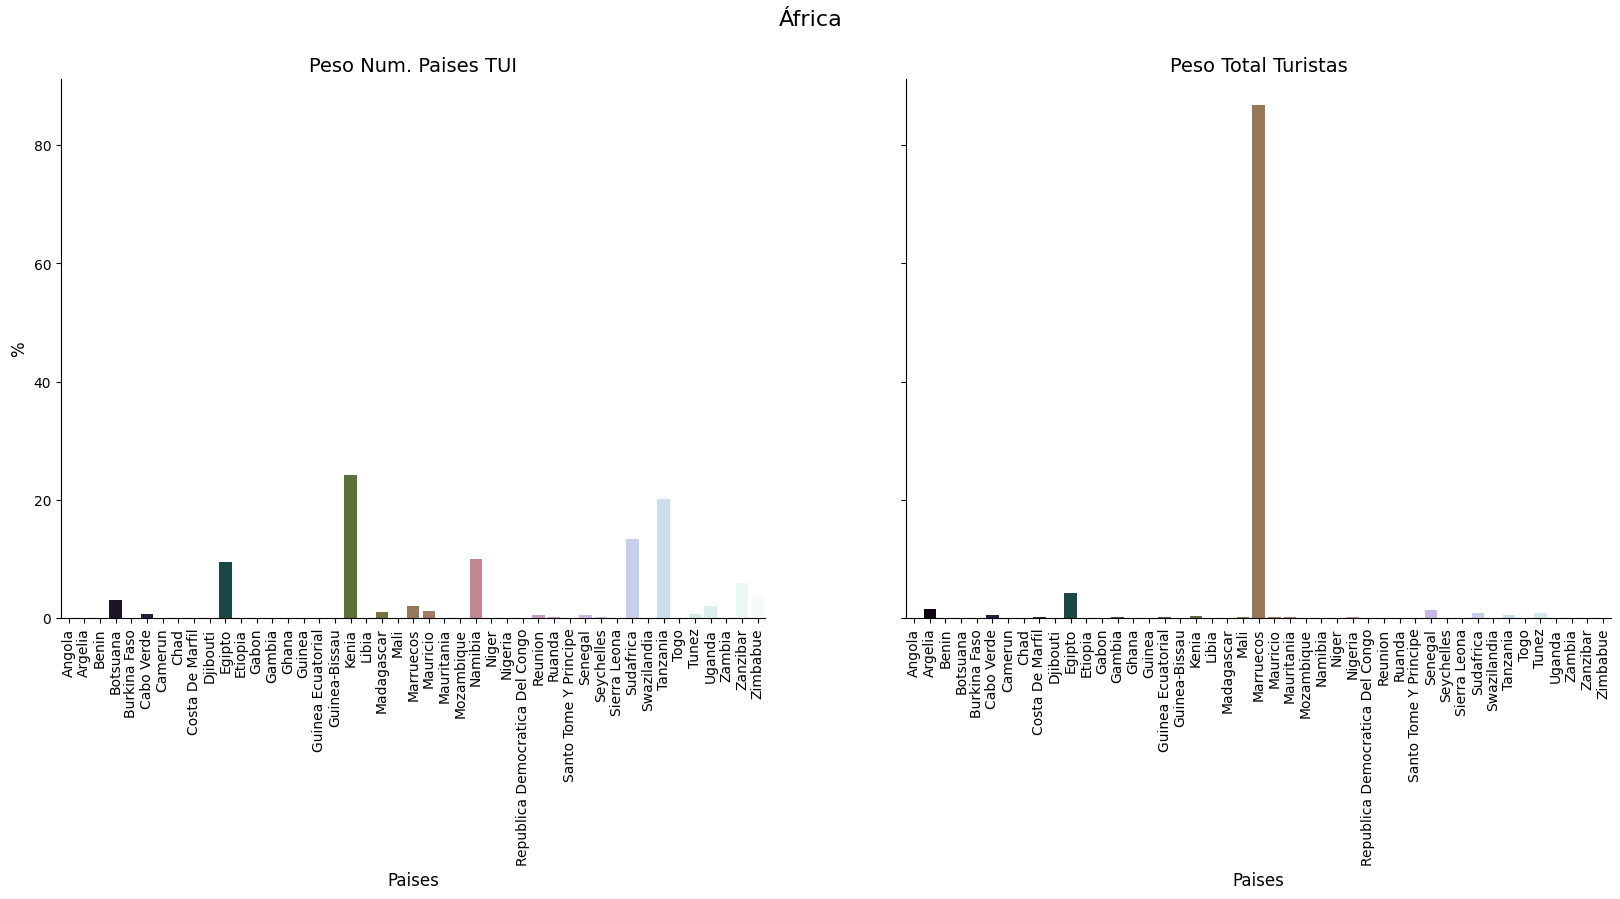

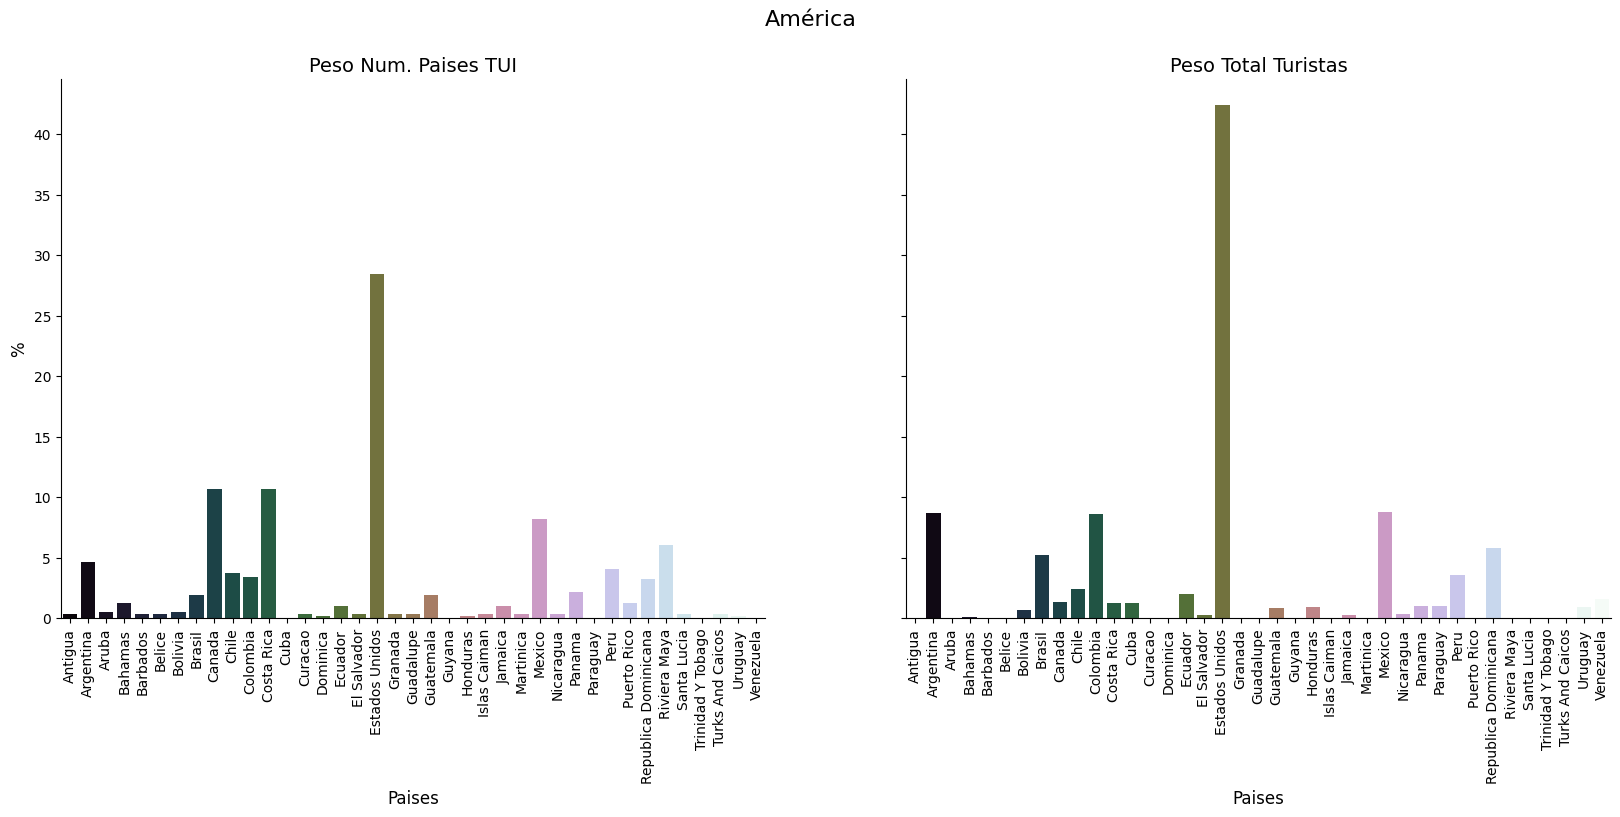

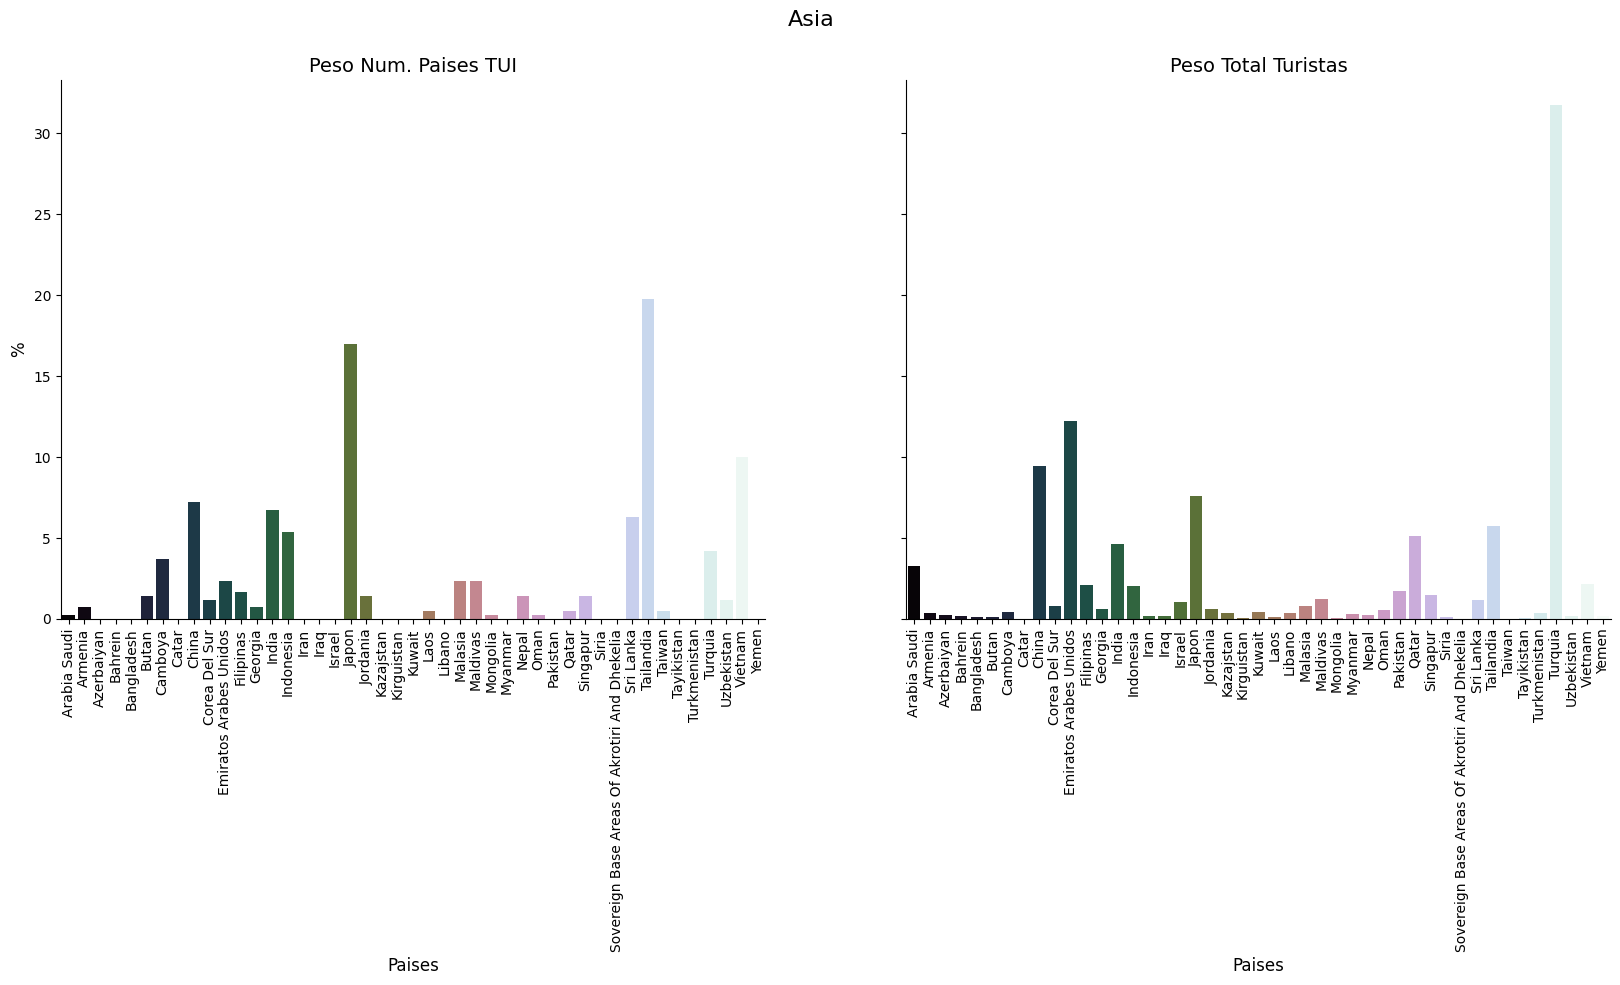

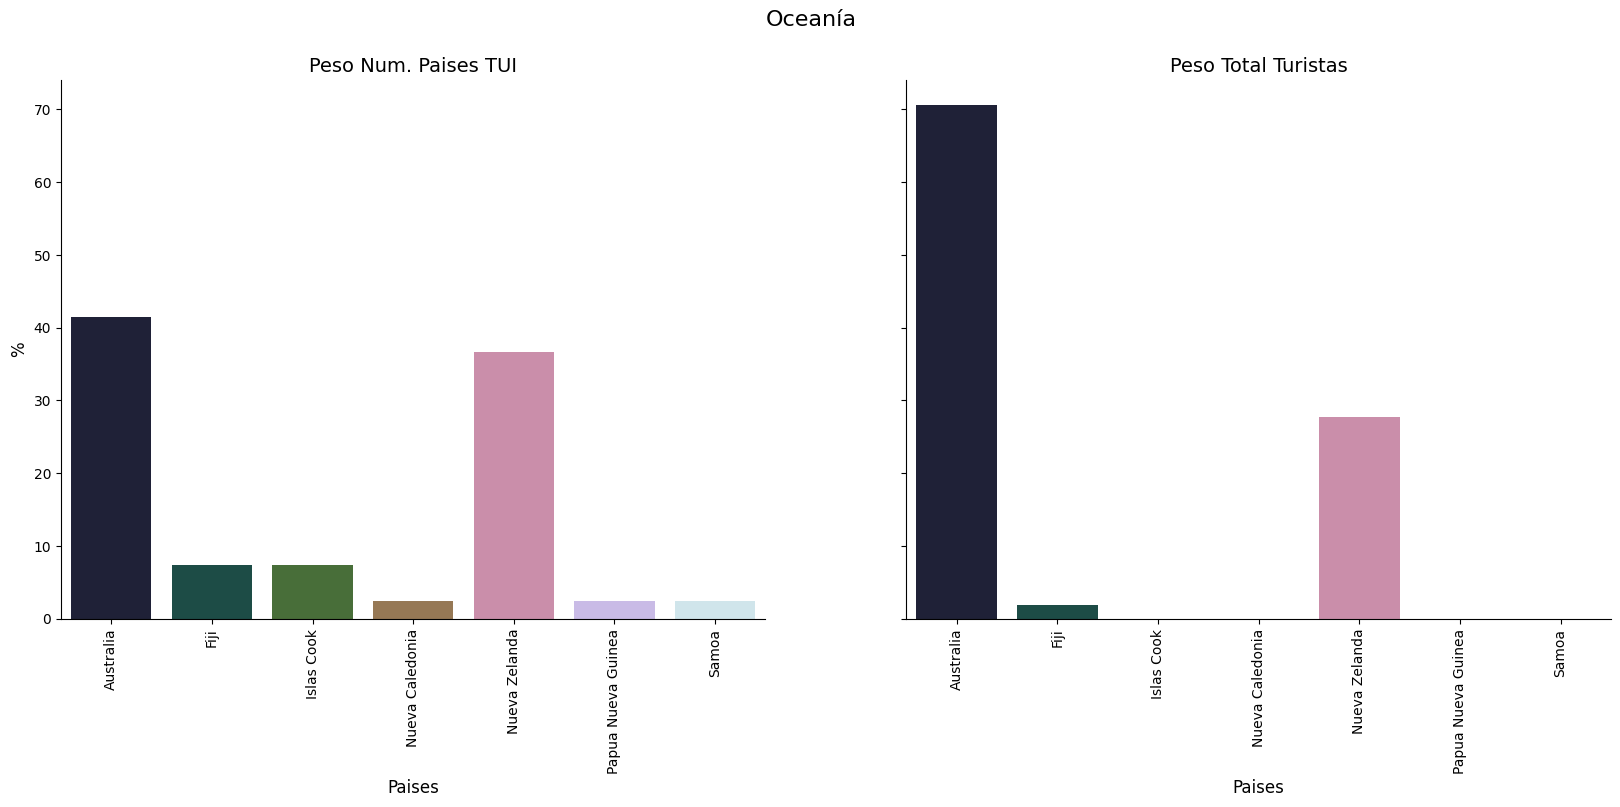

In [671]:
for continente in df_paises_con_viajes_y_turismo.nombre_continente.unique().tolist()[0:5]:
    df_filtrado_continente =df_paises_con_viajes_y_turismo[df_paises_con_viajes_y_turismo.nombre_continente == continente]
    df_filtrado_continente_pais_recuentos_turismo= df_filtrado_continente.groupby(['nombre_pais_destino'])['total_turistas'].agg(["sum"]).reset_index()
    df_filtrado_continente_pais_recuentos_turismo['Peso_total_turistas']=round(df_filtrado_continente_pais_recuentos_turismo.iloc[:,1]/df_filtrado_continente_pais_recuentos_turismo.iloc[:,1].sum()*100,2)
    df_filtrado_continente_pais_recuentos_tui= df_filtrado_continente.groupby(['nombre_pais_destino'])['num_viajes_tui_web'].agg(["sum"]).reset_index()
    df_filtrado_continente_pais_recuentos_tui['Peso_viajes_tui']=round(df_filtrado_continente_pais_recuentos_tui.iloc[:,1]/df_filtrado_continente_pais_recuentos_tui.iloc[:,1].sum()*100,2)

    fig, axes = plt.subplots(1, 2, sharex= False, sharey=True, figsize= (20,7))
    fig.suptitle(continente, fontsize=16)
    orden_paises = df_filtrado_continente_pais_recuentos_tui.nombre_pais_destino.unique().tolist()
    sns.barplot(data=df_filtrado_continente_pais_recuentos_turismo, x='nombre_pais_destino', y= 'Peso_total_turistas',hue='nombre_pais_destino', palette ='cubehelix',ax=axes[1], order= orden_paises)
    axes[1].tick_params(axis='x', rotation=90, labelsize=10)
    axes[1].set_ylabel('%', fontsize = 12)
    axes[1].set_xlabel('Paises', fontsize = 12)
    axes[1].set_title('Peso Total Turistas', fontsize = 14)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    sns.barplot(data=df_filtrado_continente_pais_recuentos_tui, x='nombre_pais_destino', y= 'Peso_viajes_tui',hue='nombre_pais_destino', palette ='cubehelix',ax=axes[0], order= orden_paises)
    axes[0].tick_params(axis='x', rotation=90, labelsize=10)
    axes[0].set_ylabel('%', fontsize = 12)
    axes[0].set_xlabel('Paises', fontsize = 12)
    axes[0].set_title('Peso Num. Paises TUI', fontsize = 14)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)


En estos gráficos podemos ver la distribución del número de viajes que ofrece TUI, según su página web, y el número de turistas españoles que demandan esos destinos. Se observa lo siguiente:
- Europa: La oferta de TUI no está alineada con la demanda del turismo español. El turismo español está realizado, sobre todo, viajes a Francia y Portutal, sin embargo, ni Francia ni Portugal aparecen en el top 5 de TUI.
- África: Marruecos es el pais más demandado por los españoles, con diferencia, sin embargo, la oferta de viajes de TUI para este pais es baja.
- América: en este Pais si parece estar más alineada la oferta de TUI con la demanda del turismo español. EEUU es el pais más demandado por los españoles y a la vez el que más variedad de viajes ofrece TUI.
- Asia: Turquia es el destino más demandado por lo españoles, sin embargo TUI ofrece más viajes en Tailandia y Japón y la oferta de viajes de Turquia es mucho menor.
- Oceanía: en Oceanía parece que la oferta de TUI está alineada con la demanda. Australia y Nueva Zelanda son los paises más demandados. En el resto de paises, excepto Fiji, la demanda es escasa por lo que quizás merezca la pena eliminar estos viajes y destinar recursos a los paises que más demandan los españoles en otros continentes.

## 3. ANALISIS PERNOCTACIONES TUI Y TURISMO EMISOR GLOBAL AGRUPADO POR CONTINENTE Y DESGLOSANDOLO POR PAISES

In [673]:
#extraigo de la BBDD la información de la tabla combinación_destino_viaje:
query_extraccion = '''SELECT *
                                                    FROM combinacion_destino_viaje''' 
lista_columnas = ['id_viaje', 'id_pais_destino']
df_combinacion_destino_viaje = exp.extraer_datos_bbdd_y_convertir_en_df(lista_columnas,query_extraccion)
df_combinacion_destino_viaje.head()

id_viaje  id_pais_destino
0         1                1
1         2                2
2         3                2
3         4                2
4         5                2

In [674]:
df_viajes_ciudad = df_viajes.copy()
df_viajes_ciudad ['id_pais_destino']=None

In [675]:
ex.incorporar_información_df_original(df_viajes_ciudad,df_combinacion_destino_viaje,'id_viaje','id_pais_destino','id_pais_destino' )

In [676]:
df_viajes_ciudad.head()

id_viaje                                          url_viaje  \
0         1      https://es.tui.com/viaje/albania-y-montenegro   
1         2  https://viajeonline.es.tui.com/es/idea/1463025...   
2         3  https://viajeonline.es.tui.com/es/idea/7897512...   
3         4  https://viajeonline.es.tui.com/es/idea/8404511...   
4         5  https://viajeonline.es.tui.com/es/idea/7906930...   

                                  nombre_viaje  duracion_dias  \
0                         Albania y Montenegro              8   
1                                       Berlín              4   
2  Fly & Drive Austria, Entre Lagos y Montañas              8   
3             Fly & Drive Carlomagno a su aire             10   
4                Fly & Drive Tirol al Completo              8   

   duracion_noches  id_itinerario  viaje_activo  id_pais_destino  
0                7         1027.0          True              119  
1                3          146.0          True                2  
2                7          872.0          True               12  
3                9          166.0          True               19  
4                7         1145.0          True               87

In [677]:
df_viajes_ciudad_agrupado_pais  = df_viajes_ciudad.groupby('id_pais_destino')[['duracion_noches']].mean().reset_index()

In [316]:
df_viajes_ciudad_agrupado_pais

id_pais_destino  duracion_noches
0                  1         7.000000
1                  2         6.200000
2                  5         7.000000
3                  6         7.000000
4                  8        10.882353
..               ...              ...
113              181         7.000000
114              182         6.600000
115              184        11.186047
116              187         8.347826
117              188        11.600000

[118 rows x 2 columns]

In [678]:
df_paises_con_viajes_y_turismo['promedio_pernoctaciones_viajes_tui']=None

In [679]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

   num_viajes_segun_viaje_itinerario  total_turistas  total_pernoctaciones  \
0                                6.0          1410.0                5359.0   
1                               19.0        179330.0              976543.0   
2                                NaN        120980.0              273540.0   
3                                NaN            96.0                 714.0   
4                                NaN            38.0                 344.0   

  promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                               None                                3.800709   
1                               None                                5.445508   
2                               None                                2.261035   
3                               None                                7.437500   
4                               None                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

In [680]:
ex.incorporar_información_df_original(df_paises_con_viajes_y_turismo,df_viajes_ciudad_agrupado_pais,'id_pais_destino','duracion_noches','promedio_pernoctaciones_viajes_tui')

In [681]:
df_paises_con_viajes_y_turismo['promedio_pernoctaciones_turismo_emisor']=df_paises_con_viajes_y_turismo.total_pernoctaciones/df_paises_con_viajes_y_turismo.total_turistas

In [683]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

   num_viajes_segun_viaje_itinerario  total_turistas  total_pernoctaciones  \
0                                6.0          1410.0                5359.0   
1                               19.0        179330.0              976543.0   
2                                NaN        120980.0              273540.0   
3                                NaN            96.0                 714.0   
4                                NaN            38.0                 344.0   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                3.800709   
1                                 6.2                                5.445508   
2                                 NaN                                2.261035   
3                                 NaN                                7.437500   
4                                 7.0                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

In [684]:
df_analisis_pernoctaciones = df_paises_con_viajes_y_turismo[['id_pais_destino', 'nombre_pais_destino','nombre_continente','promedio_pernoctaciones_viajes_tui','promedio_pernoctaciones_turismo_emisor' ]]

In [685]:
df_analisis_pernoctaciones['promedio_pernoctaciones_viajes_tui'] = df_analisis_pernoctaciones['promedio_pernoctaciones_viajes_tui'].apply(
        lambda x: int(x) if pd.notnull(x) else x)

C:\Users\van-2\AppData\Local\Temp\ipykernel_29216\3276155511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_pernoctaciones['promedio_pernoctaciones_viajes_tui'] = df_analisis_pernoctaciones['promedio_pernoctaciones_viajes_tui'].apply(


In [686]:
df_analisis_pernoctaciones['promedio_pernoctaciones_turismo_emisor'] = df_analisis_pernoctaciones['promedio_pernoctaciones_turismo_emisor'].apply(
        lambda x: int(x) if pd.notnull(x) else x)

C:\Users\van-2\AppData\Local\Temp\ipykernel_29216\499971724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_pernoctaciones['promedio_pernoctaciones_turismo_emisor'] = df_analisis_pernoctaciones['promedio_pernoctaciones_turismo_emisor'].apply(


In [688]:
df_analisis_pernoctaciones.head()

id_pais_destino nombre_pais_destino nombre_continente  \
0                1             Albania            Europa   
1                2            Alemania            Europa   
2                3             Andorra            Europa   
3                4              Angola            África   
4                5             Antigua           América   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  
0                                 7.0                                     3.0  
1                                 6.0                                     5.0  
2                                 NaN                                     2.0  
3                                 NaN                                     7.0  
4                                 7.0                                     9.0

In [689]:
df_analisis_pernoctaciones['diferencia_pernoctaciones_tui_emisor'] = df_analisis_pernoctaciones.promedio_pernoctaciones_viajes_tui-df_analisis_pernoctaciones.promedio_pernoctaciones_turismo_emisor

C:\Users\van-2\AppData\Local\Temp\ipykernel_29216\269449668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_pernoctaciones['diferencia_pernoctaciones_tui_emisor'] = df_analisis_pernoctaciones.promedio_pernoctaciones_viajes_tui-df_analisis_pernoctaciones.promedio_pernoctaciones_turismo_emisor


In [690]:
df_analisis_pernoctaciones.head()

id_pais_destino nombre_pais_destino nombre_continente  \
0                1             Albania            Europa   
1                2            Alemania            Europa   
2                3             Andorra            Europa   
3                4              Angola            África   
4                5             Antigua           América   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                     3.0   
1                                 6.0                                     5.0   
2                                 NaN                                     2.0   
3                                 NaN                                     7.0   
4                                 7.0                                     9.0   

   diferencia_pernoctaciones_tui_emisor  
0                                   4.0  
1                                   1.0  
2                                   NaN  
3                                   NaN  
4                                  -2.0

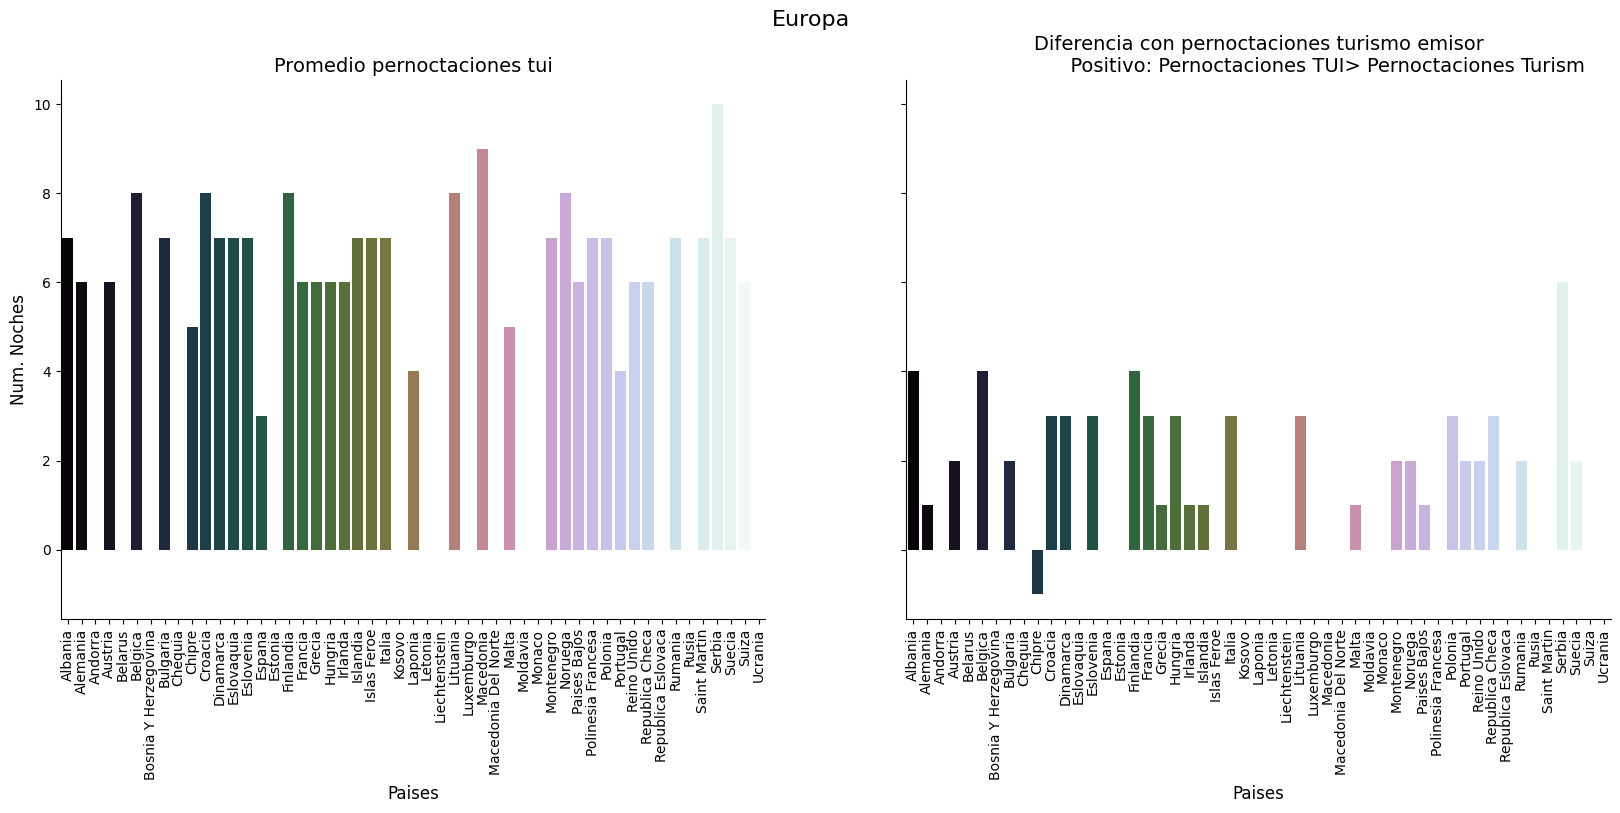

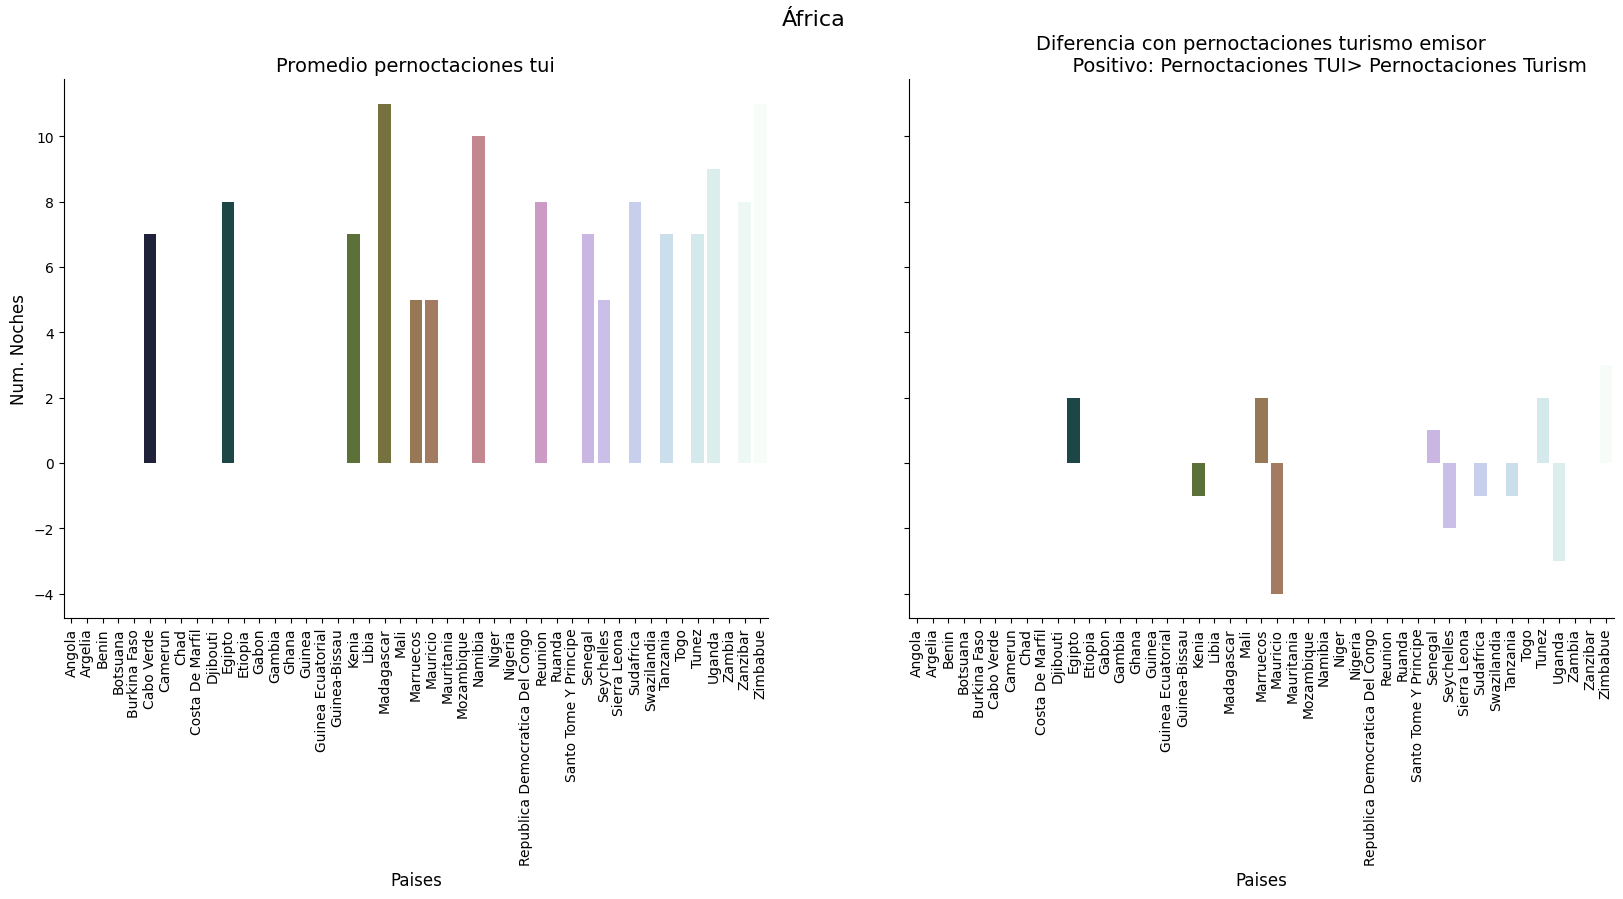

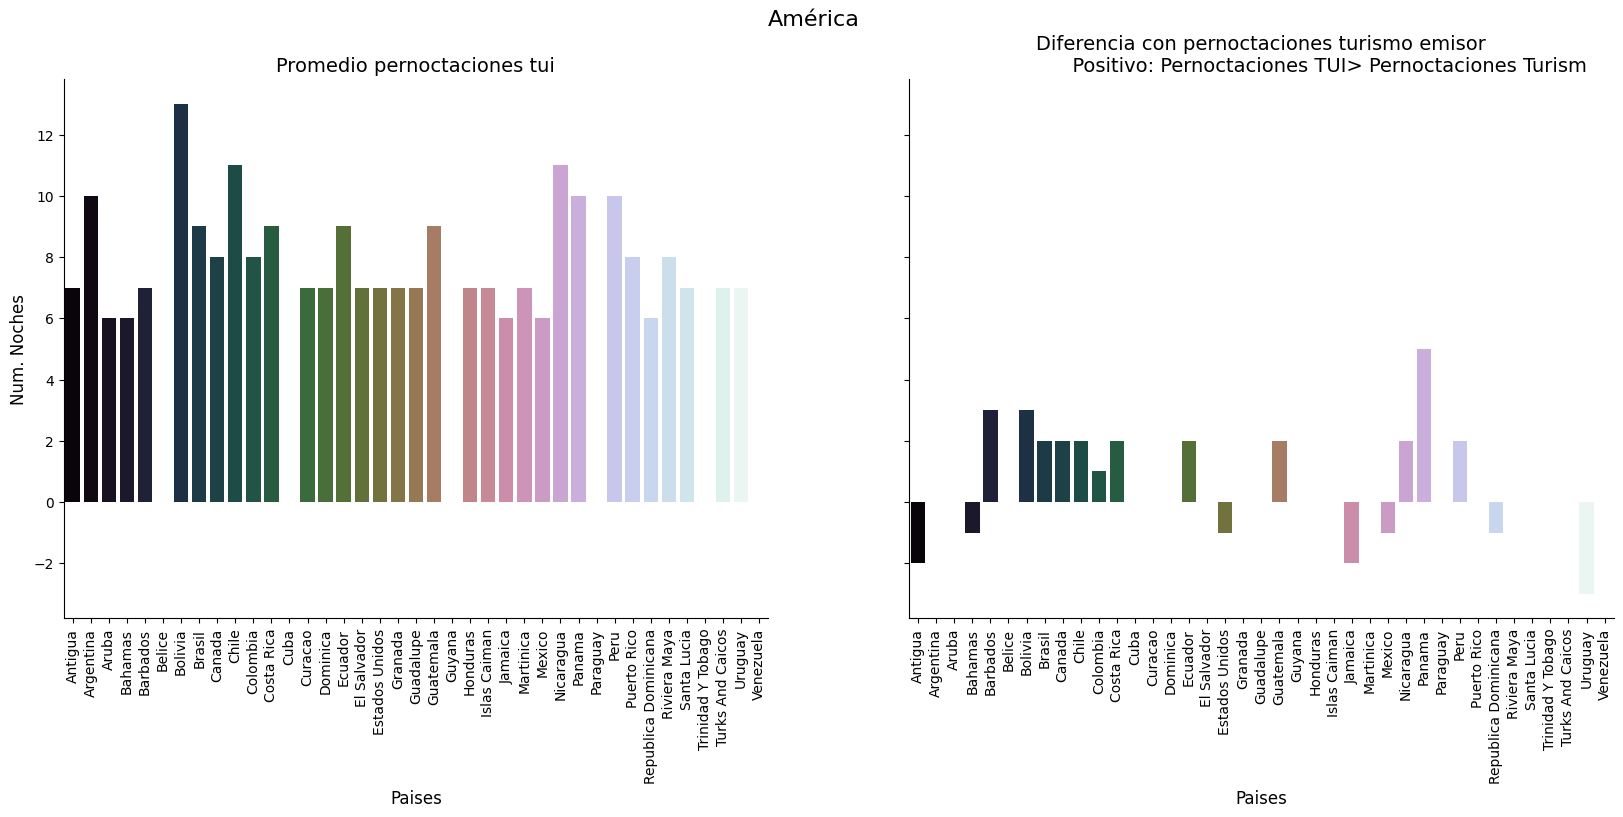

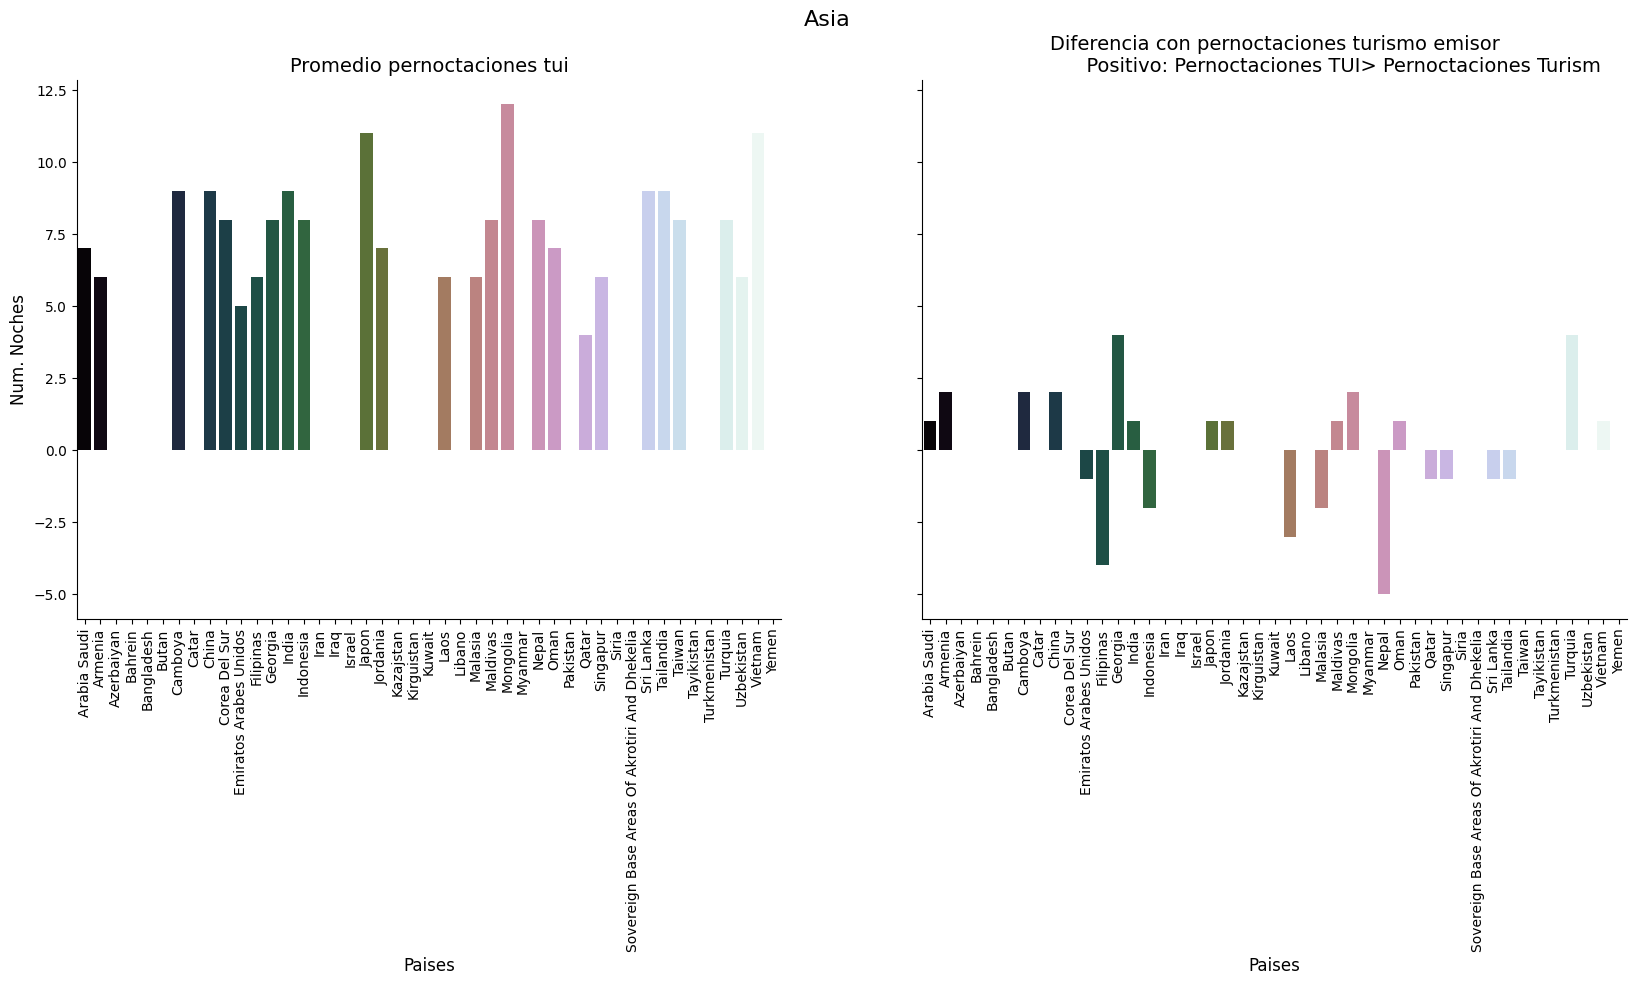

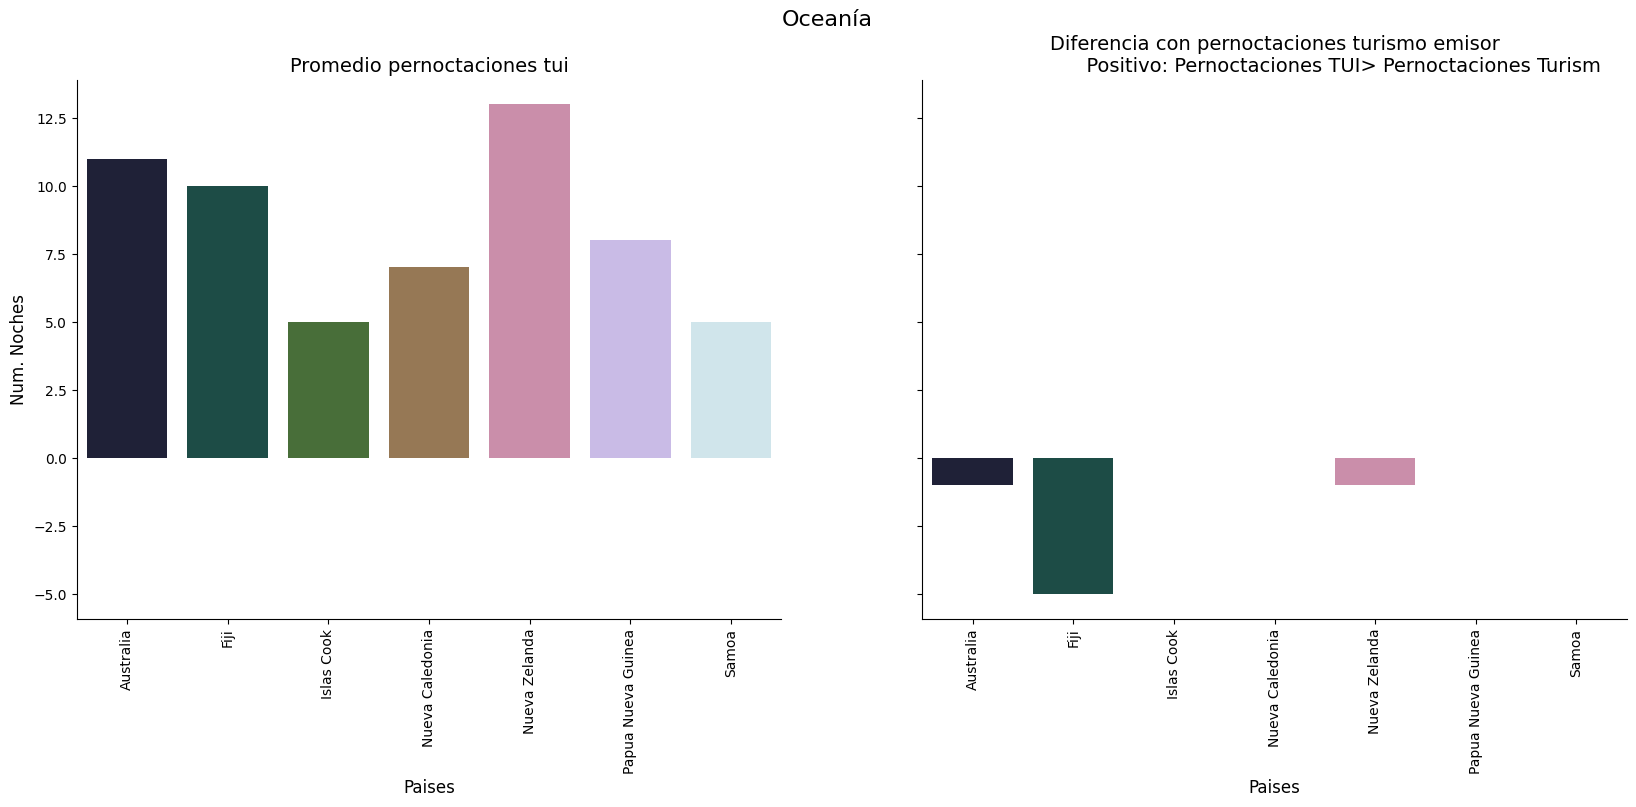

In [691]:
for continente in df_analisis_pernoctaciones.nombre_continente.unique().tolist()[0:5]:
    df_filtrado_continente_pernoctaciones =df_analisis_pernoctaciones[df_analisis_pernoctaciones.nombre_continente == continente]

    fig, axes = plt.subplots(1, 2, sharex= False, sharey=True, figsize= (20,7))
    fig.suptitle(continente, fontsize=16)
    orden_paises = df_filtrado_continente_pernoctaciones.nombre_pais_destino.unique().tolist()
    sns.barplot(data=df_filtrado_continente_pernoctaciones, x='nombre_pais_destino', y= 'diferencia_pernoctaciones_tui_emisor',hue='nombre_pais_destino', palette ='cubehelix',ax=axes[1], order= orden_paises)
    axes[1].tick_params(axis='x', rotation=90, labelsize=10)
    axes[1].set_ylabel('Num. Noches', fontsize = 12)
    axes[1].set_xlabel('Paises', fontsize = 12)
    axes[1].set_title('''Diferencia con pernoctaciones turismo emisor
                      Positivo: Pernoctaciones TUI> Pernoctaciones Turism''', fontsize = 14)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    sns.barplot(data=df_filtrado_continente_pernoctaciones, x='nombre_pais_destino', y= 'promedio_pernoctaciones_viajes_tui',hue='nombre_pais_destino', palette ='cubehelix',ax=axes[0], order= orden_paises)
    axes[0].tick_params(axis='x', rotation=90, labelsize=10)
    axes[0].set_ylabel('Num. Noches', fontsize = 12)
    axes[0].set_xlabel('Paises', fontsize = 12)
    axes[0].set_title('Promedio pernoctaciones tui', fontsize = 14)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)

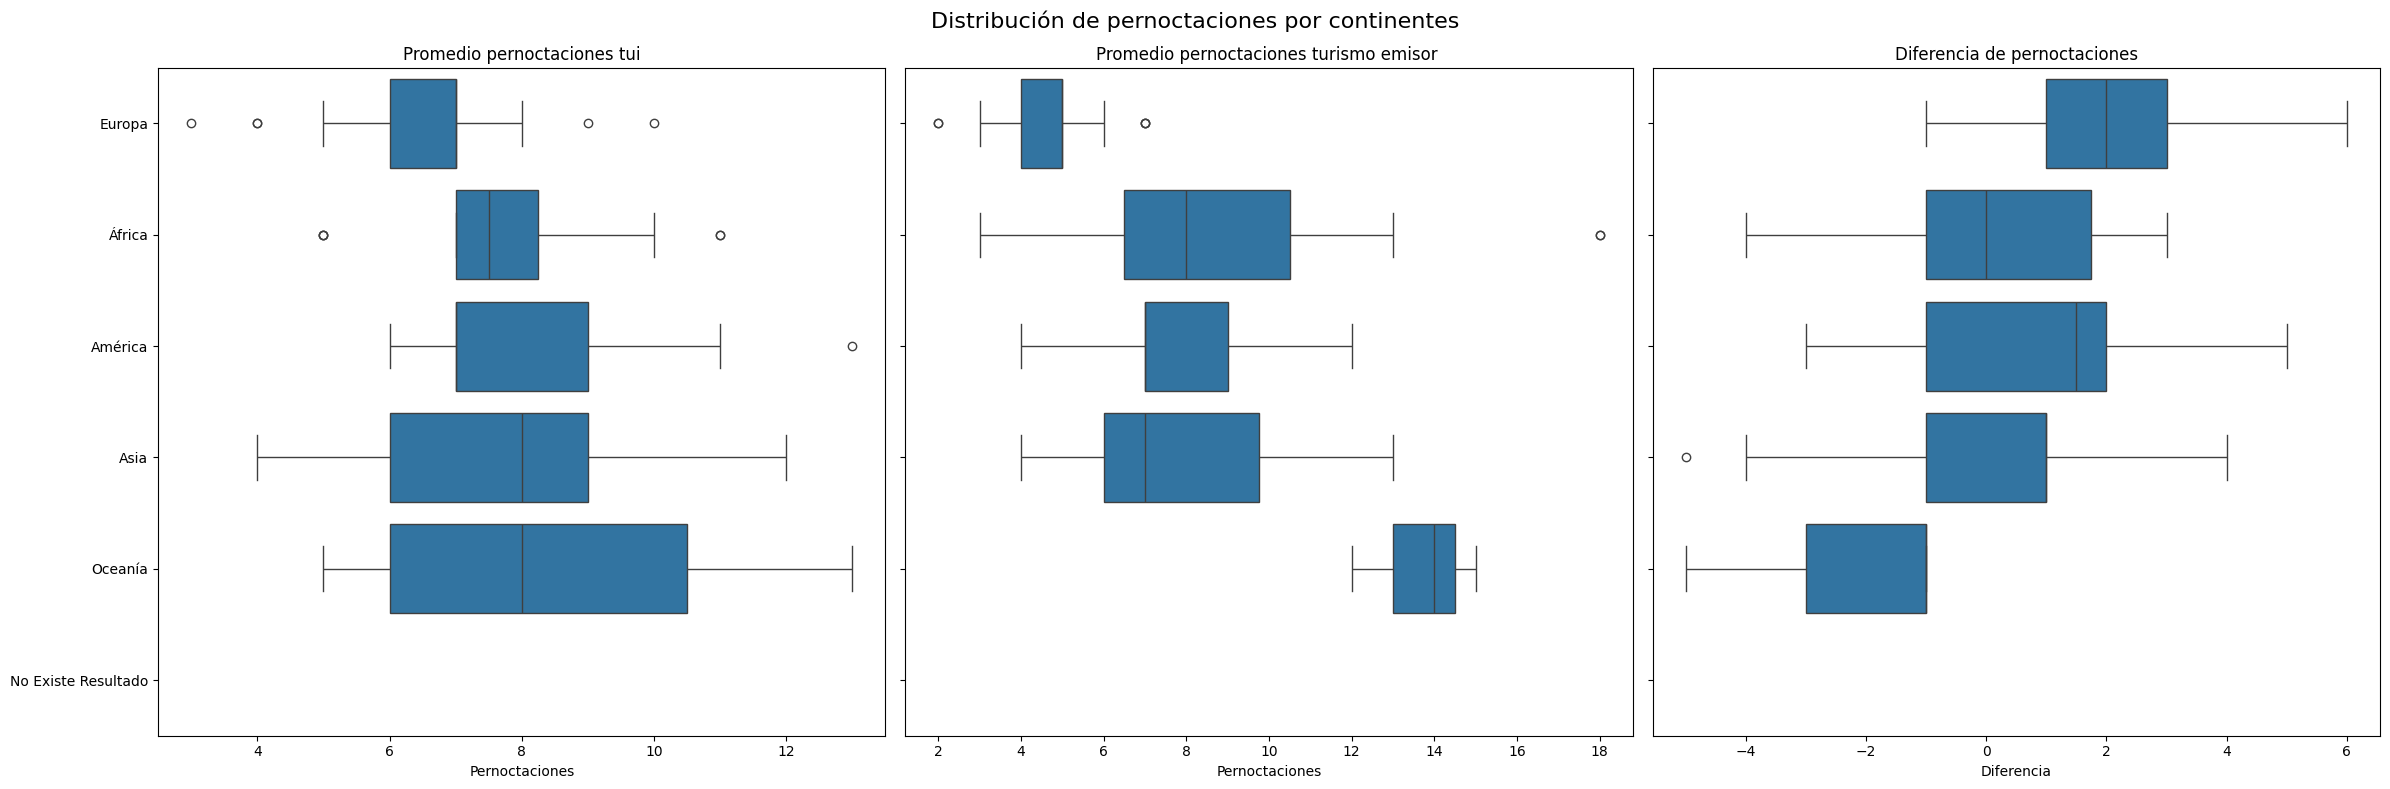

In [692]:
# Creamos una figura con 3 subgráficos (uno por boxplot)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), sharey=True)

# Primer boxplot: diferencia de pernoctaciones
sns.boxplot(
    ax=axes[2],
    y='nombre_continente',
    x='diferencia_pernoctaciones_tui_emisor',
    data=df_analisis_pernoctaciones
)
axes[2].set_title('Diferencia de pernoctaciones')
axes[2].set_xlabel('Diferencia')
axes[2].set_ylabel('Continente')

# Segundo boxplot: promedio_pernoctaciones_viajes_tui
sns.boxplot(
    ax=axes[0],
    y='nombre_continente',
    x='promedio_pernoctaciones_viajes_tui',
    data=df_analisis_pernoctaciones
)
axes[0].set_title('Promedio pernoctaciones tui')
axes[0].set_xlabel('Pernoctaciones')
axes[0].set_ylabel('')  # Ya está en el primero

# Tercer boxplot: diferencia de precios (ejemplo)
sns.boxplot(
    ax=axes[1],
    y='nombre_continente',
    x='promedio_pernoctaciones_turismo_emisor',
    data=df_analisis_pernoctaciones
)
axes[1].set_title('Promedio pernoctaciones turismo emisor ')
axes[1].set_xlabel('Pernoctaciones')
axes[1].set_ylabel('')

plt.suptitle('Distribución de pernoctaciones por continentes', fontsize=16)
plt.tight_layout()
plt.show()

Se observa como en los viajes ofrecidos por TUI el rango de pernoctaciones es mayor que los demandados en el turismo emisor, excepto en África. En la mayoría de paises TUI ofrece más pernoctaciones que lo que el turismo español demanda, excepto en Oceanía.

## 4. Análisis de los paises que están presentes en TUI y el turismo emisor

In [693]:
lista_paises_tui = df_viajes_localizacion_pag_web.id_pais_destino.unique().tolist()
lista_paises_turismo_emisor = df_turismo_emisor.id_pais_destino.unique().tolist()

In [694]:
len(lista_paises_tui)

126

In [695]:
len(lista_paises_turismo_emisor)

158

In [696]:
df_paises_con_viajes_y_turismo[['tui_en_turismo_emisor', 'turismo_emisor_en_tui']]=None

In [697]:
for indice,row in df_paises_con_viajes_y_turismo.iterrows():
    if row['id_pais_destino'] in lista_paises_tui:
        if row['id_pais_destino'] in lista_paises_turismo_emisor:
            df_paises_con_viajes_y_turismo.loc[indice,'tui_en_turismo_emisor']='Si'
            df_paises_con_viajes_y_turismo.loc[indice,'turismo_emisor_en_tui']='Si'
        else:
            df_paises_con_viajes_y_turismo.loc[indice,'tui_en_turismo_emisor']='No'

In [698]:
for indice,row in df_paises_con_viajes_y_turismo.iterrows():
    if row['id_pais_destino'] in lista_paises_turismo_emisor:
        if row['id_pais_destino'] in lista_paises_tui:
            df_paises_con_viajes_y_turismo.loc[indice,'tui_en_turismo_emisor']='Si'
            df_paises_con_viajes_y_turismo.loc[indice,'turismo_emisor_en_tui']='Si'
        else:
            df_paises_con_viajes_y_turismo.loc[indice,'turismo_emisor_en_tui']='No'

In [701]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

   num_viajes_segun_viaje_itinerario  total_turistas  total_pernoctaciones  \
0                                6.0          1410.0                5359.0   
1                               19.0        179330.0              976543.0   
2                                NaN        120980.0              273540.0   
3                                NaN            96.0                 714.0   
4                                NaN            38.0                 344.0   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                3.800709   
1                                 6.2                                5.445508   
2                                 NaN                                2.261035   
3                                 NaN                                7.437500   
4                                 7.0                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

In [700]:
df_paises_con_viajes_y_turismo.tui_en_turismo_emisor.value_counts()

tui_en_turismo_emisor
Si    100
No     26
Name: count, dtype: int64

In [702]:
df_paises_con_viajes_y_turismo.turismo_emisor_en_tui.value_counts()

turismo_emisor_en_tui
Si    100
No     58
Name: count, dtype: int64

In [703]:
df_agrupado_turismoemisor_no_en_tui = df_paises_con_viajes_y_turismo.groupby('turismo_emisor_en_tui')['total_turistas'].agg(["sum", 'count'])

In [704]:
df_agrupado_turismoemisor_no_en_tui

sum  count
turismo_emisor_en_tui                  
No                      148478.0     58
Si                     2783062.0    100

In [705]:
df_agrupado_turismoemisor_no_en_tui['Peso_total_turistas'] = round(
    df_agrupado_turismoemisor_no_en_tui['sum'] / 
    df_agrupado_turismoemisor_no_en_tui['sum'].sum() * 100, 2
)

df_agrupado_turismoemisor_no_en_tui['Peso_paises'] = round(
    df_agrupado_turismoemisor_no_en_tui['count'] / 
    df_agrupado_turismoemisor_no_en_tui['count'].sum() * 100, 2
)

In [706]:
df_agrupado_turismoemisor_no_en_tui = df_agrupado_turismoemisor_no_en_tui.reset_index()

In [710]:
df_paises_con_viajes_y_turismo.head()

id_pais_destino nombre_pais_destino nombre_continente  num_viajes_tui_web  \
0                1             Albania            Europa                 6.0   
1                2            Alemania            Europa                20.0   
2                3             Andorra            Europa                 NaN   
3                4              Angola            África                 NaN   
4                5             Antigua           América                 2.0   

   num_viajes_segun_viaje_itinerario  total_turistas  total_pernoctaciones  \
0                                6.0          1410.0                5359.0   
1                               19.0        179330.0              976543.0   
2                                NaN        120980.0              273540.0   
3                                NaN            96.0                 714.0   
4                                NaN            38.0                 344.0   

   promedio_pernoctaciones_viajes_tui  promedio_pernoctaciones_turismo_emisor  \
0                                 7.0                                3.800709   
1                                 6.2                                5.445508   
2                                 NaN                                2.261035   
3                                 NaN                                7.437500   
4                                 7.0                                9.052632   

  tui_en_turismo_emisor turismo_emisor_en_tui  
0                    Si                    Si  
1                    Si                    Si  
2                  None                    No  
3                  None                    No  
4                    Si                    Si

In [711]:
df_agrupado_tui_en_turismo_emisor = df_paises_con_viajes_y_turismo.groupby('tui_en_turismo_emisor')['num_viajes_tui_web'].agg(["sum", 'count'])

In [712]:
df_agrupado_tui_en_turismo_emisor

sum  count
tui_en_turismo_emisor               
No                      146.0     26
Si                     1632.0    100

In [713]:
df_agrupado_tui_en_turismo_emisor['Peso_total_viajes'] = round(
    df_agrupado_tui_en_turismo_emisor['sum'] / 
    df_agrupado_tui_en_turismo_emisor['sum'].sum() * 100, 2
)

df_agrupado_tui_en_turismo_emisor['Peso_paises'] = round(
    df_agrupado_tui_en_turismo_emisor['count'] / 
    df_agrupado_tui_en_turismo_emisor['count'].sum() * 100, 2
)

In [714]:
df_agrupado_tui_en_turismo_emisor= df_agrupado_tui_en_turismo_emisor.reset_index()

In [715]:
df_agrupado_tui_en_turismo_emisor

tui_en_turismo_emisor     sum  count  Peso_total_viajes  Peso_paises
0                    No   146.0     26               8.21        20.63
1                    Si  1632.0    100              91.79        79.37

Text(0.5, 1.0, 'Peso paises en Turismo Emisor presente en paises de TUI')

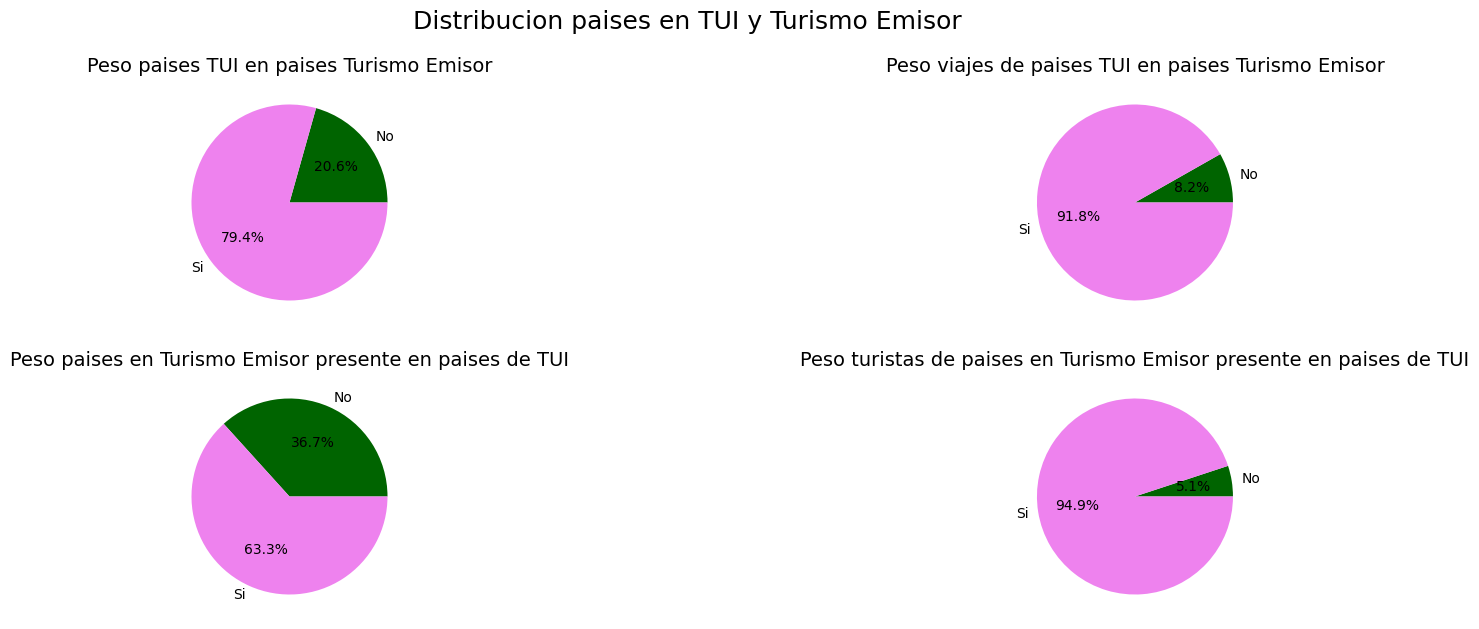

In [716]:
fig, axes = plt.subplots(2, 2, sharex= True, sharey=False, figsize= (20,7))
fig.suptitle('Distribucion paises en TUI y Turismo Emisor', fontsize=18)

axes[0,1].pie("Peso_total_viajes", labels='tui_en_turismo_emisor', autopct='%1.1f%%', data=df_agrupado_tui_en_turismo_emisor, colors=['darkgreen','violet'])
plt.xticks(rotation=90, fontsize=10)
axes[0,1].set_title('Peso viajes de paises TUI en paises Turismo Emisor', fontsize = 14)

axes[0,0].pie("Peso_paises", labels='tui_en_turismo_emisor', autopct='%1.1f%%', data=df_agrupado_tui_en_turismo_emisor, colors=['darkgreen','violet'])
plt.xticks(rotation=90, fontsize=10)
axes[0,0].set_title('Peso paises TUI en paises Turismo Emisor', fontsize = 14)

axes[1,1].pie("Peso_total_turistas", labels='turismo_emisor_en_tui', autopct='%1.1f%%', data=df_agrupado_turismoemisor_no_en_tui, colors=['darkgreen','violet'])
plt.xticks(rotation=90, fontsize=10)
axes[1,1].set_title('Peso turistas de paises en Turismo Emisor presente en paises de TUI', fontsize = 14)

axes[1,0].pie("Peso_paises", labels='turismo_emisor_en_tui', autopct='%1.1f%%', data=df_agrupado_turismoemisor_no_en_tui, colors=['darkgreen','violet'])
plt.xticks(rotation=90, fontsize=10)
axes[1,0].set_title('Peso paises en Turismo Emisor presente en paises de TUI', fontsize = 14)

En este gráfico se observa lo siguiente: 
- El 37% de los paises a los que viajan los turistas españoles no están en los paises donde TUI ofrece viajes. No obstante, en relación al número de turistas totales solo representa el 5%.
- El 20% de los paises donde TUI ofrece viajes no son demandados por el turismo emisor, no obstante, solo representa el 8 de viajes total ofertados por TUI.

## 5. Análisis temporal de la evolución del turismo emisor

In [717]:
df_turismo_emisor.head()

id_pais_destino nombre_pais_destino nombre_continente ccaa_origen  \
0                8           Argentina           América   Andalucía   
1               22             Bolivia           América   Andalucía   
2               25              Brasil           América   Andalucía   
3               32              Canada           América   Andalucía   
4               36               Chile           América   Andalucía   

   num_turistas  num_pernoctaciones   ano  mes  
0           419                3616  2019    7  
1            61                 486  2019    7  
2           277                2214  2019    7  
3           483                6159  2019    7  
4           242                2068  2019    7

In [718]:
df_turismo_emisor_agrupado_pais = df_turismo_emisor.groupby(
    ['nombre_pais_destino', 'nombre_continente', 'ano', 'mes'],
    as_index=False
)[['num_turistas', 'num_pernoctaciones']].agg('sum')

In [721]:
df_turismo_emisor_agrupado_pais.head()

nombre_pais_destino nombre_continente   ano  mes  num_turistas  \
0             Albania            Europa  2019    7          1353   
1             Albania            Europa  2019    8          3126   
2             Albania            Europa  2019    9          1730   
3             Albania            Europa  2019   10           861   
4             Albania            Europa  2019   11           382   

   num_pernoctaciones  
0               11386  
1               32578  
2               15240  
3                5844  
4                1923

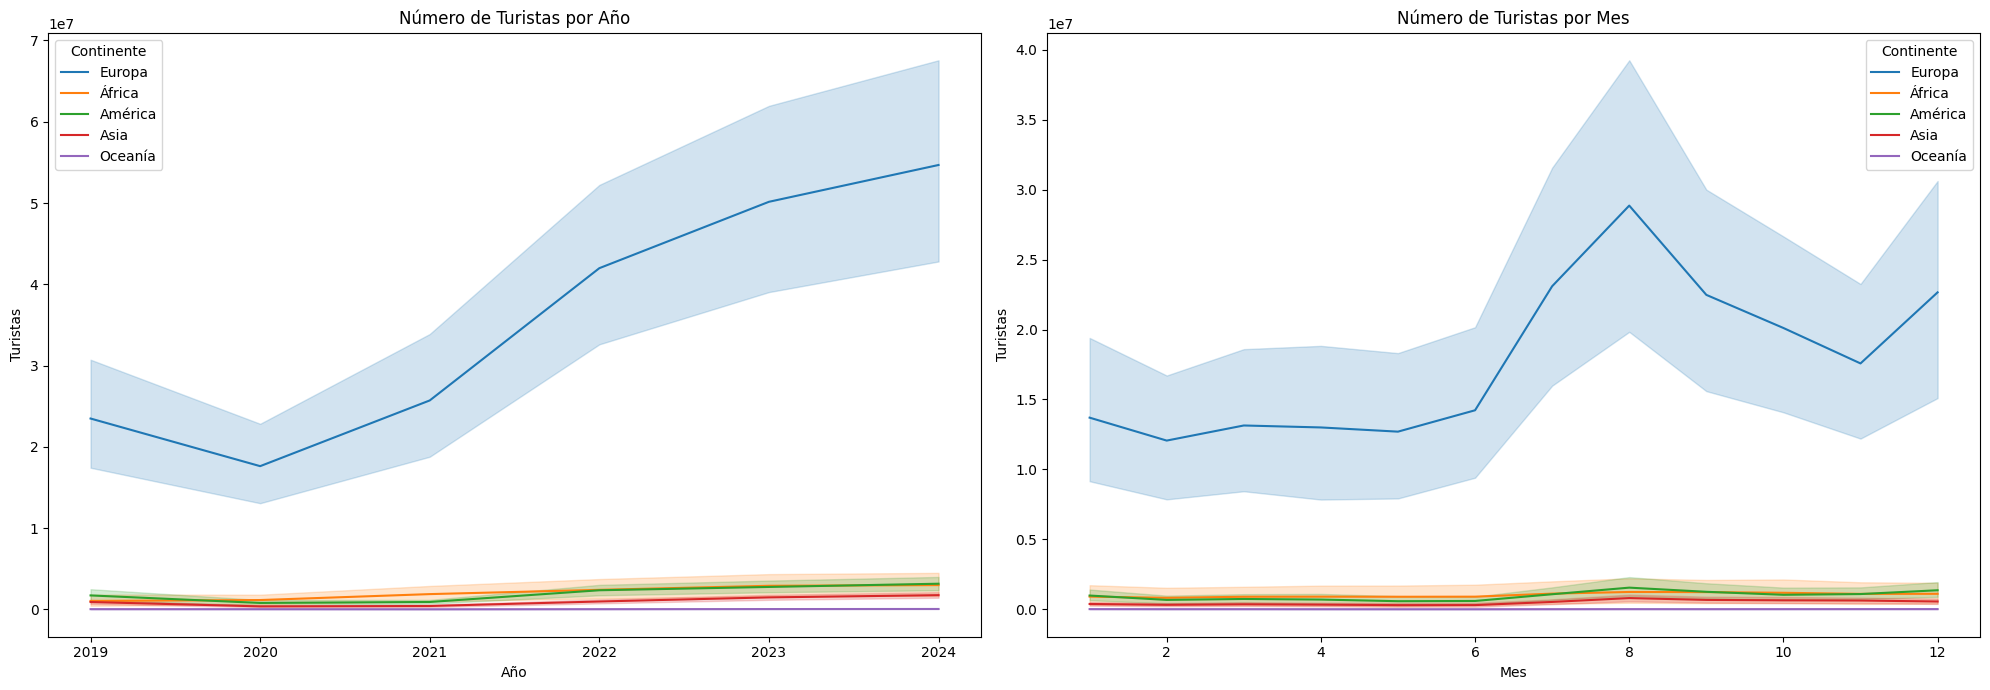

In [720]:
# Crear figura y ejes
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 columnas, 1 fila

# Primer gráfico: num_turistas por año
sns.lineplot(
    x='ano',
    y='num_turistas',
    data=df_turismo_emisor_agrupado_pais,
    hue='nombre_continente',
    markers=True,
    estimator='sum',
    errorbar=('ci', 95),
    err_style='band',
    ax=axes[0]
)
axes[0].set_title('Número de Turistas por Año')
axes[0].legend(title='Continente')
axes[0].set_ylabel('Turistas')
axes[0].set_xlabel('Año')


# Segundo gráfico: num_turistas por mes 
sns.lineplot(
    x='mes',
    y='num_turistas',
    data=df_turismo_emisor_agrupado_pais,
    hue='nombre_continente',
    markers=True,
    estimator='sum',
    errorbar=('ci', 95),
    err_style='band',
    ax=axes[1]
)
axes[1].set_title('Número de Turistas por Mes')
axes[1].legend(title='Continente')
axes[1].set_ylabel('Turistas')
axes[1].set_xlabel('Mes')

# Ajustar diseño para que no se solapen
plt.tight_layout()
plt.show()

### 5.1 Análisis desglosado por continentes:

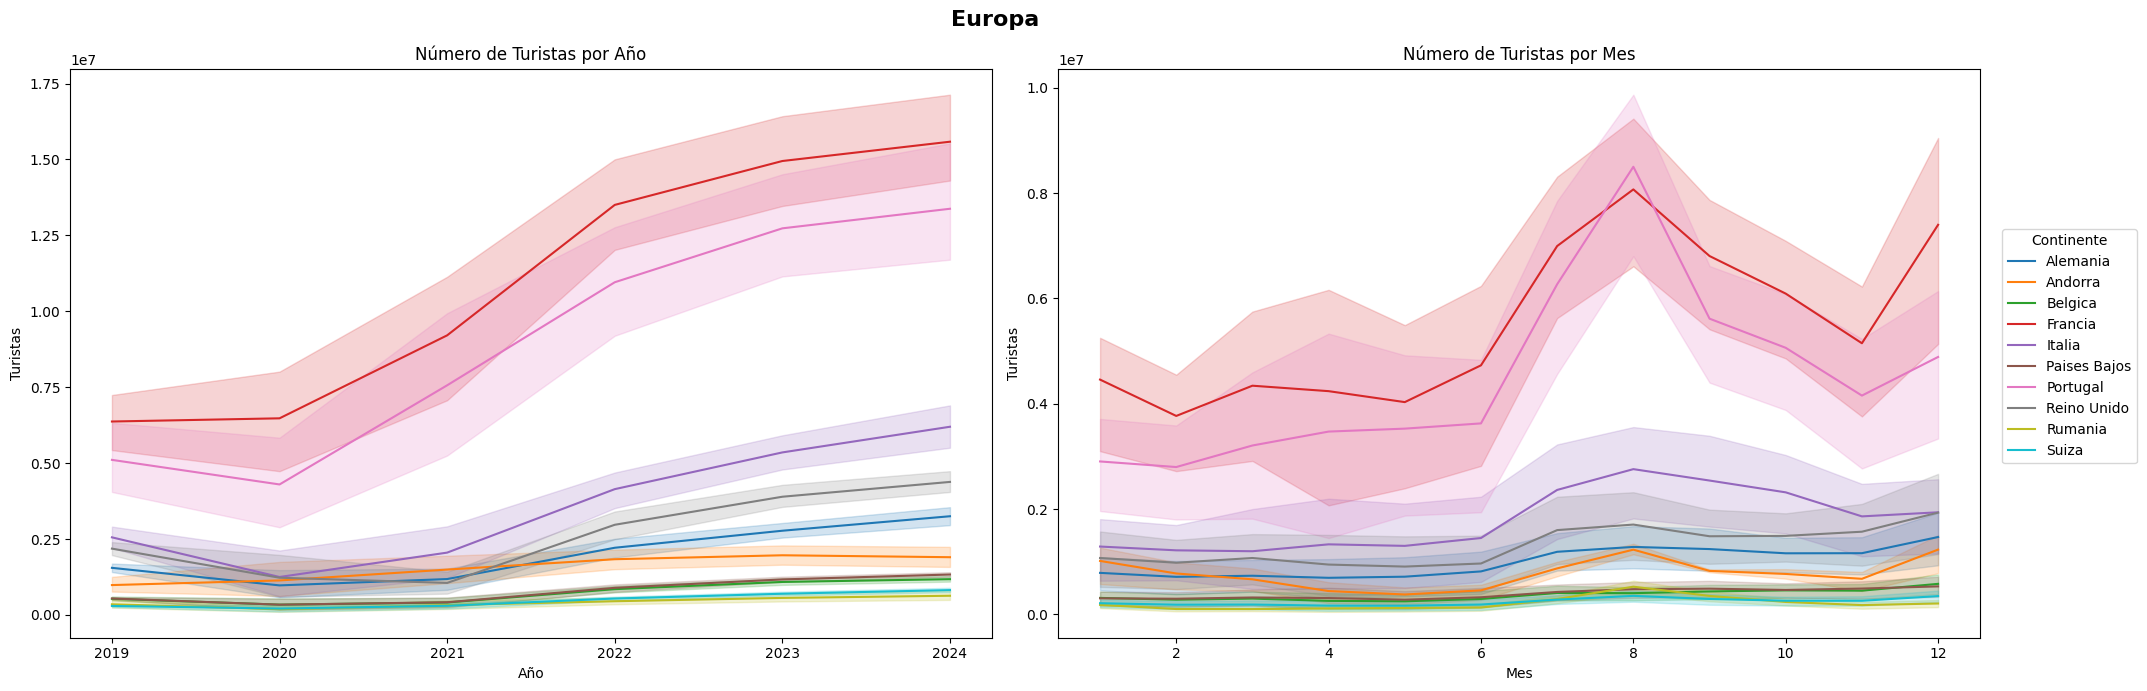

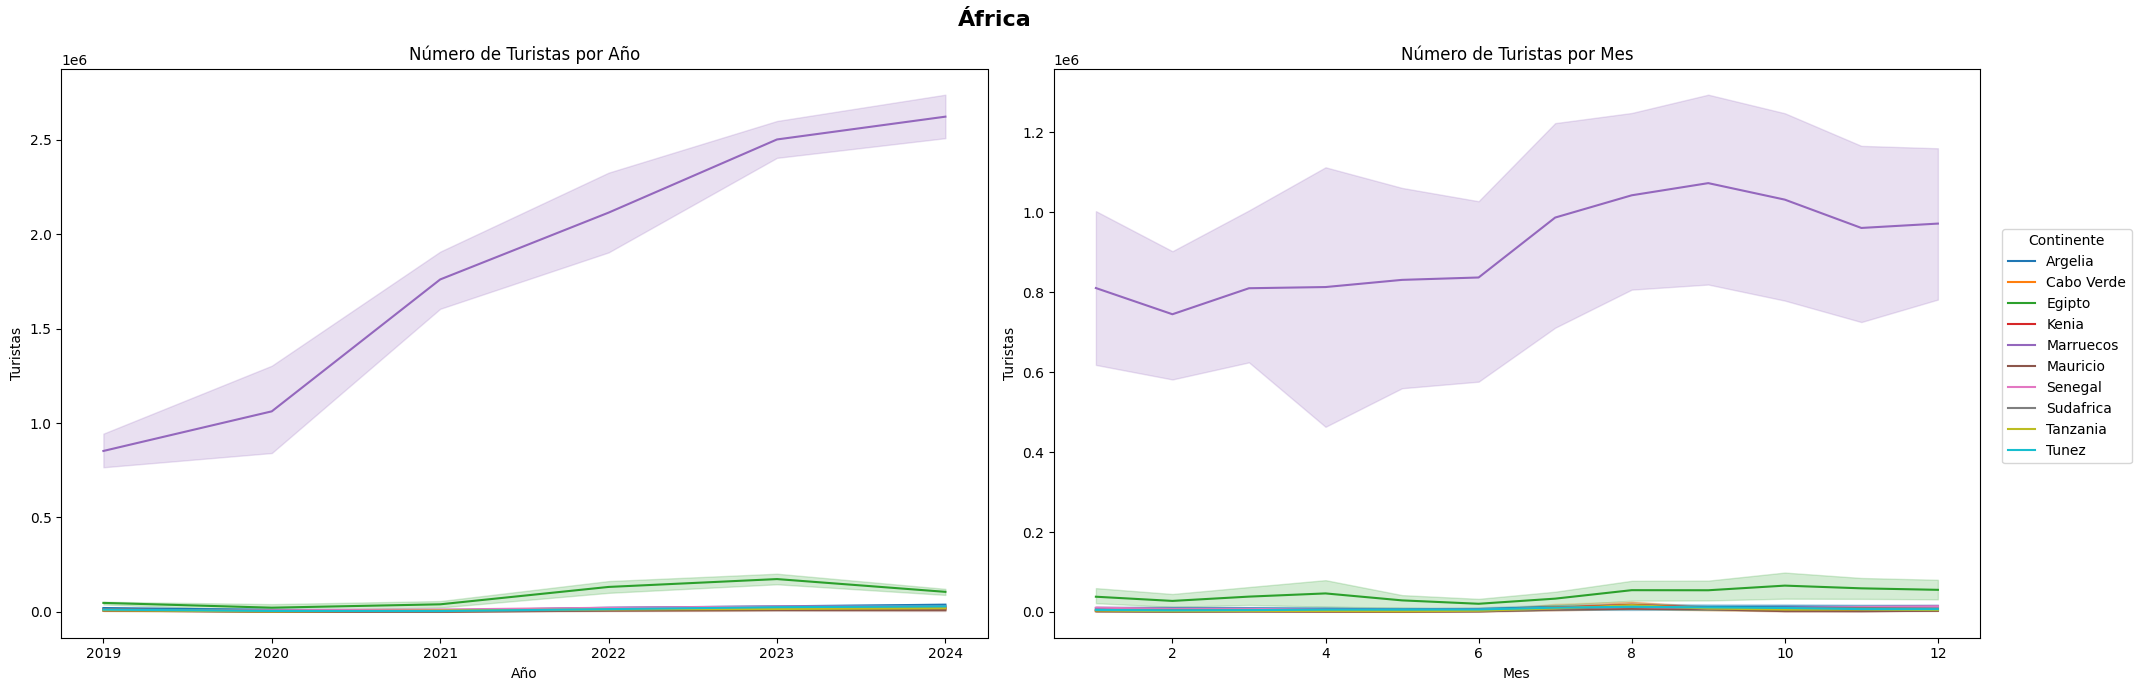

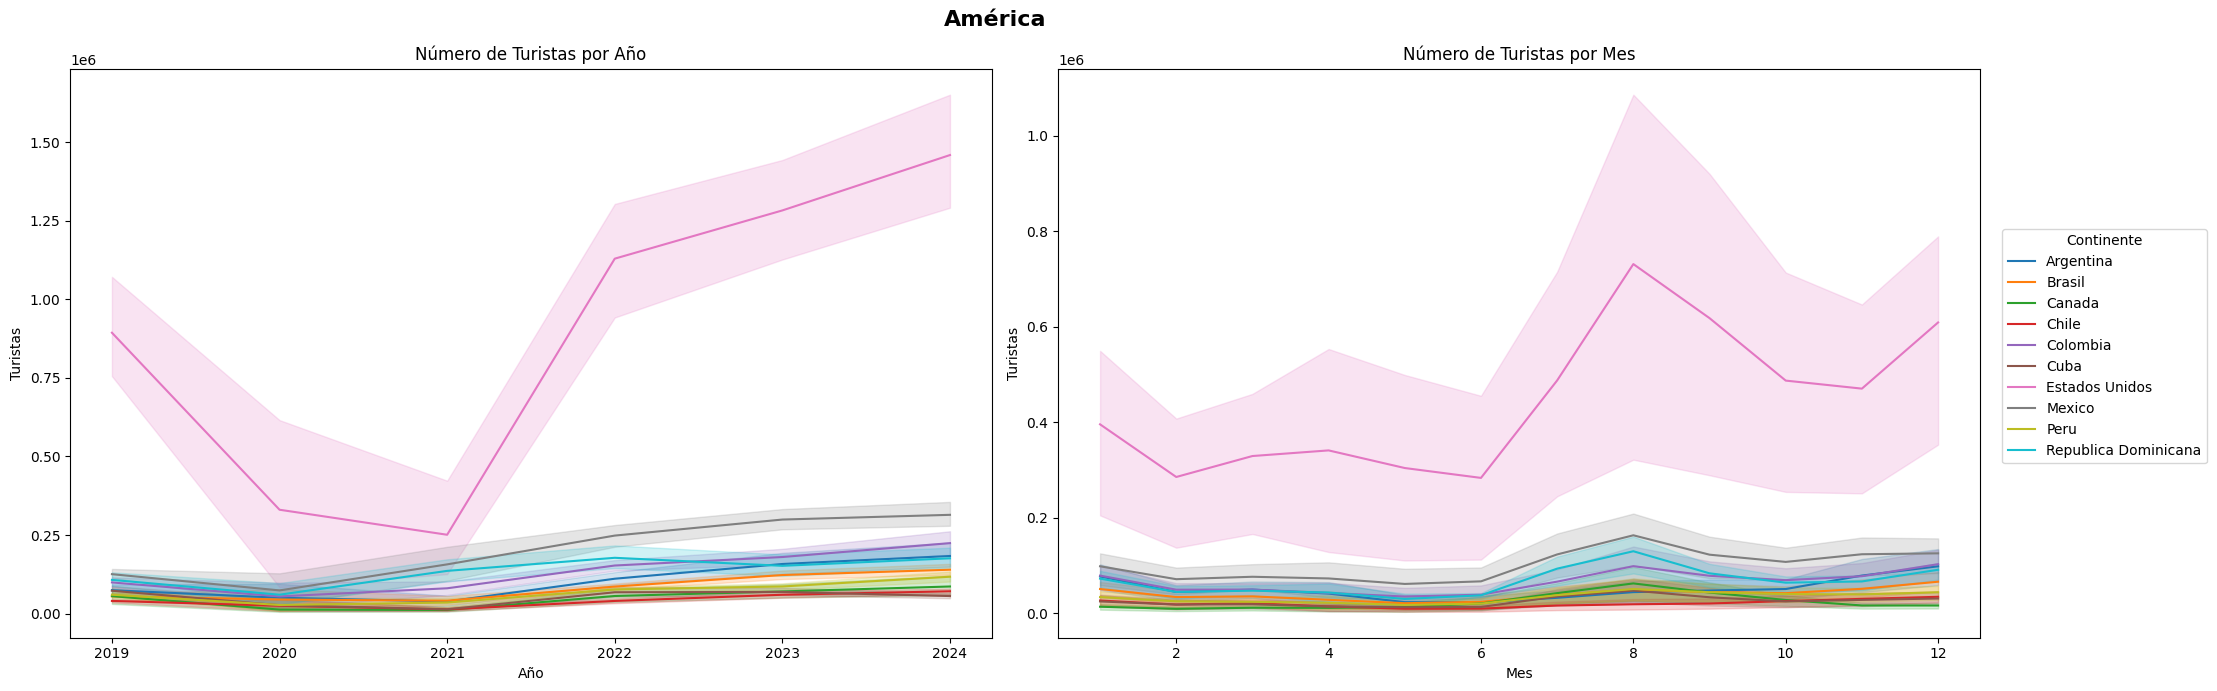

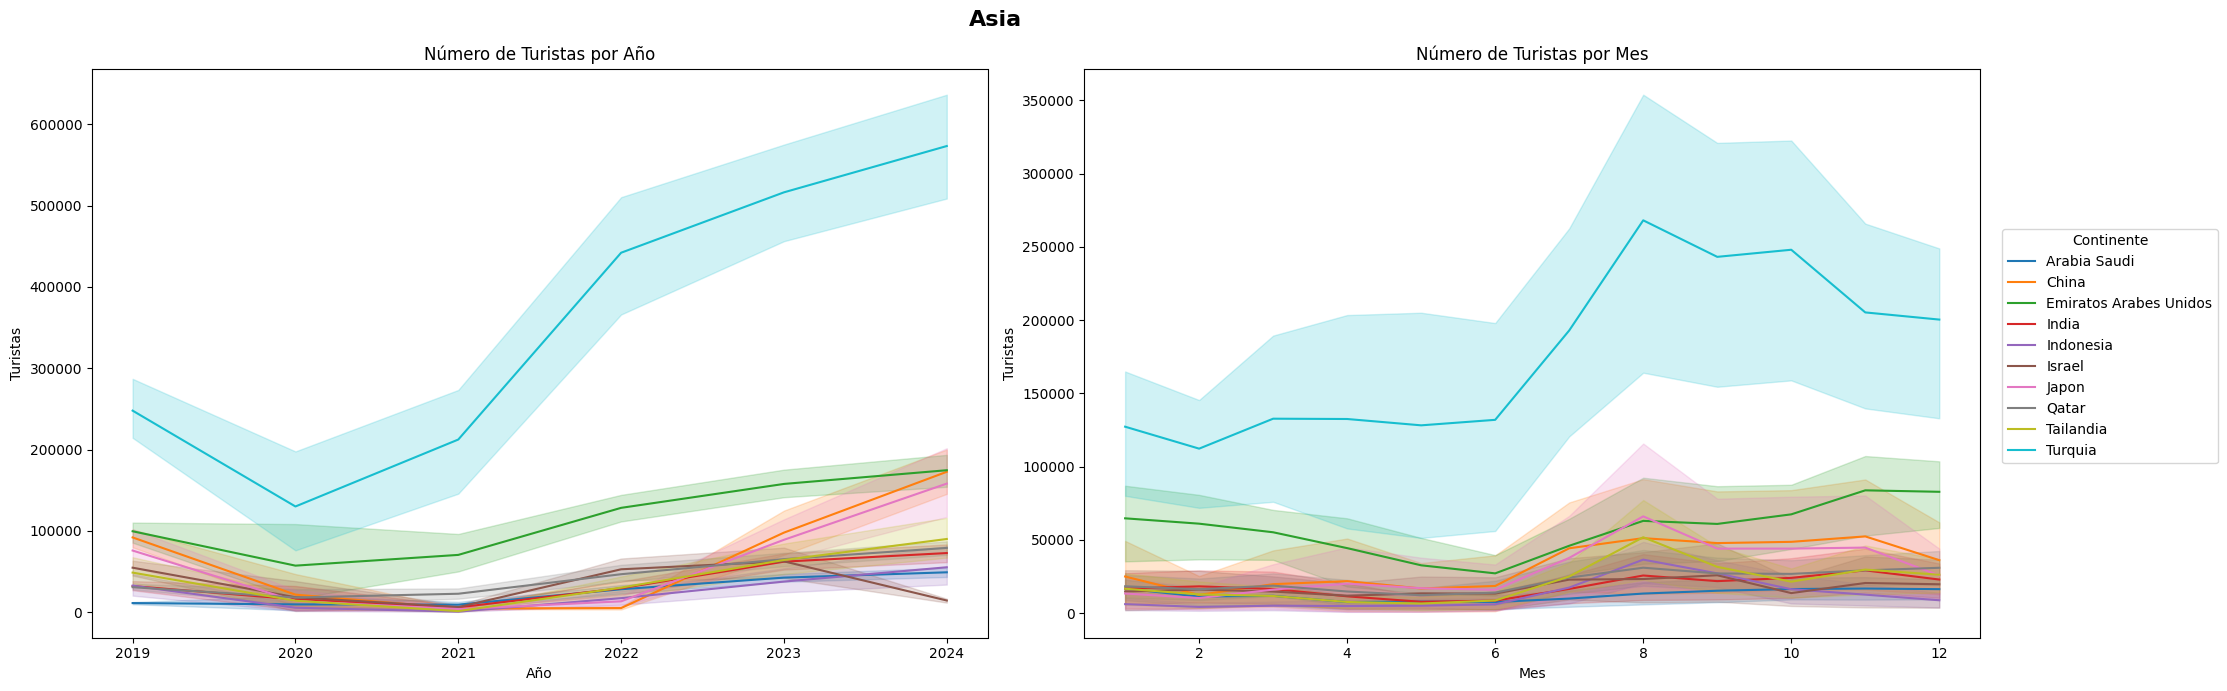

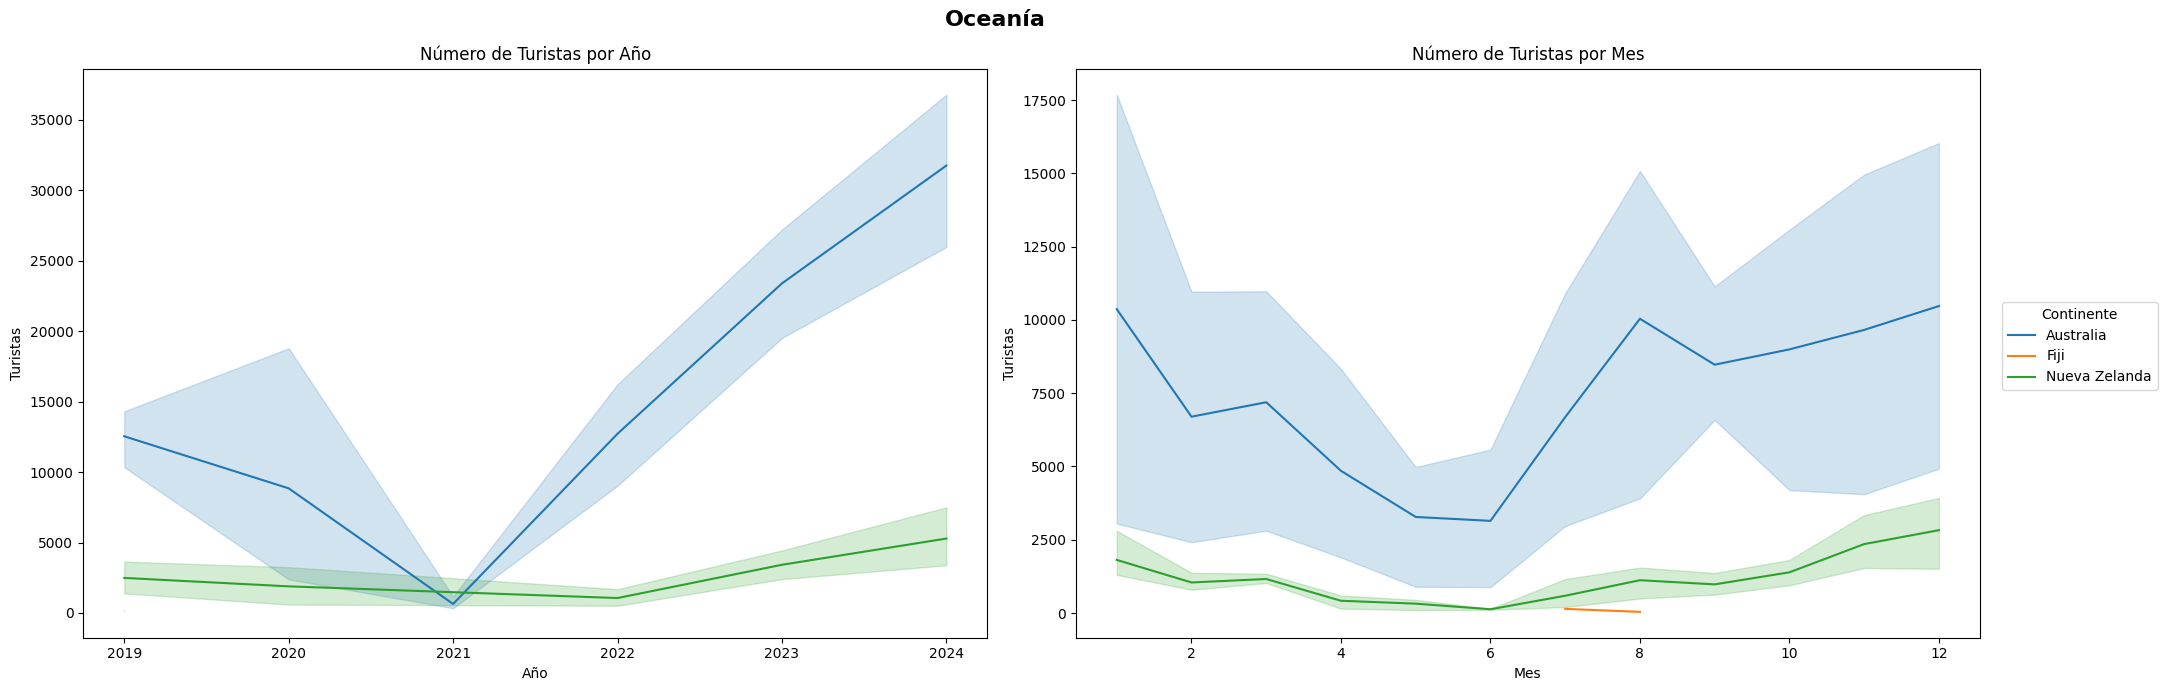

In [722]:

for continente in df_turismo_emisor_agrupado_pais.nombre_continente.unique().tolist():
    df_agrupado = df_turismo_emisor_agrupado_pais[df_turismo_emisor_agrupado_pais.nombre_continente == continente]

    
    # Agrupar por país y sumar turistas
    top_paises = df_agrupado.groupby('nombre_pais_destino', as_index=False)['num_turistas'].sum()

    # Ordenar de mayor a menor y quedarte con el top 10
    top_paises = top_paises.sort_values(by='num_turistas', ascending=False).head(10)


    # Crear figura y ejes
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 columnas, 1 fila

    # Filtrar el dataframe original para quedarte solo con esos países
    df_top_10 = df_agrupado[df_agrupado['nombre_pais_destino'].isin(top_paises['nombre_pais_destino'])]

    # Primer gráfico: num_turistas por año
    sns.lineplot(
        x='ano',
        y='num_turistas',
        data=df_top_10,
        hue='nombre_pais_destino',
        markers=True,
        estimator='sum',
        errorbar=('ci', 95),
        err_style='band',
        ax=axes[0]
    )
    axes[0].set_title('Número de Turistas por Año')
    axes[0].legend(title='Continente')
    axes[0].set_ylabel('Turistas')
    axes[0].set_xlabel('Año')
    axes[0].legend_.remove() 


    # Segundo gráfico: num_turistas por mes 
    sns.lineplot(
        x='mes',
        y='num_turistas',
        data=df_top_10,
        hue='nombre_pais_destino',
        markers=True,
        estimator='sum',
        errorbar=('ci', 95),
        err_style='band',
        ax=axes[1]
    )
    axes[1].set_title('Número de Turistas por Mes')
    axes[1].legend(title='Continente')
    axes[1].set_ylabel('Turistas')
    axes[1].set_xlabel('Mes')
    axes[1].legend_.remove() 

    # Crear leyenda común fuera del gráfico
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5),
        title='Continente'
    )

    # Supertítulo para toda la figura
    fig.suptitle(continente, fontsize=16, fontweight='bold')
    # Ajustar diseño para que no se solapen
    plt.tight_layout()
    plt.show()
    

Se muestra el top ten de los paises del turismo emisor de cada continente. 
- En la mayoría de los paises la tendencia es al alza, excepto en Egipto e Israel. 
- Además se observa como el descenso de los años de Covid, excepto en los paises vecinos (Marruecos, Francia y Portugal)

## 6. Análisis evolución num. pernoctaciones turismo emisor

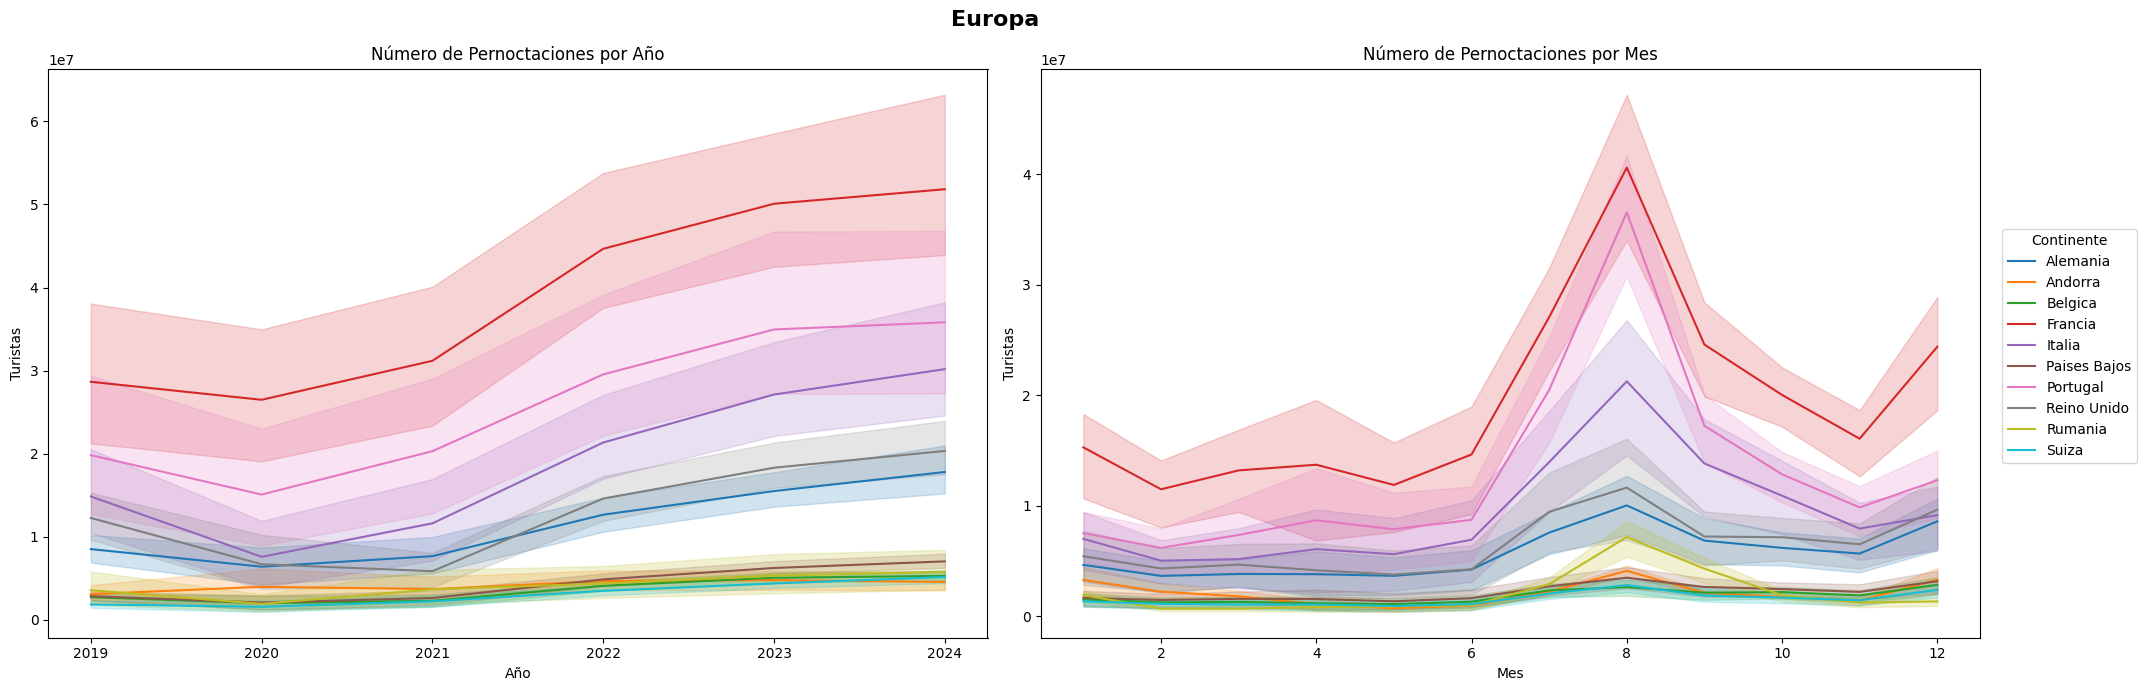

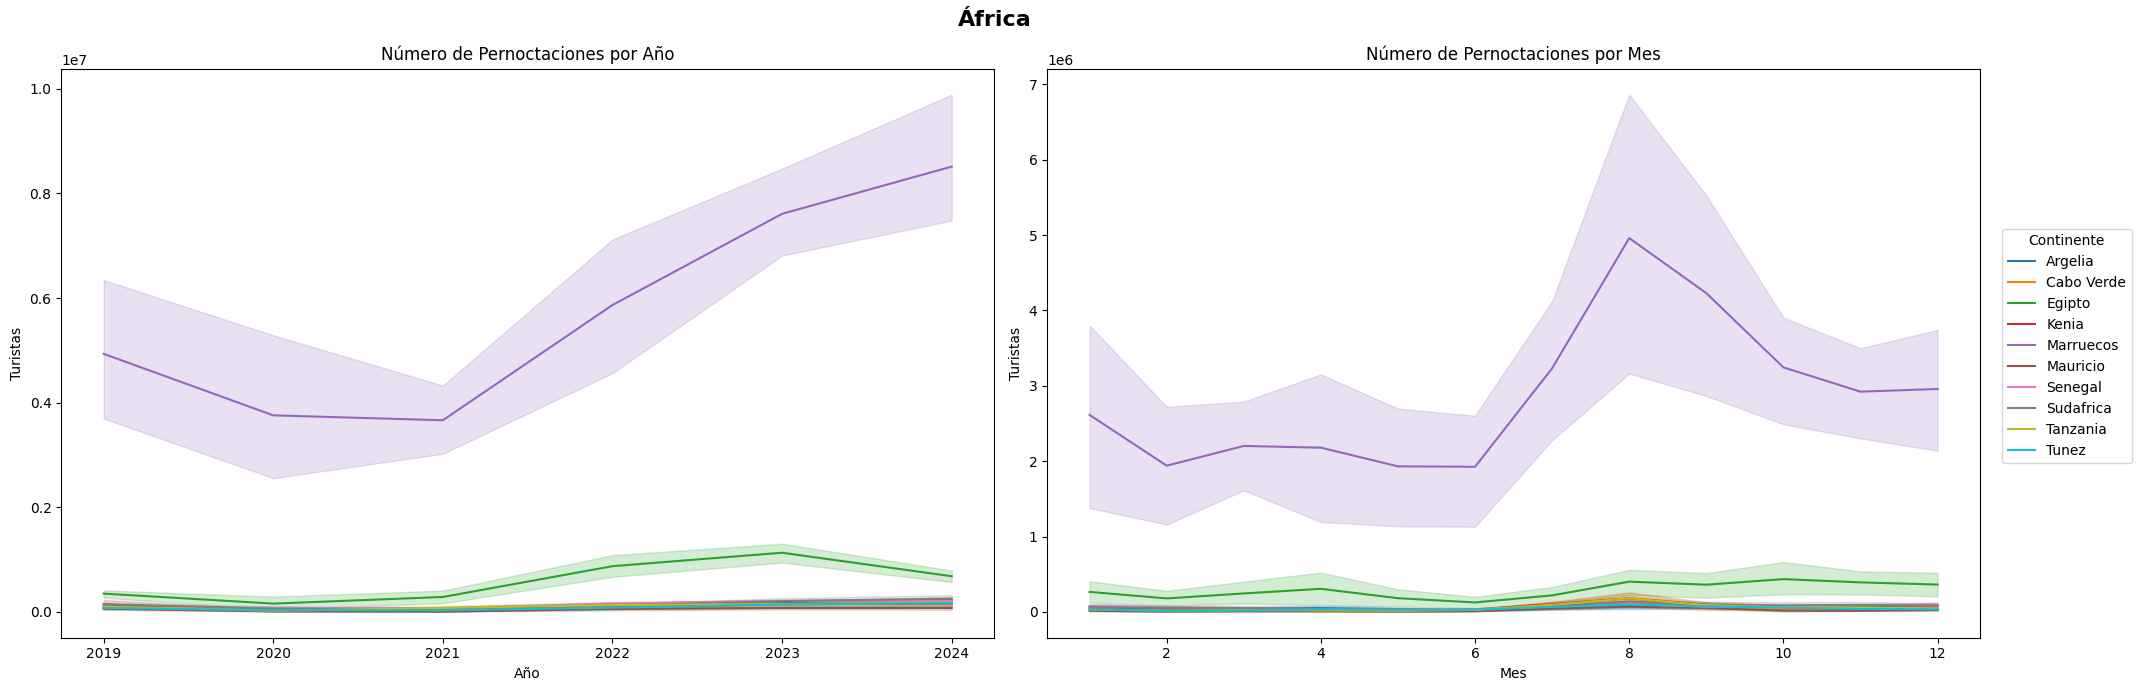

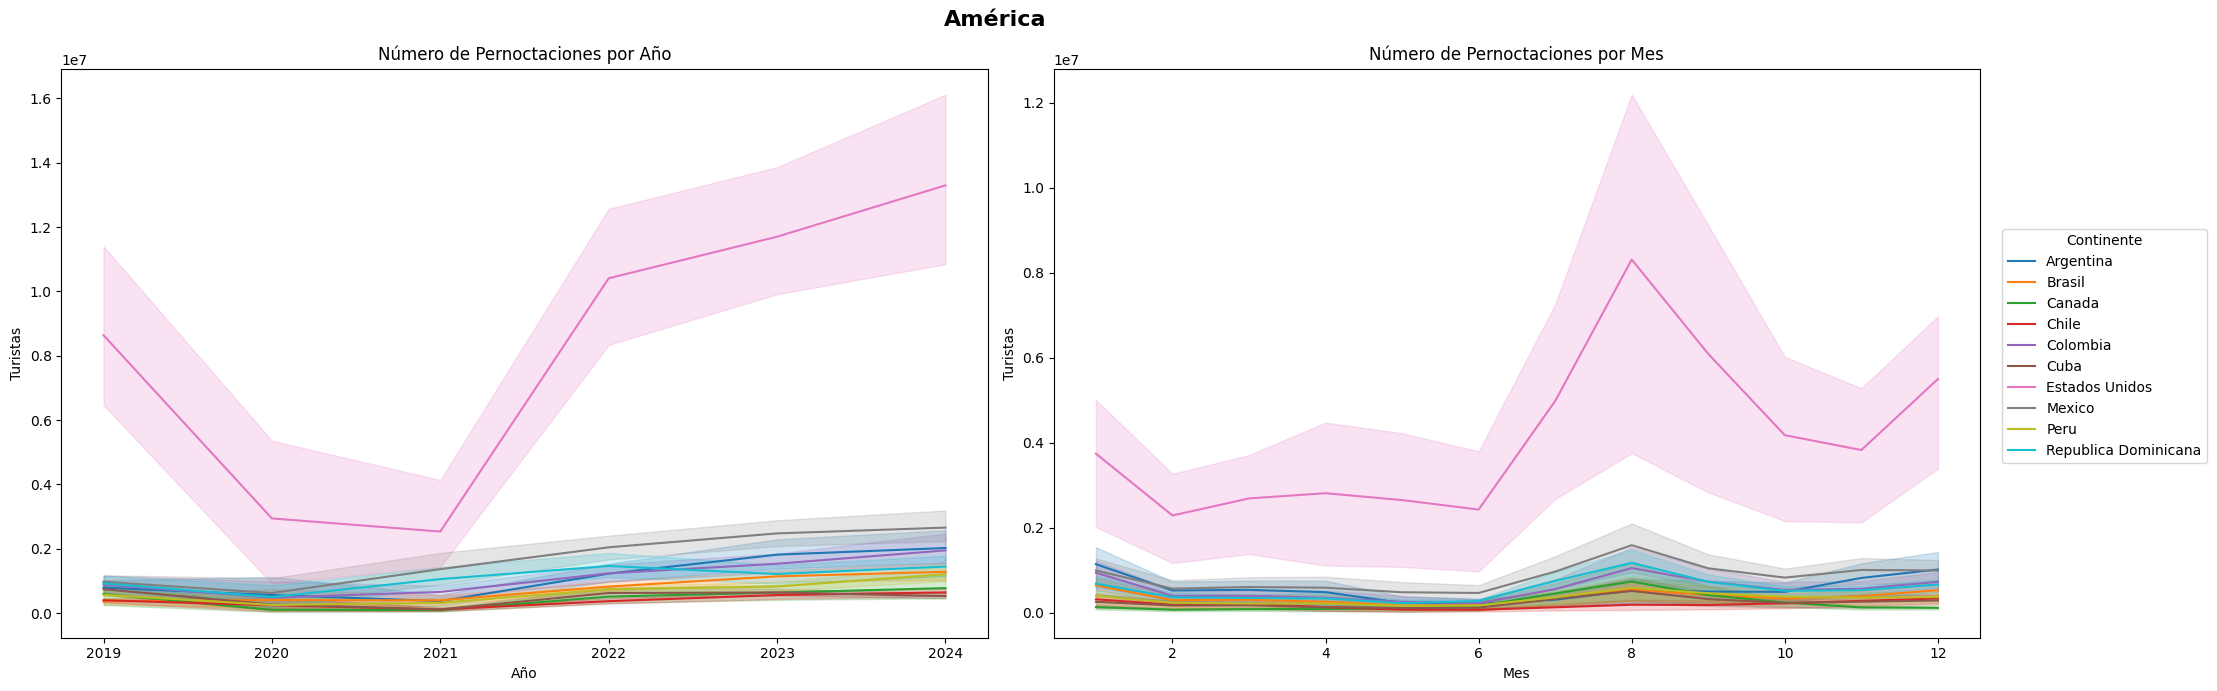

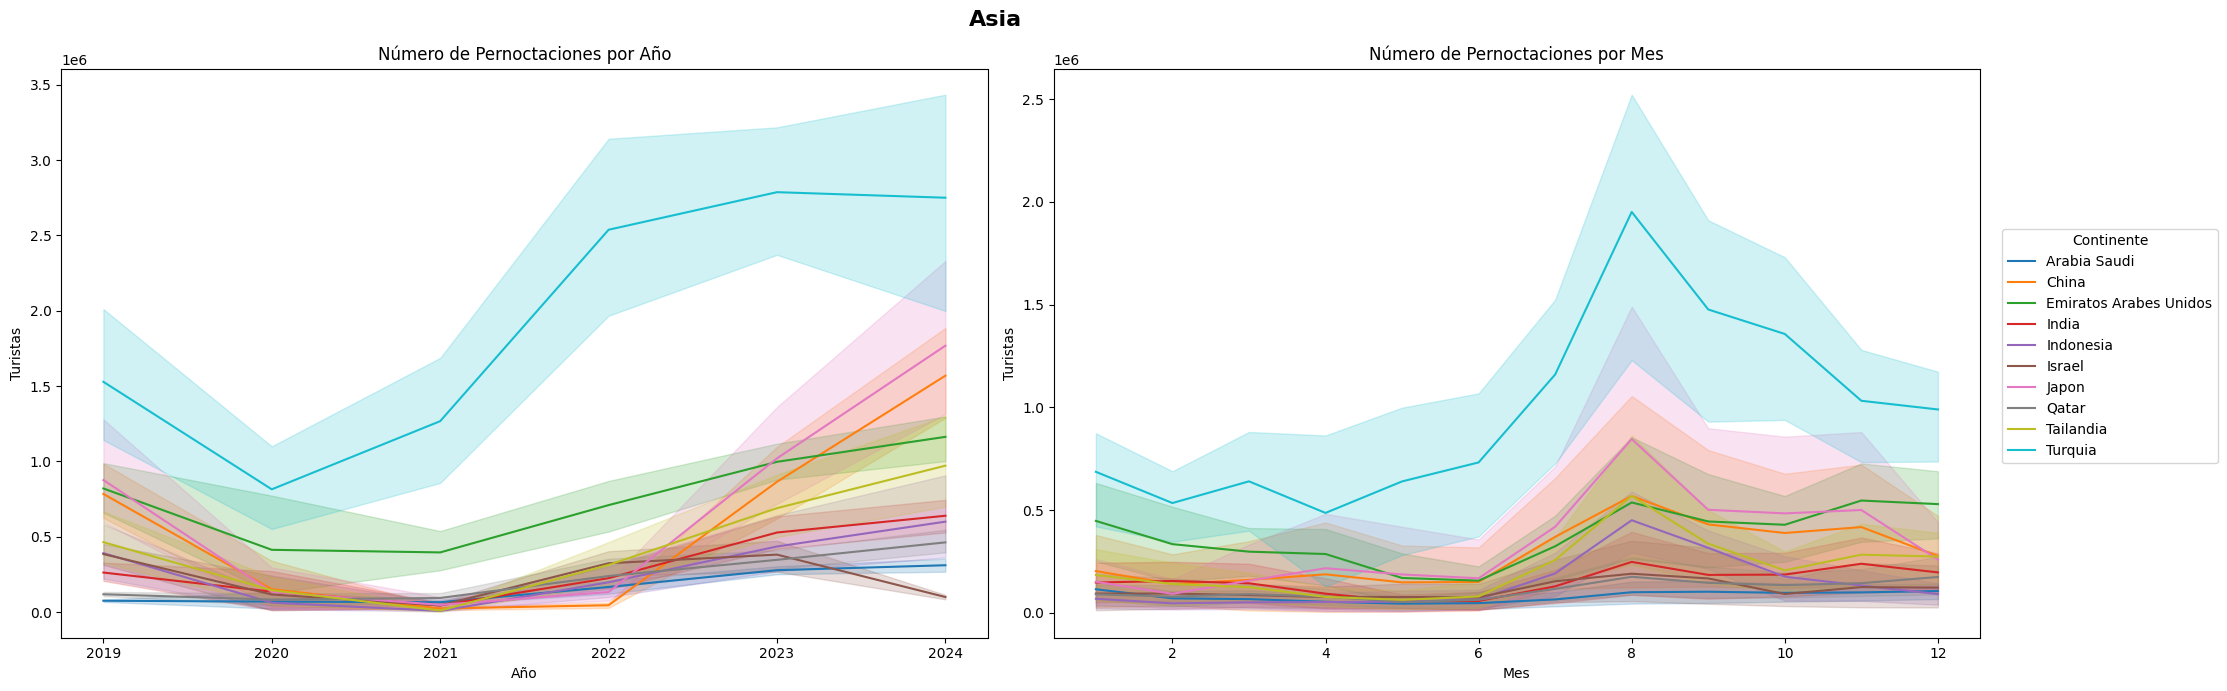

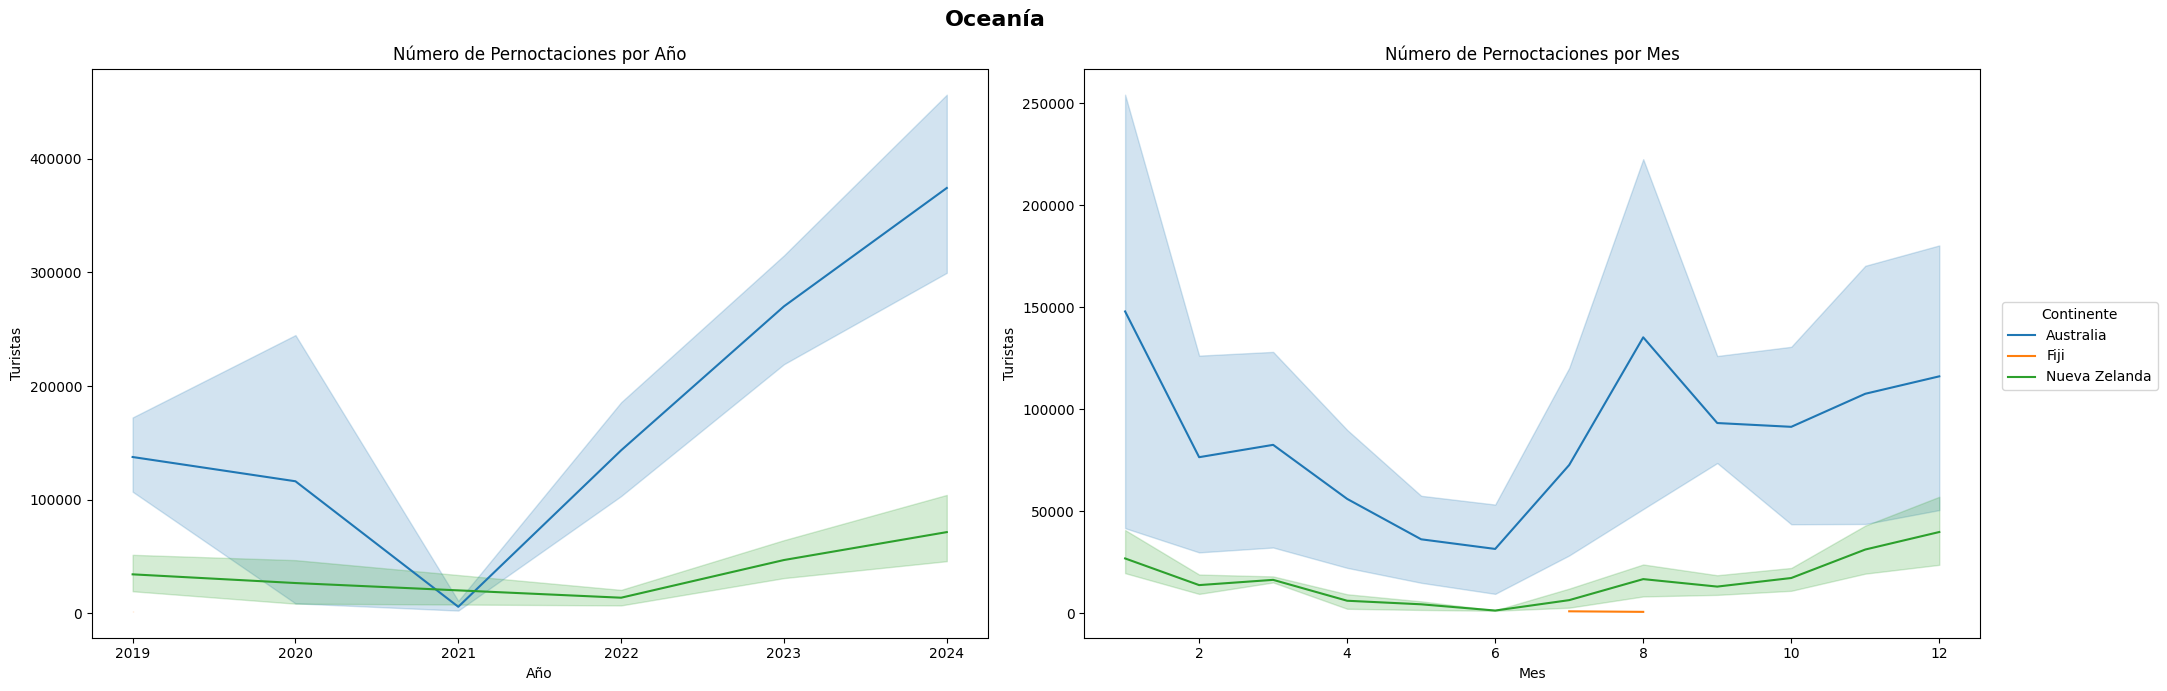

In [723]:
for continente in df_turismo_emisor_agrupado_pais.nombre_continente.unique().tolist():
    df_agrupado = df_turismo_emisor_agrupado_pais[df_turismo_emisor_agrupado_pais.nombre_continente == continente]

    
    # Agrupar por país y sumar turistas
    top_paises = df_agrupado.groupby('nombre_pais_destino', as_index=False)['num_turistas'].sum()

    # Ordenar de mayor a menor y quedarte con el top 10
    top_paises = top_paises.sort_values(by='num_turistas', ascending=False).head(10)


    # Crear figura y ejes
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 columnas, 1 fila

    # Filtrar el dataframe original para quedarte solo con esos países
    df_top_10 = df_agrupado[df_agrupado['nombre_pais_destino'].isin(top_paises['nombre_pais_destino'])]

    # Primer gráfico: num_pernoctaciones por año
    sns.lineplot(
        x='ano',
        y='num_pernoctaciones',
        data=df_top_10,
        hue='nombre_pais_destino',
        markers=True,
        estimator='sum',
        errorbar=('ci', 95),
        err_style='band',
        ax=axes[0]
    )
    axes[0].set_title('Número de Pernoctaciones por Año')
    axes[0].legend(title='Continente')
    axes[0].set_ylabel('Turistas')
    axes[0].set_xlabel('Año')
    axes[0].legend_.remove() 


    # Segundo gráfico: num_pernoctaciones por mes 
    sns.lineplot(
        x='mes',
        y='num_pernoctaciones',
        data=df_top_10,
        hue='nombre_pais_destino',
        markers=True,
        estimator='sum',
        errorbar=('ci', 95),
        err_style='band',
        ax=axes[1]
    )
    axes[1].set_title('Número de Pernoctaciones por Mes')
    axes[1].legend(title='Continente')
    axes[1].set_ylabel('Turistas')
    axes[1].set_xlabel('Mes')
    axes[1].legend_.remove() 

    # Crear leyenda común fuera del gráfico
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5),
        title='Continente'
        )

    # Supertítulo para toda la figura
    fig.suptitle(continente, fontsize=16, fontweight='bold')
    # Ajustar diseño para que no se solapen
    plt.tight_layout()
    plt.show()

## 7. Análisis de los precios

In [724]:
df_viaje_precios.head()

id_viaje                                          url_viaje  \
0         1      https://es.tui.com/viaje/albania-y-montenegro   
1         2  https://viajeonline.es.tui.com/es/idea/1463025...   
2         3  https://viajeonline.es.tui.com/es/idea/7897512...   
3         4  https://viajeonline.es.tui.com/es/idea/8404511...   
4         5  https://viajeonline.es.tui.com/es/idea/7906930...   

                                  nombre_viaje  duracion_dias  \
0                         Albania y Montenegro              8   
1                                       Berlín              4   
2  Fly & Drive Austria, Entre Lagos y Montañas              8   
3             Fly & Drive Carlomagno a su aire             10   
4                Fly & Drive Tirol al Completo              8   

   duracion_noches  id_itinerario  viaje_activo  precio_viaje  \
0                7         1027.0          True          1755   
1                3          146.0          True           708   
2                7          872.0          True           827   
3                9          166.0          True           857   
4                7         1145.0          True           894   

  fecha_precio_viaje  
0         2025-04-07  
1         2025-04-07  
2         2025-04-07  
3         2025-04-07  
4         2025-04-07

In [725]:
df_viajes_precios_paises = df_viaje_precios.copy()

In [726]:
df_viajes_precios_paises['id_pais_destino']= None

In [727]:
#le incorporo la información de id_pais_destino
ex.incorporar_información_df_original(df_viajes_precios_paises,df_combinacion_destino_viaje,'id_viaje', 'id_pais_destino','id_pais_destino')

In [728]:
df_viajes_precios_paises['nombre_pais_destino']= None
df_viajes_precios_paises['nombre_continente'] = None

In [729]:
# le incorporo la información del nombre_pais
ex.incorporar_información_df_original(df_viajes_precios_paises,df_paises,'id_pais_destino', 'nombre_pais_destino','nombre_pais_destino')
# le incorporo la información del nombre_continente
ex.incorporar_información_df_original(df_viajes_precios_paises,df_paises,'id_pais_destino', 'nombre_continente','nombre_continente')

In [730]:
df_viajes_precios_paises.head()

id_viaje                                          url_viaje  \
0         1      https://es.tui.com/viaje/albania-y-montenegro   
1         2  https://viajeonline.es.tui.com/es/idea/1463025...   
2         3  https://viajeonline.es.tui.com/es/idea/7897512...   
3         4  https://viajeonline.es.tui.com/es/idea/8404511...   
4         5  https://viajeonline.es.tui.com/es/idea/7906930...   

                                  nombre_viaje  duracion_dias  \
0                         Albania y Montenegro              8   
1                                       Berlín              4   
2  Fly & Drive Austria, Entre Lagos y Montañas              8   
3             Fly & Drive Carlomagno a su aire             10   
4                Fly & Drive Tirol al Completo              8   

   duracion_noches  id_itinerario  viaje_activo  precio_viaje  \
0                7         1027.0          True          1755   
1                3          146.0          True           708   
2                7          872.0          True           827   
3                9          166.0          True           857   
4                7         1145.0          True           894   

  fecha_precio_viaje  id_pais_destino nombre_pais_destino nombre_continente  
0         2025-04-07              119          Montenegro            Europa  
1         2025-04-07                2            Alemania            Europa  
2         2025-04-07               12             Austria            Europa  
3         2025-04-07               19             Belgica            Europa  
4         2025-04-07               87              Italia            Europa

In [731]:
#elimino duplicados:
df_viajes_precios_paises_sin_duplicados = df_viajes_precios_paises[['id_viaje','nombre_viaje', 'duracion_dias',
       'duracion_noches', 'id_itinerario', 'viaje_activo', 'precio_viaje',
       'id_pais_destino', 'nombre_pais_destino',
       'nombre_continente']].drop_duplicates()

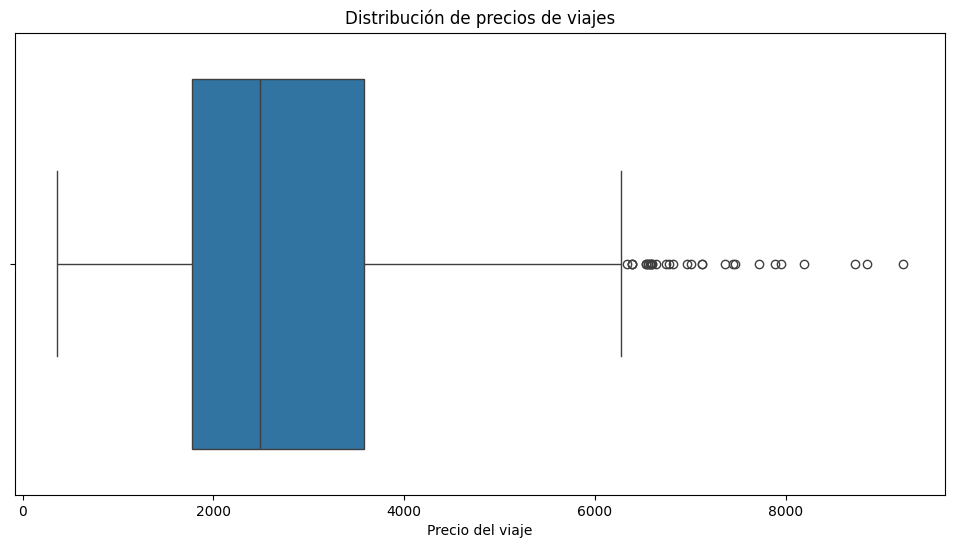

In [732]:
#Distribución de viajes agrupados
plt.figure(figsize=(12, 6))
sns.boxplot(x='precio_viaje', data=df_viajes_precios_paises_sin_duplicados)
plt.title('Distribución de precios de viajes')
plt.xlabel('Precio del viaje')
plt.show()

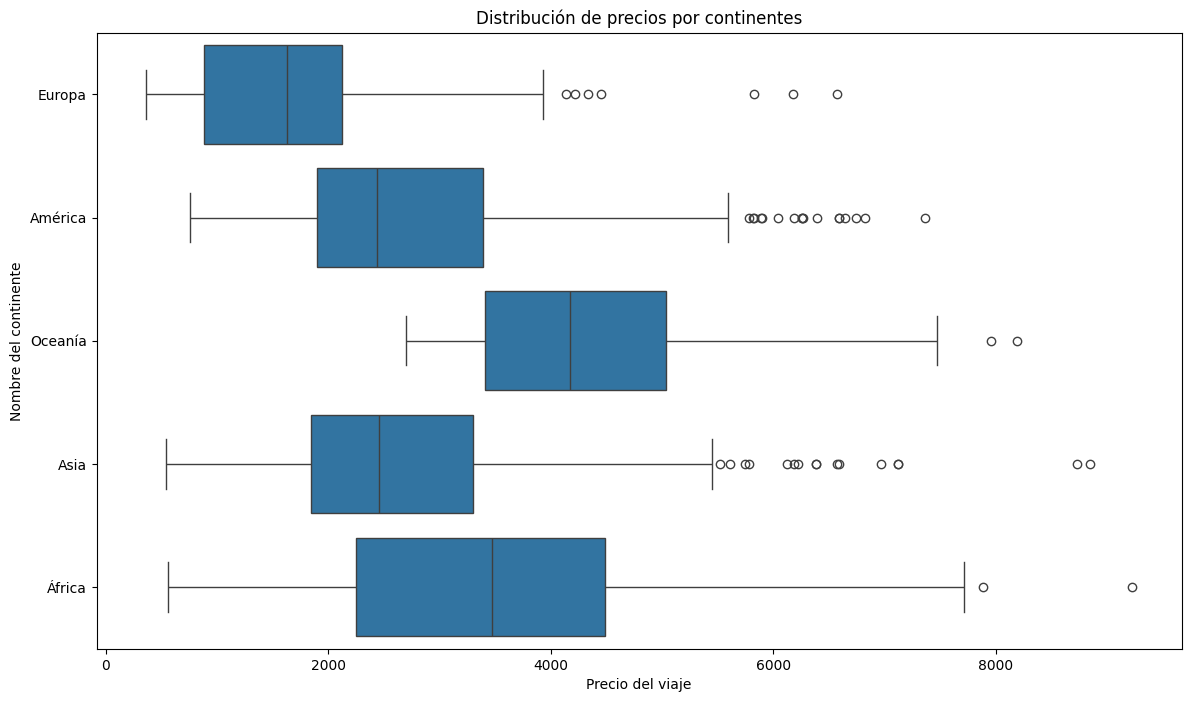

In [733]:
#Distribución por continentes
plt.figure(figsize=(14, 8))
sns.boxplot(
    y='nombre_continente',
      x='precio_viaje',
     data=df_viajes_precios_paises_sin_duplicados)
plt.title('Distribución de precios por continentes')
plt.xlabel('Precio del viaje')
plt.ylabel('Nombre del continente')
plt.show()

- Los precios en Europa son más bajos. Los de América y Asia son similares. Sin embargo Asia tiene algunos outliers superiores a los de América. 
- Los precios de Oceanía son los más caros, no obstante, no es el continente que tiene el viaje má caro. Junto con África, es la que menos outliers tiene. Su precio mínimo es mucho más elevado que el de resto de continentes.
- África es la que tiene mayor variabilidad de precio, siendo además el continente con el viaje más caro. 
- Solo se presentan outliers por precios elevados. 

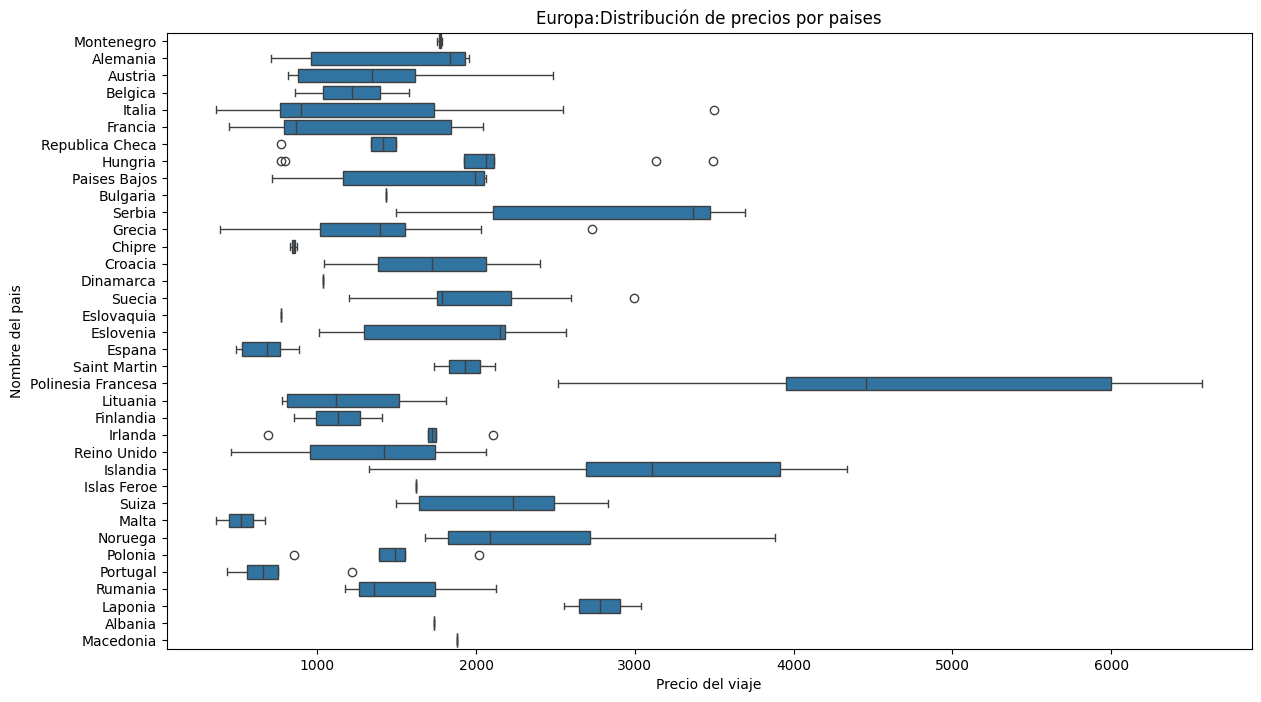

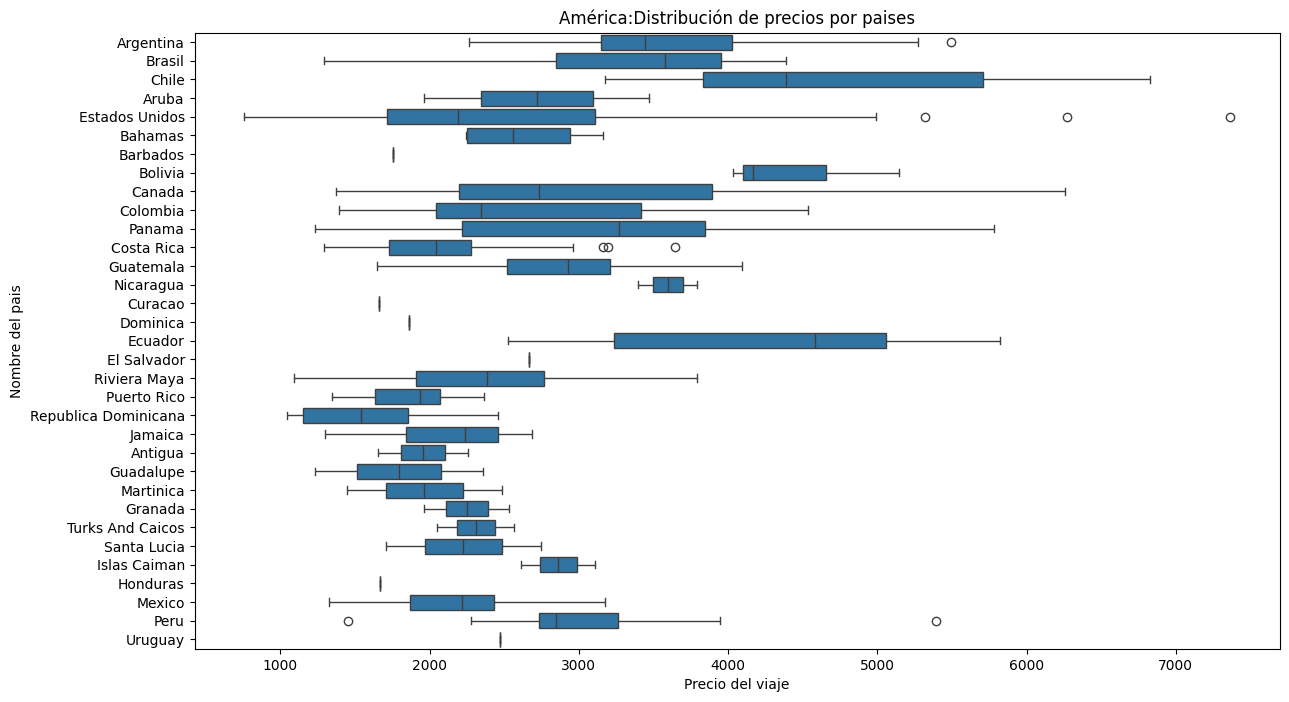

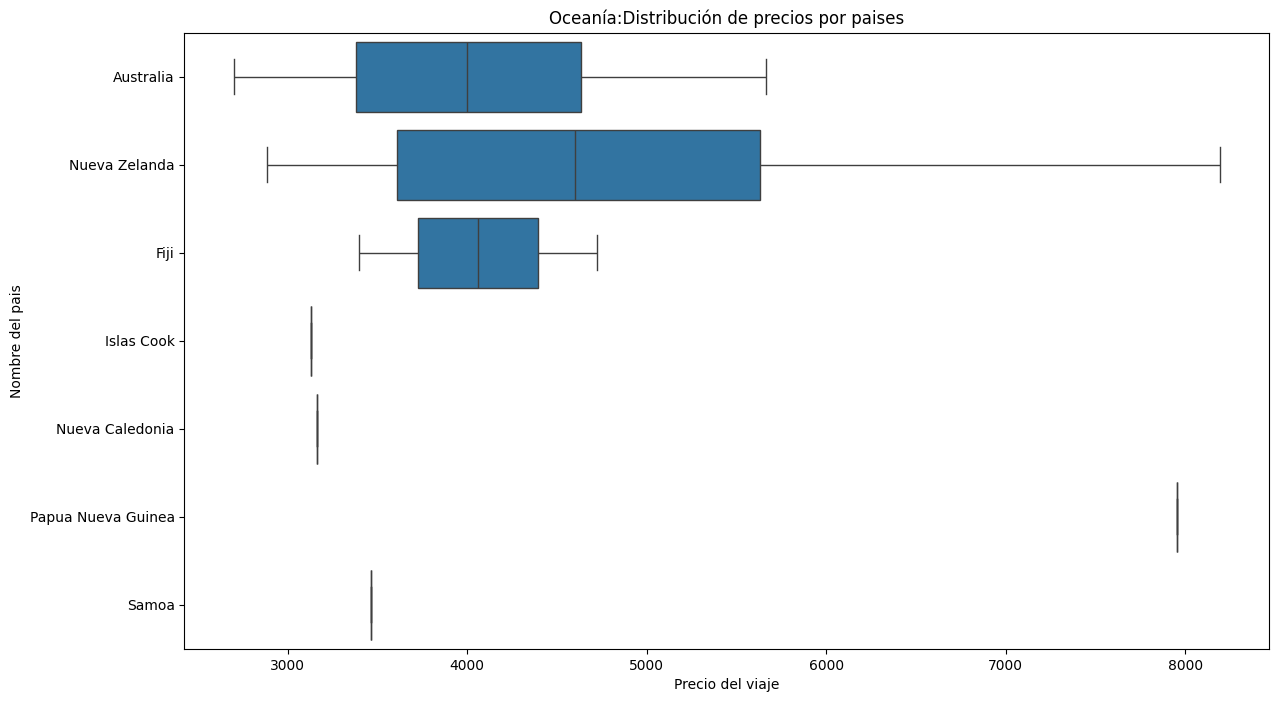

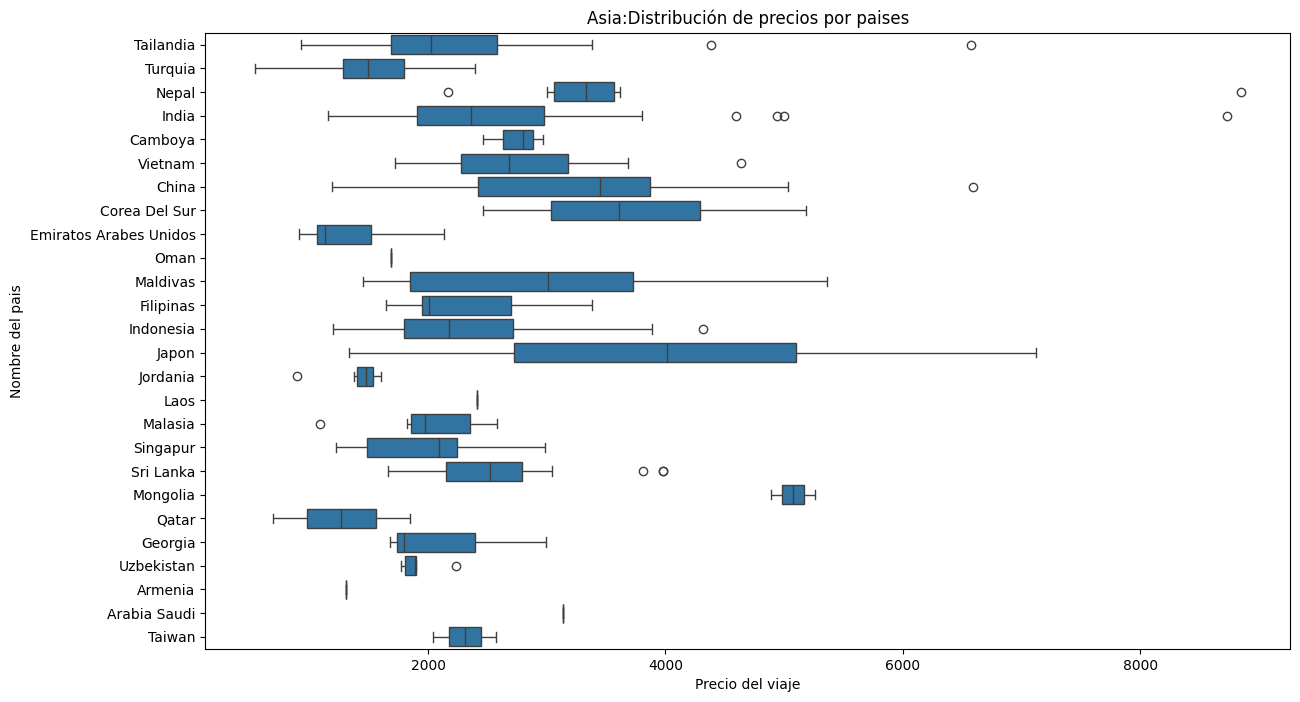

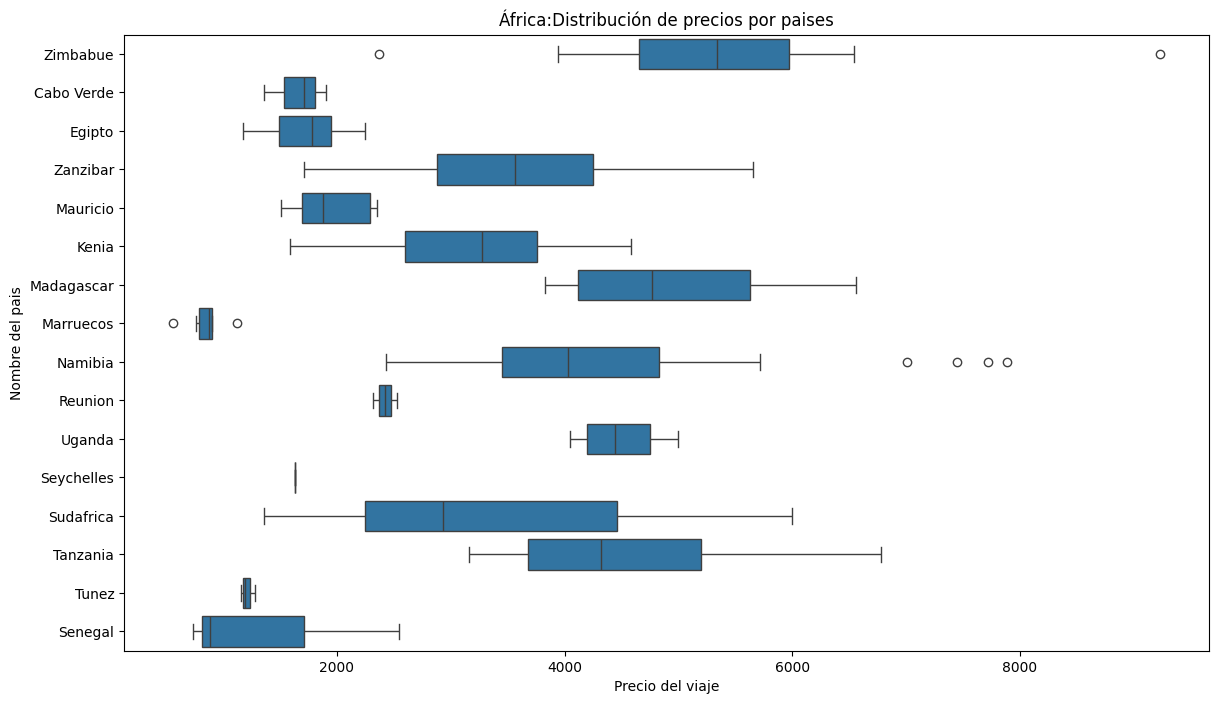

In [734]:
#Distribución precios por paises
for continente in df_viajes_precios_paises_sin_duplicados.nombre_continente.unique().tolist():
    df_filtrado_continente_precios_paises = df_viajes_precios_paises_sin_duplicados[df_viajes_precios_paises_sin_duplicados.nombre_continente == continente]
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        y='nombre_pais_destino',
        x='precio_viaje',
        data=df_filtrado_continente_precios_paises)
    plt.title(f'{continente}:Distribución de precios por paises')
    plt.xlabel('Precio del viaje')
    plt.ylabel('Nombre del pais')
    plt.show()


### 7.1 Análisis temporal de los precios de aquellos viajes que han sufrido cambios

In [735]:
lista_viajes_precios_duplicados = df_viaje_con_precios_distintos.id_viaje.unique().tolist()

In [736]:
df_viaje_precios_viajes_precios_duplicados = df_viajes_precios_paises[df_viajes_precios_paises.id_viaje.isin(lista_viajes_precios_duplicados)].drop_duplicates(['id_viaje','precio_viaje']).sort_values('id_viaje')

In [738]:
df_viaje_precios_viajes_precios_duplicados.head()

id_viaje                                          url_viaje  \
10           11  https://es.tui.com/viaje/buenos-aires-el-calaf...   
15764        11  https://es.tui.com/viaje/buenos-aires-el-calaf...   
17694        12        https://es.tui.com/viaje/argentina-y-brasil   
11           12        https://es.tui.com/viaje/argentina-y-brasil   
14           15  https://es.tui.com/viaje/lagos-glaciares-y-cat...   

                             nombre_viaje  duracion_dias  duracion_noches  \
10     Buenos Aires, El Calafate e Iguazú             11                8   
15764  Buenos Aires, El Calafate e Iguazú             11                8   
17694                  Argentina y Brasil             14               11   
11                     Argentina y Brasil             14               11   
14           Lagos, Glaciares y Cataratas             13               10   

       id_itinerario  viaje_activo  precio_viaje fecha_precio_viaje  \
10             183.0          True          2865         2025-04-07   
15764          183.0          True          2945         2025-05-06   
17694          184.0          True          3075         2025-05-09   
11             184.0          True          2965         2025-04-07   
14             182.0          True          3295         2025-04-07   

       id_pais_destino nombre_pais_destino nombre_continente  
10                   8           Argentina           América  
15764                8           Argentina           América  
17694               25              Brasil           América  
11                  25              Brasil           América  
14                   8           Argentina           América

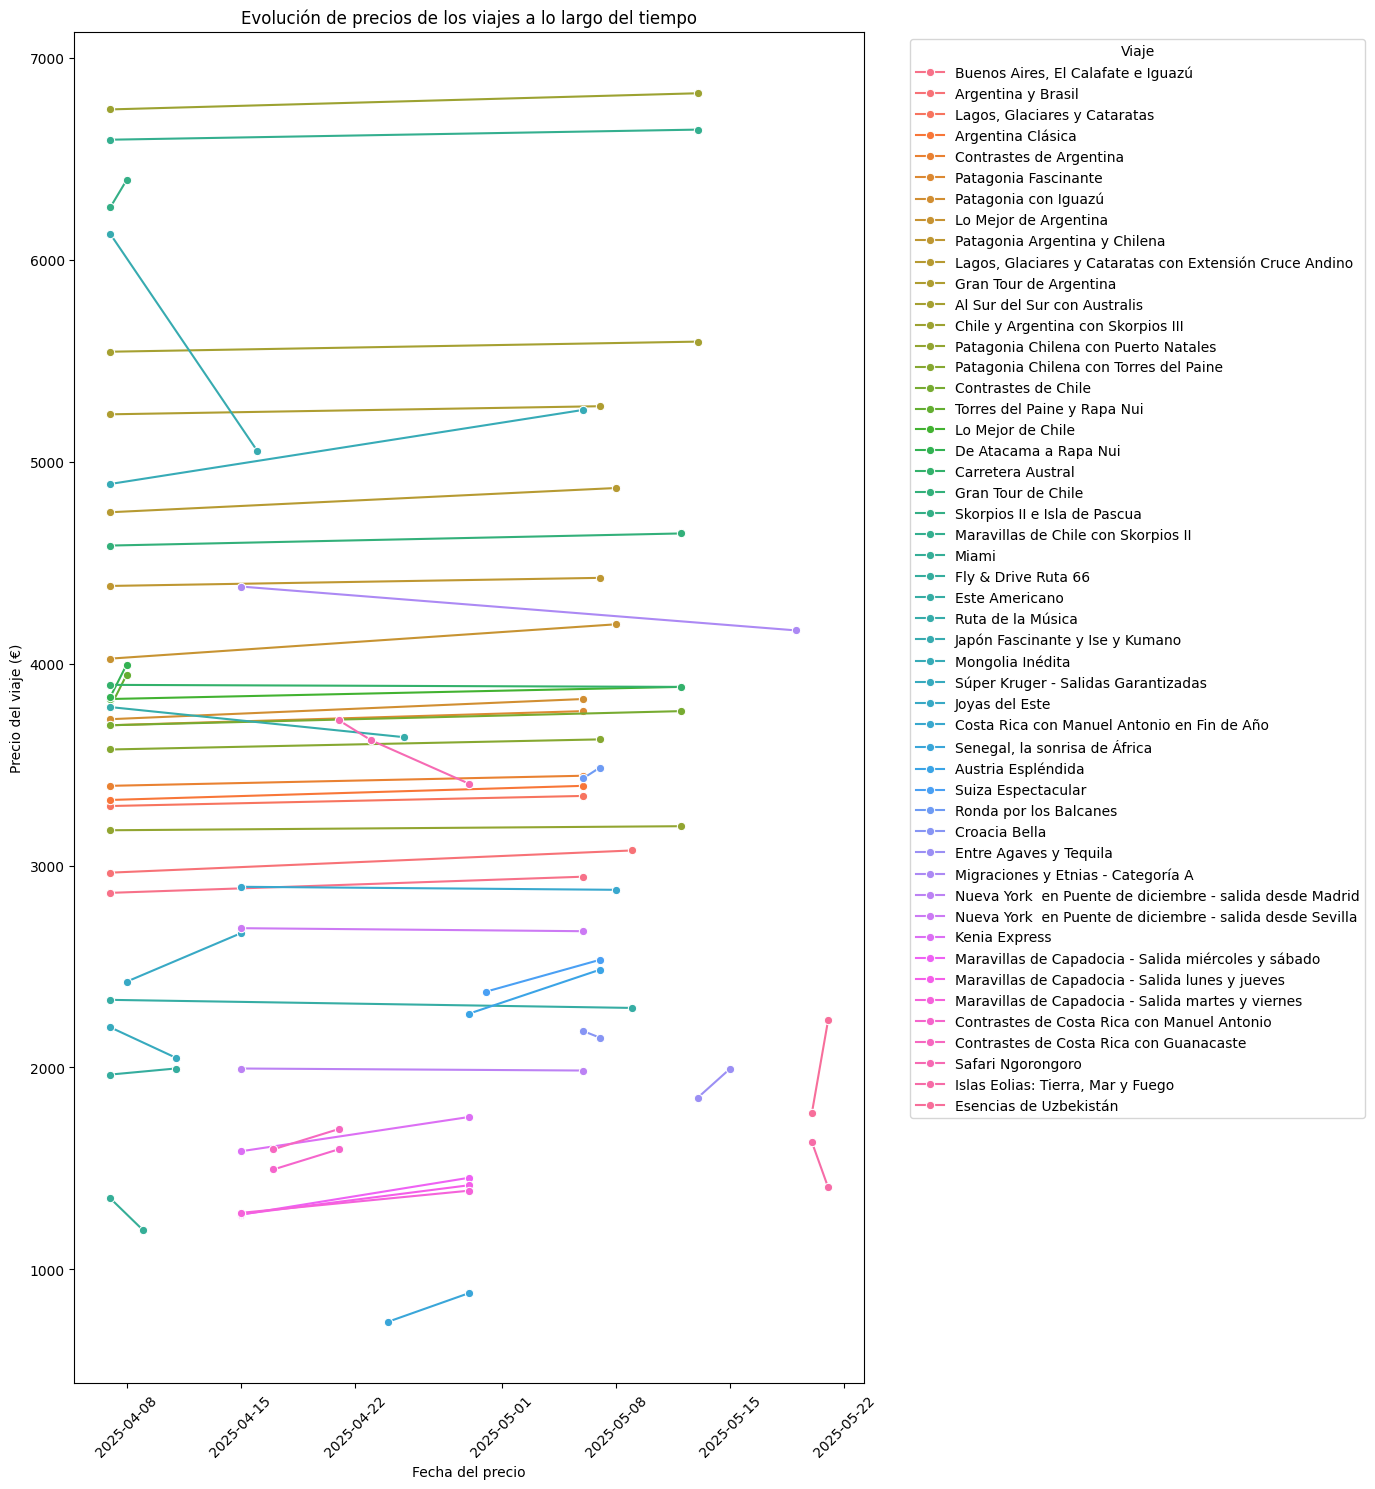

In [739]:
plt.figure(figsize=(14, 15))
sns.lineplot(
    data=df_viaje_precios_viajes_precios_duplicados, 
    x='fecha_precio_viaje', 
    y='precio_viaje',
    hue='nombre_viaje',
    marker='o'
)
plt.title('Evolución de precios de los viajes a lo largo del tiempo')
plt.xlabel('Fecha del precio')
plt.ylabel('Precio del viaje (€)')
plt.xticks(rotation=45)
plt.legend(title='Viaje', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [740]:
df_viajes_sorted = df_viaje_precios_viajes_precios_duplicados.sort_values(['id_viaje', 'fecha_precio_viaje'])

In [741]:
df_cambios_precios = df_viajes_sorted.groupby(['id_viaje', 'nombre_viaje']).agg(
    precio_antes=('precio_viaje', 'first'),
    precio_despues=('precio_viaje', 'last')
).reset_index()

In [742]:
df_cambios_precios['dif_precios'] = df_cambios_precios['precio_antes']-df_cambios_precios['precio_despues']


In [744]:
df_cambios_precios.head()

id_viaje                        nombre_viaje  precio_antes  precio_despues  \
0        11  Buenos Aires, El Calafate e Iguazú          2865            2945   
1        12                  Argentina y Brasil          2965            3075   
2        15        Lagos, Glaciares y Cataratas          3295            3345   
3        16                   Argentina Clásica          3325            3395   
4        17             Contrastes de Argentina          3395            3445   

   dif_precios  
0          -80  
1         -110  
2          -50  
3          -70  
4          -50

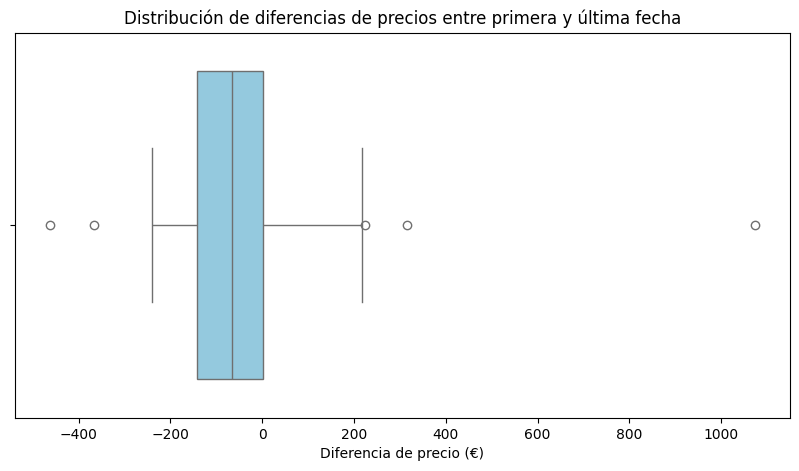

In [745]:
#Lo represento en un boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_cambios_precios['dif_precios'], color='skyblue')
plt.title('Distribución de diferencias de precios entre primera y última fecha')
plt.xlabel('Diferencia de precio (€)')
plt.show()

La mayoria baja de precio entre 0 y 150€. No obstante, existen algunos outliers, tanto por arriba como por abajo.

## 8. Análisis de las pernoctaciones de los viajes de TUI

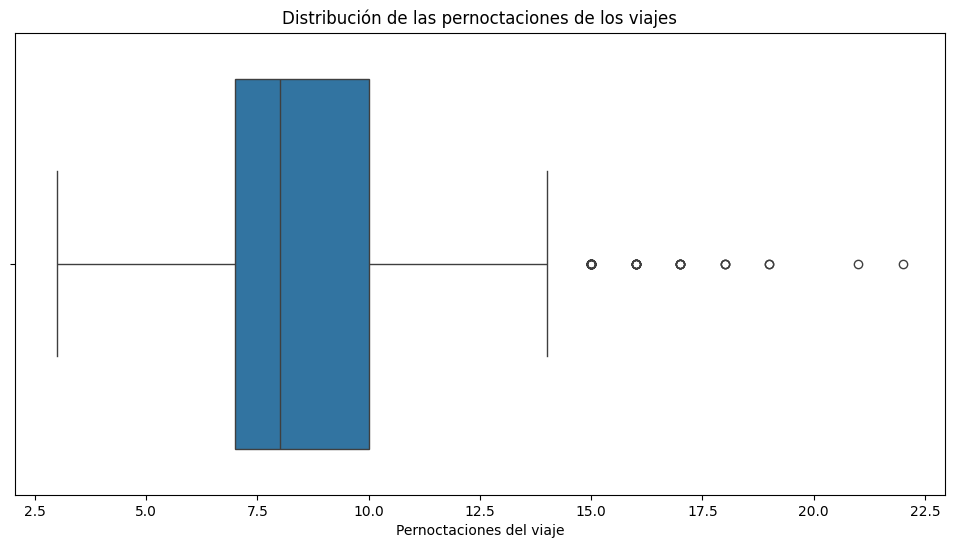

In [746]:
#Distribución de viajes agrupados
plt.figure(figsize=(12, 6))
sns.boxplot(x='duracion_noches', data=df_viajes_precios_paises_sin_duplicados)
plt.title('Distribución de las pernoctaciones de los viajes')
plt.xlabel('Pernoctaciones del viaje')
plt.show()

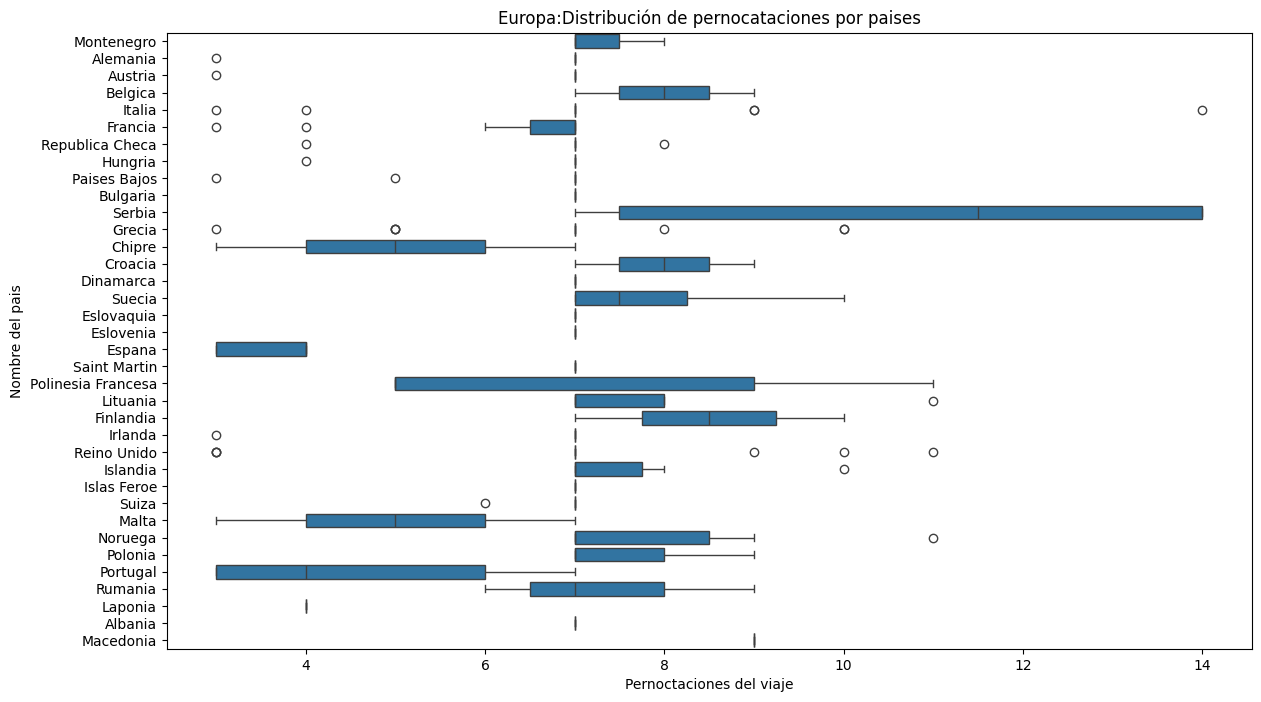

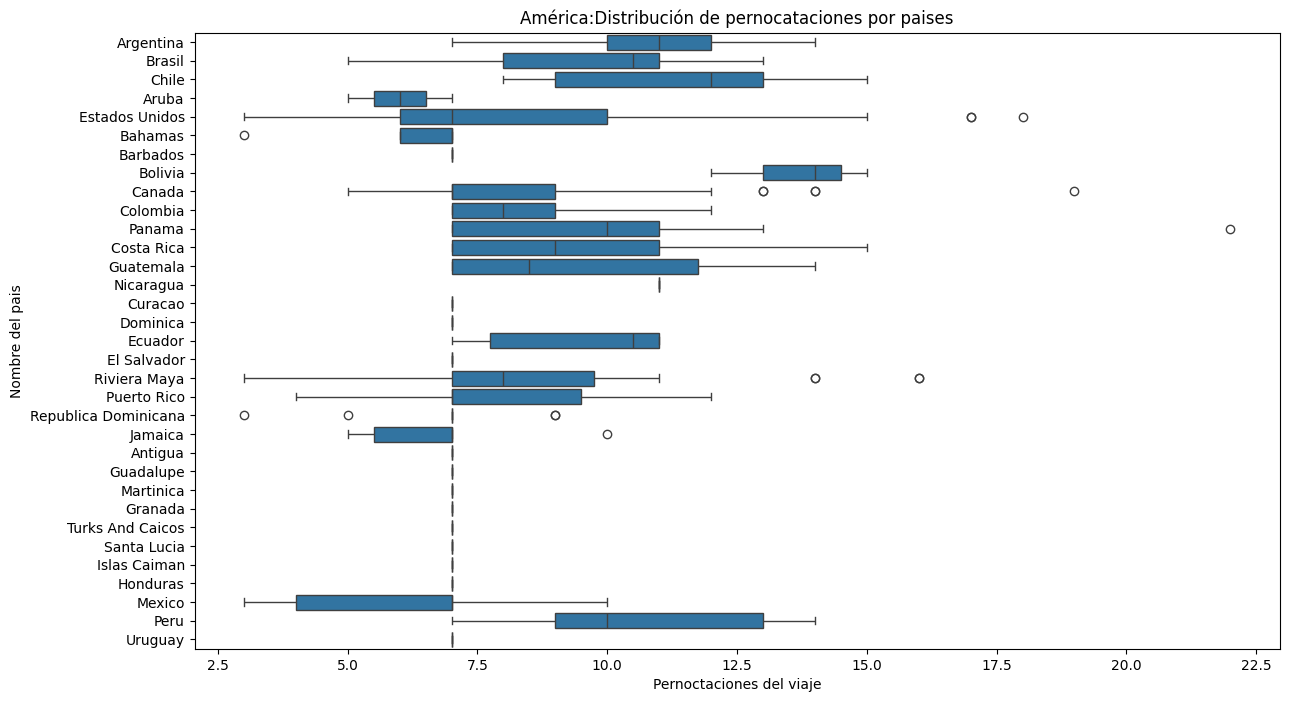

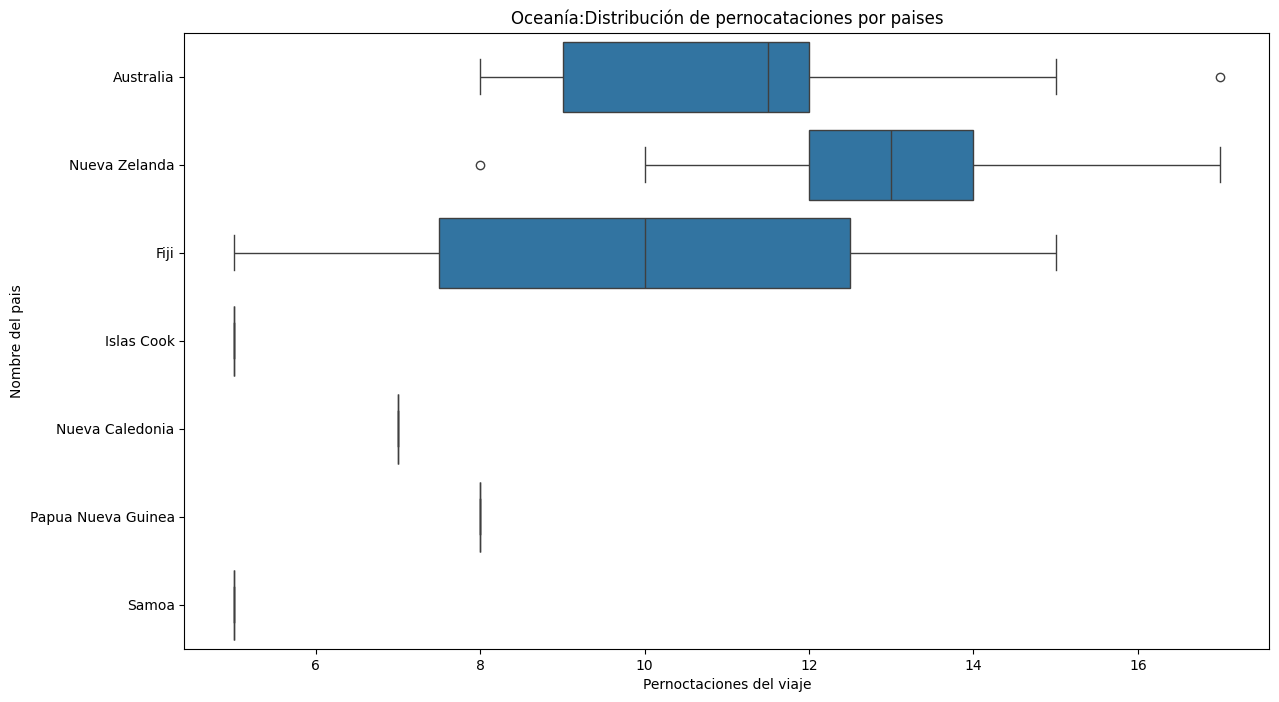

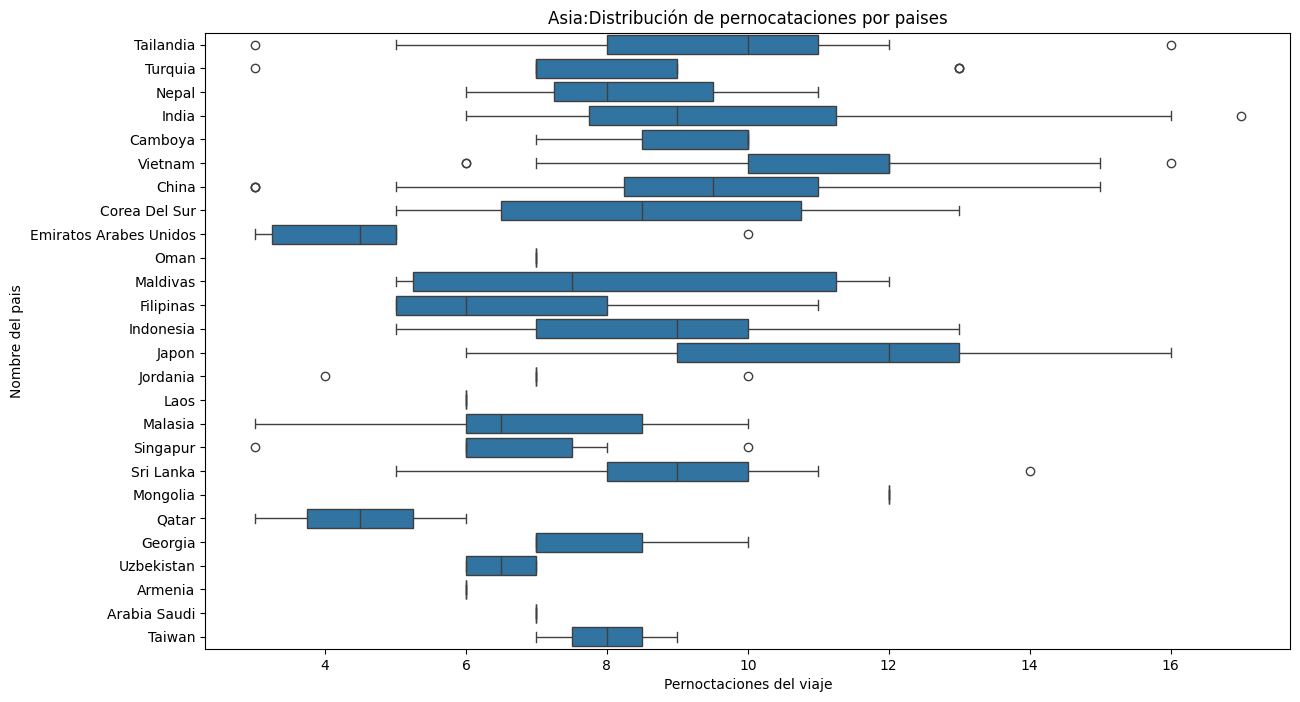

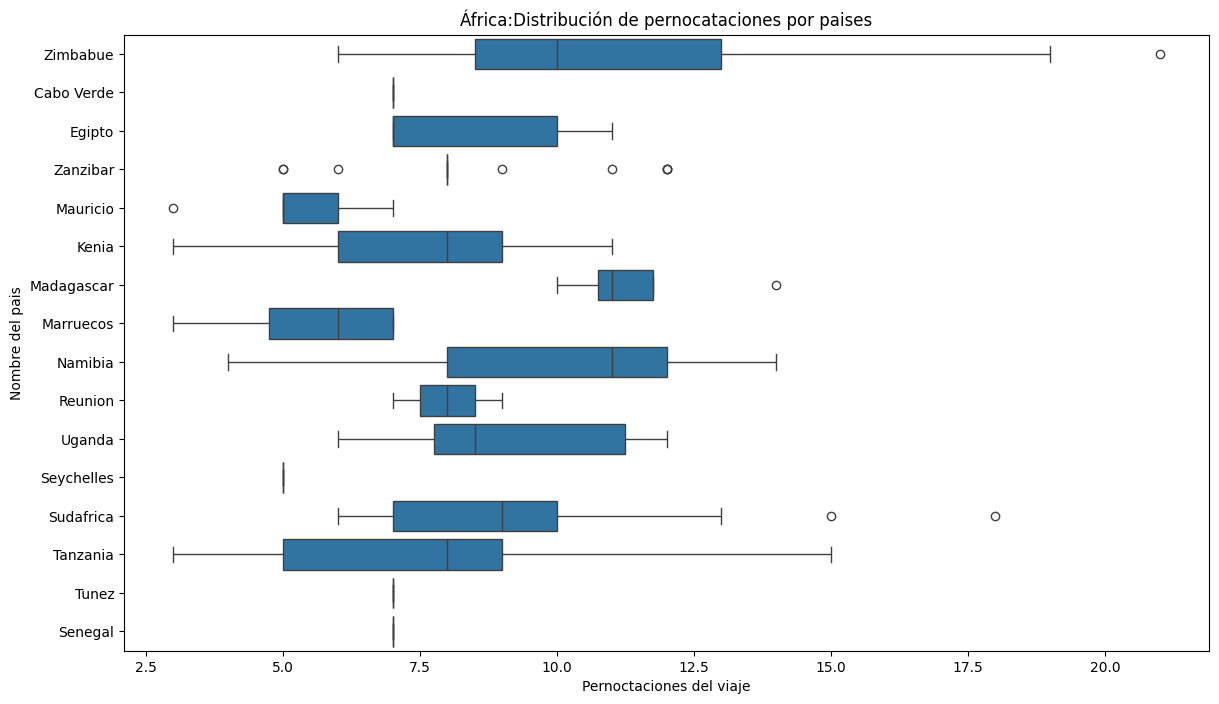

In [747]:
for continente in df_viajes_precios_paises_sin_duplicados.nombre_continente.unique().tolist():
    df_filtrado_continente_precios_paises = df_viajes_precios_paises_sin_duplicados[df_viajes_precios_paises_sin_duplicados.nombre_continente == continente]
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        y='nombre_pais_destino',
        x='duracion_noches',
        data=df_filtrado_continente_precios_paises)
    plt.title(f'{continente}:Distribución de pernocataciones por paises')
    plt.xlabel('Pernoctaciones del viaje')
    plt.ylabel('Nombre del pais')
    plt.show()

## 9. Análisis del número de ciudades por las que pasa un itinerario

In [748]:
df_recuento_ciudades_itinerario = df_ciudad_itinerario.id_itinerario.value_counts().reset_index()
df_recuento_ciudades_itinerario.head()

id_itinerario  count
0            359     22
1            756     20
2            601     20
3            614     20
4            618     20

In [749]:
df_ciudad.head()

id_ciudad nombre_ciudad  id_pais_destino
0          1        Tirana                1
1          2        Durres                1
2          3         Berat                1
3          4         Kruja                1
4          5       Shkoder                1

In [750]:
df_viajes_precios_paises_sin_duplicados['num_ciudades']=None

In [751]:
ex.incorporar_información_df_original(df_viajes_precios_paises_sin_duplicados,df_recuento_ciudades_itinerario,'id_itinerario','count','num_ciudades')

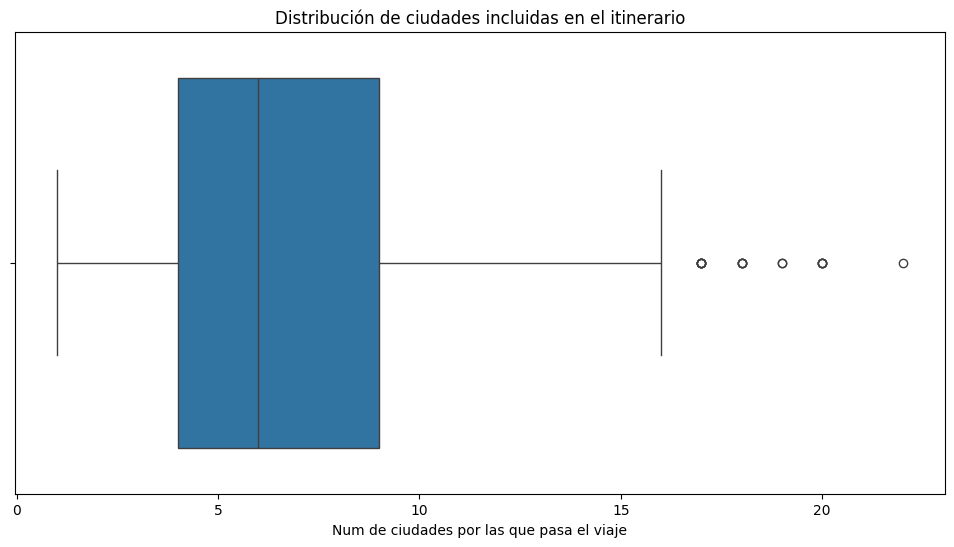

In [752]:
#Distribución de ciudades agrupados
plt.figure(figsize=(12, 6))
sns.boxplot(x='num_ciudades', data=df_viajes_precios_paises_sin_duplicados)
plt.title('Distribución de ciudades incluidas en el itinerario')
plt.xlabel('Num de ciudades por las que pasa el viaje')
plt.show()

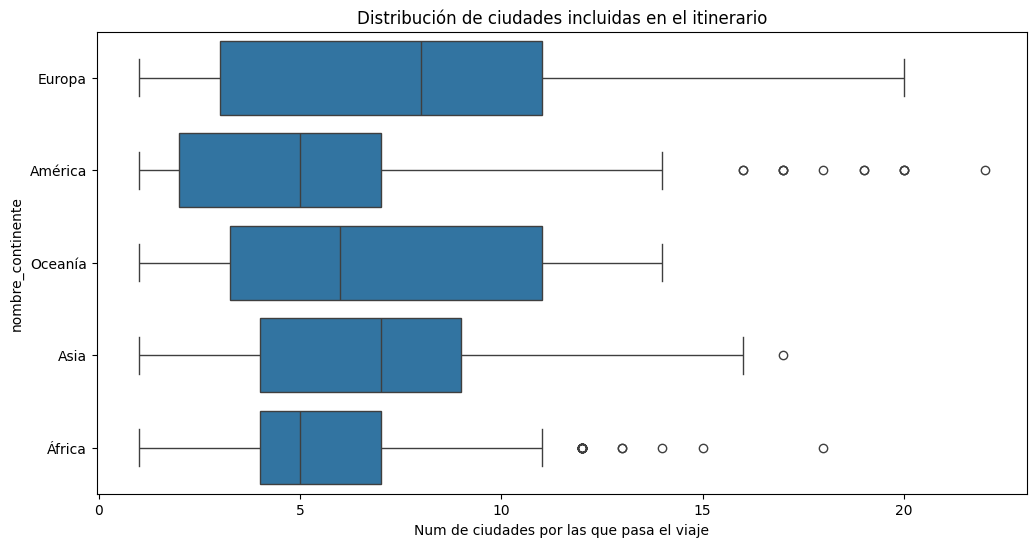

In [753]:
#Distribución de viajes agrupados
plt.figure(figsize=(12, 6))
sns.boxplot(x='num_ciudades',y='nombre_continente', data=df_viajes_precios_paises_sin_duplicados)
plt.title('Distribución de ciudades incluidas en el itinerario')
plt.xlabel('Num de ciudades por las que pasa el viaje')
plt.show()


- Europa es la que mayor variabilidad de ciudades tiene, no obstante, América es el continente que tiene viajes con más ciudades asociadas. 
- Tanto en África como en América existen itinerarios con un número de ciudades superiores como outliers. 
- El promedio de ciudades por itinerarios está en el rango de 5 a 8 ciudades. Siendo Europa el que mayor promedio tiene y América y África las que menos.

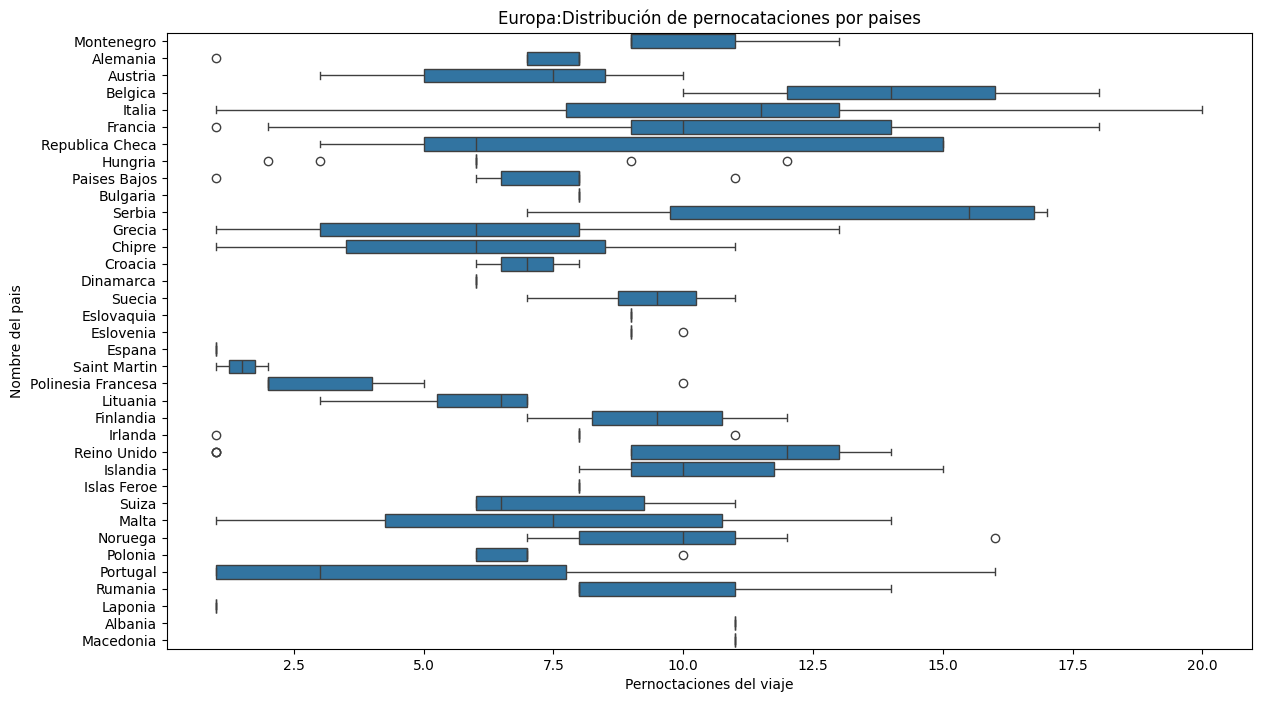

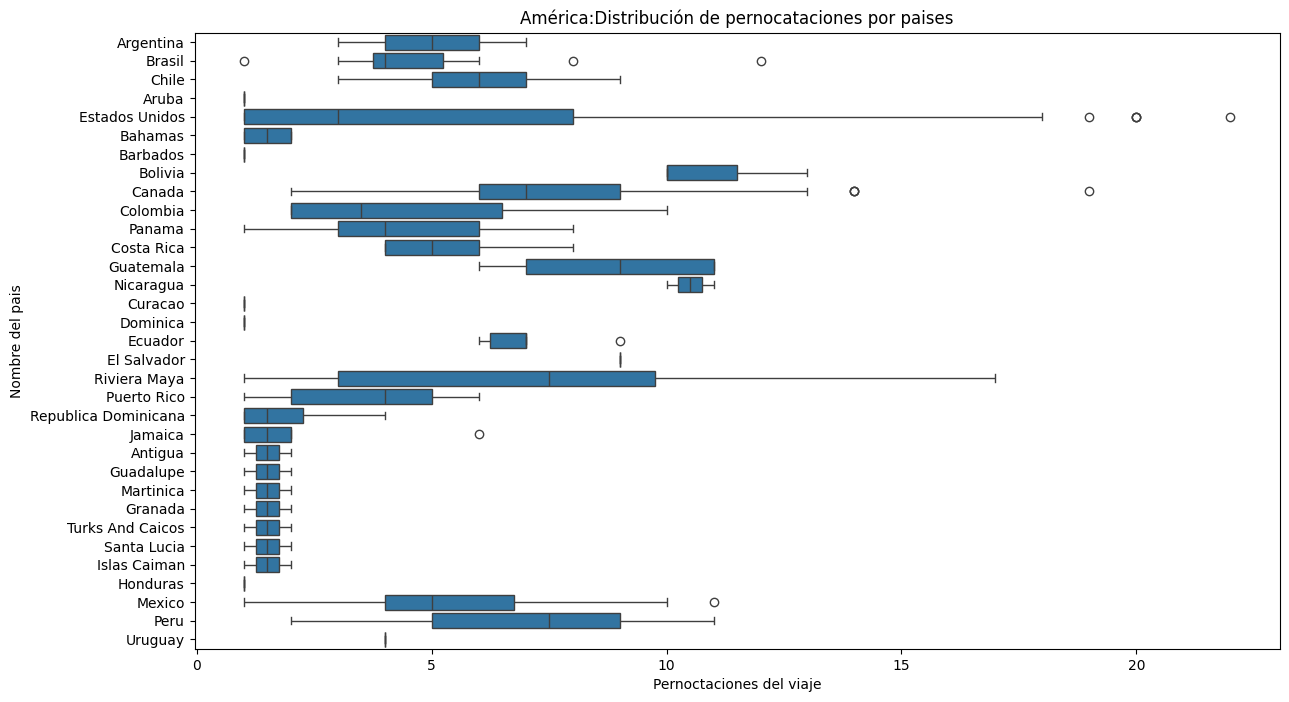

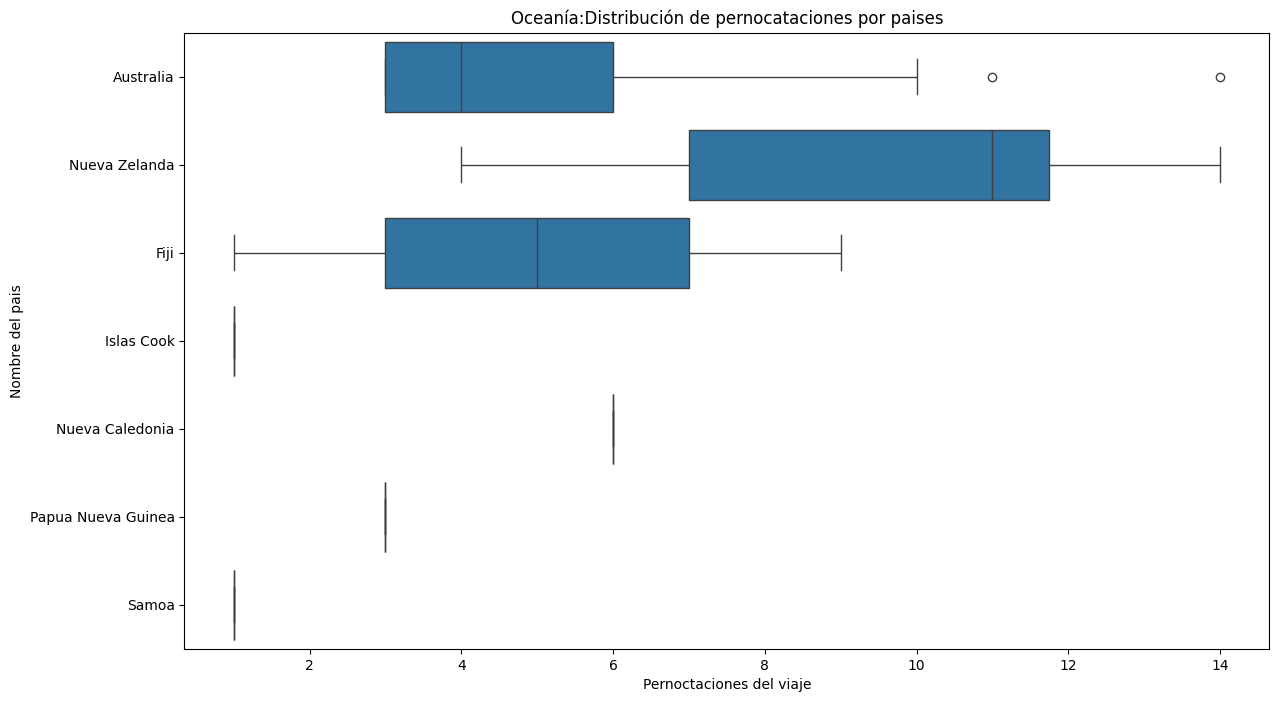

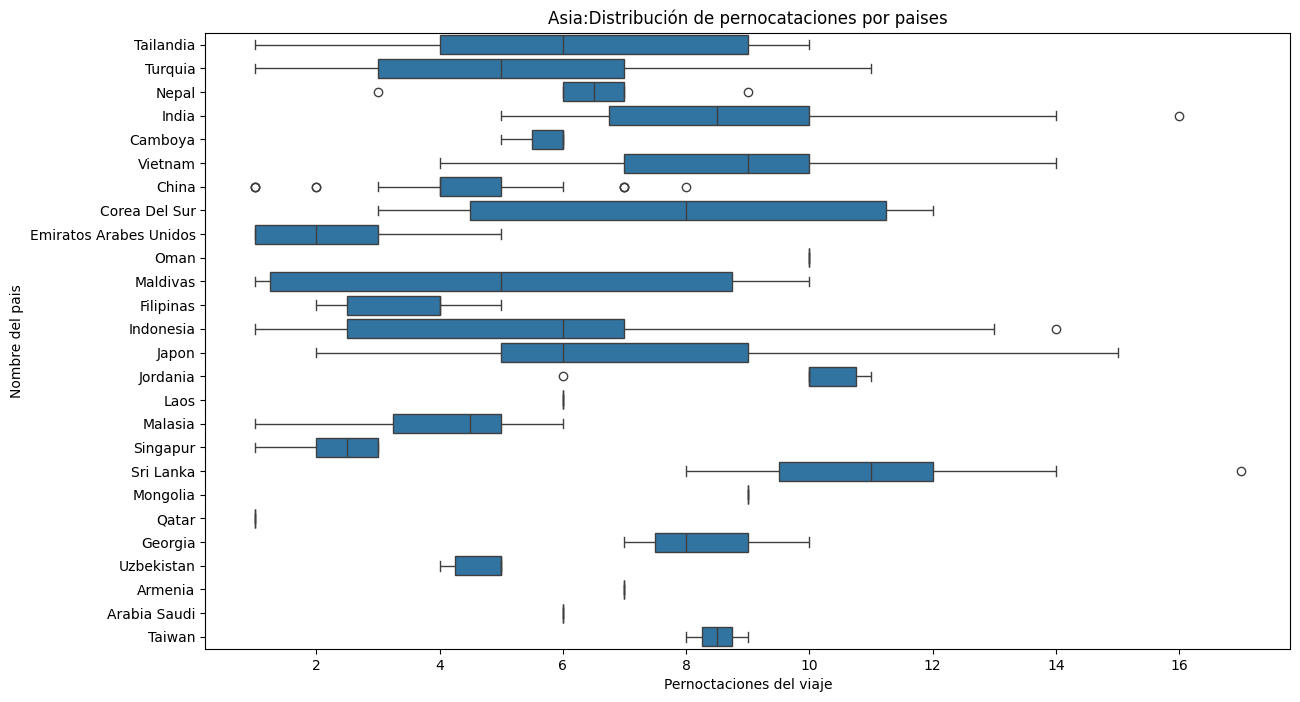

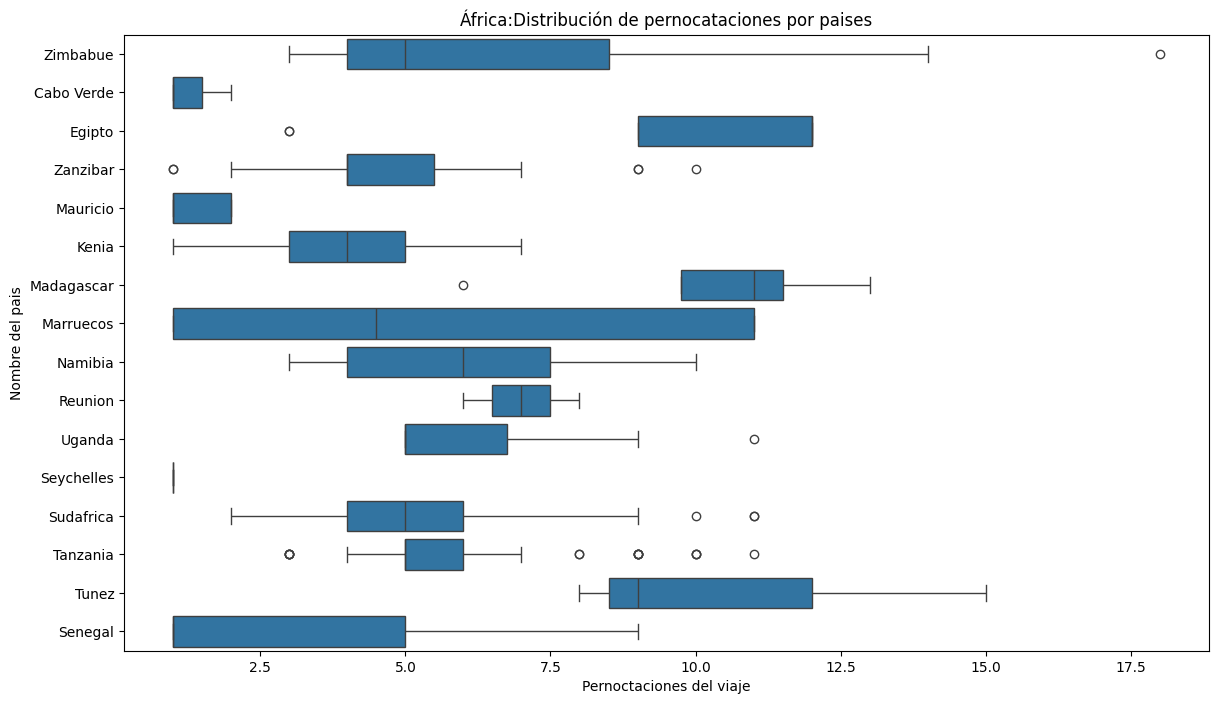

In [754]:
for continente in df_viajes_precios_paises_sin_duplicados.nombre_continente.unique().tolist():
    df_filtrado_continente_precios_paises = df_viajes_precios_paises_sin_duplicados[df_viajes_precios_paises_sin_duplicados.nombre_continente == continente]
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        y='nombre_pais_destino',
        x='num_ciudades',
        data=df_filtrado_continente_precios_paises)
    plt.title(f'{continente}:Distribución de pernocataciones por paises')
    plt.xlabel('Pernoctaciones del viaje')
    plt.ylabel('Nombre del pais')
    plt.show()

## 10. Análisis del porcentaje de viajes activos

In [755]:
df_viajes_precios_paises.columns

Index(['id_viaje', 'url_viaje', 'nombre_viaje', 'duracion_dias',
       'duracion_noches', 'id_itinerario', 'viaje_activo', 'precio_viaje',
       'fecha_precio_viaje', 'id_pais_destino', 'nombre_pais_destino',
       'nombre_continente'],
      dtype='object')

In [756]:
df_viajes_precios_paises_viajes_activos = df_viajes_precios_paises.drop_duplicates('id_viaje')

In [757]:
df_recuento_viajes_activos = df_viajes_precios_paises_viajes_activos[['viaje_activo','nombre_continente']].value_counts().reset_index()
df_recuento_viajes_activos


viaje_activo nombre_continente  count
0          True           América    461
1          True              Asia    392
2          True            África    301
3          True            Europa    218
4          True           Oceanía     30
5         False            África     24
6         False            Europa     20
7         False           América      8
8         False           Oceanía      4
9         False              Asia      1

In [758]:
df_recuento_viajes_activos = df_viajes_precios_paises_viajes_activos.groupby(
    ['nombre_continente', 'viaje_activo']
).size().reset_index(name='num_viajes')

In [759]:
df_recuento_viajes_activos

nombre_continente  viaje_activo  num_viajes
0           América         False           8
1           América          True         461
2              Asia         False           1
3              Asia          True         392
4            Europa         False          20
5            Europa          True         218
6           Oceanía         False           4
7           Oceanía          True          30
8            África         False          24
9            África          True         301

In [760]:
df_recuento_viajes_activos['porcentaje'] = df_recuento_viajes_activos.groupby('nombre_continente')['num_viajes'].transform(
    lambda x: round(x / x.sum() * 100, 2)
)

In [761]:
df_recuento_viajes_activos

nombre_continente  viaje_activo  num_viajes  porcentaje
0           América         False           8        1.71
1           América          True         461       98.29
2              Asia         False           1        0.25
3              Asia          True         392       99.75
4            Europa         False          20        8.40
5            Europa          True         218       91.60
6           Oceanía         False           4       11.76
7           Oceanía          True          30       88.24
8            África         False          24        7.38
9            África          True         301       92.62

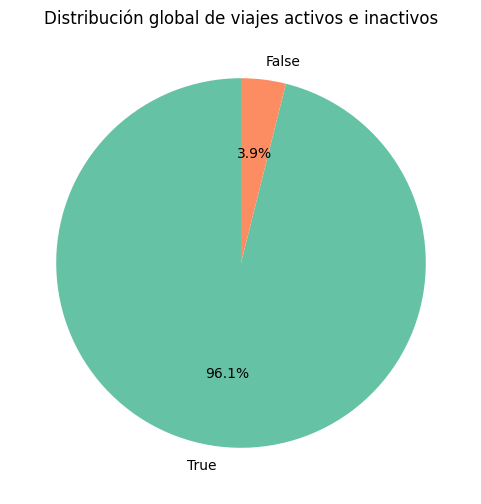

In [762]:
df_global = df_viajes_precios_paises_viajes_activos['viaje_activo'].value_counts().reset_index()
df_global.columns = ['viaje_activo', 'num_viajes']

# Calcular porcentaje
df_global['porcentaje'] = round(df_global['num_viajes'] / df_global['num_viajes'].sum() * 100, 2)

# Gráfico de pastel
plt.figure(figsize=(6, 6))
plt.pie(
    df_global['porcentaje'],
    labels=df_global['viaje_activo'],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2'),
    startangle=90
)
plt.title('Distribución global de viajes activos e inactivos')
plt.show()

In [763]:
df_recuento = df_viajes_precios_paises_viajes_activos.groupby(
    ['nombre_continente', 'viaje_activo']
).size().reset_index(name='num_viajes')

# Calcular porcentaje por continente
df_recuento['porcentaje'] = df_recuento.groupby('nombre_continente')['num_viajes'].transform(
    lambda x: round(x / x.sum() * 100, 2))

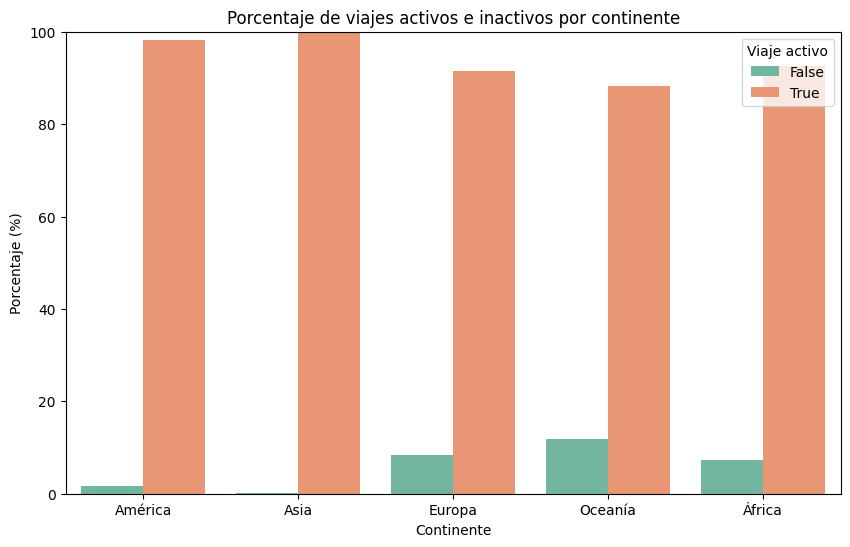

In [764]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_recuento,
    x='nombre_continente',
    y='porcentaje',
    hue='viaje_activo',
    palette='Set2'
)

plt.title('Porcentaje de viajes activos e inactivos por continente')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Continente')
plt.legend(title='Viaje activo')
plt.ylim(0, 100)
plt.show()

En este gráfico se observa el % de viajes desactivados por paises, siendo Oceanía el pais que mayor proporción de viajes desactivados tiene con respecto al total del continente